# Subclonal and clonal variants in SARS-CoV-2 derived from ENA dataset

**Background**

The ENA dataset (queried on 07/07/2021, n=44,371) provides the raw reads on which to perform variant calling with LoFreq. LoFreq annotates its variant calls with the observed VAF of the variant 
and it does not impose assumptions about the ploidy in order to allow for calling subclonal variants. We processed all these samples through the CoVigator pipeline through read trimming, alignment, deduplication, LoFreq variant calling, variant normalization and finally annotations. In the CoVigator analysis pipeline we annotate all variants with a frequency >= 0.8 as clonal, any
variant with a frequency < 0.8 as subclonal and furthermore any variant < 0.2 as low frequency.

**Motivation**

Although LoFreq applies a default filtering strategy on the variant calls, our dataset of subclonal variants is one order of magnitude larger than the clonal dataset. Some samples with extreme counts of clonal variants were excluded in the CoVigator knowledge base data loading. We want to assess here if we can define a procedure to determine a high confidence subclonal dataset.

Furthermore, we want to investigate if there is a temporal correlation between the appearance of subclonal variants and the appearance of clonal variants. We want to assess whether the subclonal dataset is fit to predict future clonal mutations.

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("poster")
import numpy as np
from matplotlib.ticker import ScalarFormatter 
from matplotlib_venn import venn2, venn2_circles
from upsetplot import UpSet

import warnings
warnings.filterwarnings('ignore')

import math
sns.set_style("whitegrid")

In [3]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [4]:
blue = sns.color_palette("colorblind")[0]
orange = sns.color_palette("colorblind")[1]
green = sns.color_palette("colorblind")[2]
red = sns.color_palette("colorblind")[3]
brown = sns.color_palette("colorblind")[5]
grey = sns.color_palette("colorblind")[7]
lightblue = sns.color_palette("colorblind")[-1]

In [5]:
SARS_COV_2_GENOME_LENGTH = 29903

## Data loading

In [6]:
data_folder = '/data'
figure_output_folder = 'figures'

In [16]:
def load_data():
    clonal_variants = pd.read_csv(os.path.join(data_folder, 'variant_observation.csv.gz'))
    subclonal_variants = pd.read_csv(os.path.join(data_folder, 'subclonal_variant_observation.csv.gz'))
    low_frequency_variants = pd.read_csv(os.path.join(data_folder, 'low_frequency_variant_observation.csv.gz'))
    sample_ena = pd.read_csv(os.path.join(data_folder, 'sample_ena.csv.gz'))
    sample_ena["month"] = pd.to_datetime(sample_ena.collection_date, format='%Y-%m-%d', errors='coerce').dt.to_period('m')
    
    # filter out samples without a collection date
    sample_ena = sample_ena[~ sample_ena.collection_date.isna()]
    sample_ena = sample_ena[sample_ena.status == 'FINISHED']
    sample_ena['artic'] = sample_ena.library_name.transform(lambda x: "ARTIC" if x is not None and ('ARTIC' in str(x) or 'ARCTIC' in str(x)) else "Unknown")
    
    # annotates variants with sample metadata
    clonal_variants = pd.merge(left=clonal_variants, right=sample_ena[["run_accession", "library_strategy", "artic"]], 
             left_on="sample", right_on="run_accession", how="inner")
    subclonal_variants = pd.merge(left=subclonal_variants, right=sample_ena[["run_accession", "library_strategy", "artic"]], 
             left_on="sample", right_on="run_accession", how="inner")
    low_frequency_variants = pd.merge(left=low_frequency_variants, right=sample_ena[["run_accession", "library_strategy", "artic"]], 
             left_on="sample", right_on="run_accession", how="inner")
    
    print("Subclonal variant calls: {}".format(subclonal_variants.shape[0]))
    print("Clonal variant calls: {}".format(clonal_variants.shape[0]))
    print("Subclonal unique variants: {}".format(subclonal_variants.variant_id.unique().shape[0]))
    print("Clonal unique variants: {}".format(clonal_variants.variant_id.unique().shape[0]))
    print("Samples: {}".format(sample_ena.run_accession.unique().shape[0]))
    
    return clonal_variants, subclonal_variants, low_frequency_variants, sample_ena

In [17]:
clonal_variants, subclonal_variants, low_frequency_variants, sample_ena = load_data()

Subclonal variant calls: 1861610
Clonal variant calls: 2258672
Subclonal unique variants: 120038
Clonal unique variants: 27937
Samples: 84048


In [10]:
# add collection date to all variants
def add_dates_to_variants(variants, samples):
    variants_with_collection_date = pd.merge(
        left=variants[["variant_id", "sample", "cons_hmm_sars_cov_2", "gene_name", "hgvs_p"]], 
        right=samples[["run_accession", "collection_date"]], 
        left_on="sample", right_on="run_accession", how="inner")
    variants_with_collection_date.collection_date = pd.to_datetime(variants_with_collection_date.collection_date)
    variants_with_collection_date["collection_date_month"] = variants_with_collection_date.collection_date.dt.to_period('m')
    variants_with_collection_date["collection_date_month_str"] = variants_with_collection_date.collection_date_month.astype(str)
    return variants_with_collection_date
    

clonal_variants_with_collection_date = add_dates_to_variants(variants=clonal_variants, samples=sample_ena)
subclonal_variants_with_collection_date = add_dates_to_variants(variants=subclonal_variants, samples=sample_ena)

In [20]:
def filter_out_synonymous_variants(data):
    return data[data.annotation_highest_impact != 'synonymous_variant']

In [21]:
clonal_snvs = clonal_variants[clonal_variants.variant_type == 'SNV']
subclonal_snvs = subclonal_variants[subclonal_variants.variant_type == 'SNV']
low_frequency_snvs = low_frequency_variants[low_frequency_variants.variant_type == 'SNV']
clonal_mnvs = clonal_variants[clonal_variants.variant_type == 'MNV']
subclonal_mnvs = subclonal_variants[subclonal_variants.variant_type == 'MNV']
low_frequency_snvs = low_frequency_variants[low_frequency_variants.variant_type == 'SNV']
clonal_indels = clonal_variants[clonal_variants.variant_type.isin(['INSERTION', 'DELETION'])]
subclonal_indels = subclonal_variants[subclonal_variants.variant_type.isin(['INSERTION', 'DELETION'])]
low_frequency_indels = low_frequency_variants[low_frequency_variants.variant_type.isin(['INSERTION', 'DELETION'])]
clonal_snvs_non_synonymous = filter_out_synonymous_variants(clonal_snvs)
subclonal_snvs_non_synonymous = filter_out_synonymous_variants(subclonal_snvs)

In [13]:
print("Subclonal SNVs calls: {}".format(subclonal_snvs.shape[0]))
print("Clonal SNVs calls: {}".format(clonal_snvs.shape[0]))
print("Subclonal unique SNVs: {} ({} % of all possible mutations)".format(subclonal_snvs.variant_id.unique().shape[0], 
                                                                          round((subclonal_snvs.variant_id.unique().shape[0] / (SARS_COV_2_GENOME_LENGTH * 3)) * 100, 3)))
print("Clonal unique SNVs: {} ({} % of all possible mutations)".format(clonal_snvs.variant_id.unique().shape[0], 
                                                                       round((clonal_snvs.variant_id.unique().shape[0] / (SARS_COV_2_GENOME_LENGTH * 3)) * 100, 3)))
print("Subclonal indel calls: {}".format(subclonal_indels.shape[0]))
print("Clonal indel calls: {}".format(clonal_indels.shape[0]))
print("Subclonal unique indels: {}".format(subclonal_indels.variant_id.unique().shape[0]))
print("Clonal unique indels: {}".format(clonal_indels.variant_id.unique().shape[0]))

Subclonal SNVs calls: 1134527
Clonal SNVs calls: 2060026
Subclonal unique SNVs: 74702 (83.271 % of all possible mutations)
Clonal unique SNVs: 26372 (29.397 % of all possible mutations)
Subclonal indel calls: 727770
Clonal indel calls: 199733
Subclonal unique indels: 45369
Clonal unique indels: 1572


In [14]:
clonal_snvs_with_collection_date = add_dates_to_variants(variants=clonal_snvs, samples=sample_ena)
subclonal_snvs_with_collection_date = add_dates_to_variants(variants=subclonal_snvs, samples=sample_ena)

## Subclonal variant quality controls

We want to filter down the list of subclonal SNVs to high quality calls.

### Variant allele frequency distribution

The distribution of VAFs shows two peaks at each extreme of the frequency range (0.0, 0.05] and (0.95, 1.0] with a marked valley between 0.25 and 0.8.
It is remarkable that while indels are less abundant in the clonal dataset than SNVs, this is not the case for the subclonal dataset.
In fact around half (ie: 4,261,588 indels and 4,294,355 SNVs) of the subclonal dataset is composed of indels.

In [36]:
def get_frequency_distribution(data, bins, normalization_factor):
    data["vaf_bin"] = pd.cut(data.vaf, bins=np.linspace(0, 1.0, bins))
    frequencies = data[["vaf_bin", 'variant_type', "variant_id"]].groupby(["vaf_bin", "variant_type"]).count().reset_index()
    frequencies = frequencies.rename(columns={"variant_id": "count"})
    frequencies['count'] = frequencies['count'] / normalization_factor
    return frequencies

def parse_variant_type(vt):
    if vt == 'INSERTION':
        return 'Insertions'
    if vt == 'DELETION':
        return 'Deletions'
    if vt == 'SNV':
        return 'SNVs'
    if vt == 'MNV':
        return 'MNVs'
    return vt

def get_frequency_distribution_with_variant_type(data, bins, min_count=100):
    data["vaf_bin"] = pd.cut(data.vaf, bins=np.linspace(0, 1.0, bins))
    frequencies = data[["vaf_bin", "variant_type", "annotation_highest_impact",  "variant_id"]].groupby(["vaf_bin", "variant_type", "annotation_highest_impact"]).count().reset_index()
    frequencies = frequencies.rename(columns={"variant_id": "count"})
    frequencies['vaf_bin'] = frequencies['vaf_bin'].astype(str)
    
    grouped_counts = frequencies.groupby(['variant_type', 'annotation_highest_impact']).sum().reset_index()
    small_groups = grouped_counts[grouped_counts['count'] < 1000]
    for vt in frequencies.variant_type.unique():
        frequencies.loc[(frequencies.variant_type == vt) & (frequencies.annotation_highest_impact.isin(small_groups[small_groups.variant_type == vt])), 'annotation_highest_impact'] = 0
    
    return frequencies


def plot_vaf_by_variant_type(clonal_data, subclonal_data, low_frequency_data, num_bins=21, title=None, normalization_factor=1):
    
    vaf_clonal = get_frequency_distribution(clonal_data, bins=num_bins, normalization_factor=normalization_factor)
    vaf_clonal['variant_type'] = vaf_clonal.variant_type.transform(lambda x: parse_variant_type(x))
    vaf_subclonal = get_frequency_distribution(subclonal_data, bins=num_bins, normalization_factor=normalization_factor)
    vaf_subclonal['variant_type'] = vaf_subclonal.variant_type.transform(lambda x: parse_variant_type(x))
    vaf_low_frequency = get_frequency_distribution(low_frequency_data, bins=num_bins, normalization_factor=normalization_factor)
    vaf_low_frequency['variant_type'] = vaf_low_frequency.variant_type.transform(lambda x: parse_variant_type(x))
    
    
    fig, axes = plt.subplots(2, 1, figsize=(30, 12), sharex=True, gridspec_kw={'height_ratios':[4,1]})
    ax = axes[0]
    ax2 = axes[1]
        
    sns.barplot(data=vaf_clonal, x="vaf_bin", y="count", hue="variant_type", 
                palette=[sns.color_palette("Blues")[4], sns.color_palette("Oranges")[4], sns.color_palette("colorblind")[8], sns.color_palette("Greens")[4]], 
                ax=ax)
    sns.barplot(data=vaf_subclonal, x="vaf_bin", y="count", hue="variant_type", 
                palette=[sns.color_palette("Blues")[3], sns.color_palette("Oranges")[3], sns.color_palette("Greens")[3]], 
                ax=ax)
    sns.barplot(data=vaf_low_frequency, x="vaf_bin", y="count", hue="variant_type", 
                palette=[sns.color_palette("Blues")[2], sns.color_palette("Oranges")[2], sns.color_palette("Greens")[2]], 
                ax=ax)
    
    vafs = pd.concat([vaf_clonal, vaf_subclonal, vaf_low_frequency])['vaf_bin'].sort_values(ascending=True).unique()
    sns.barplot(x=vafs, y=[1 for _ in range(20)],
                hue=['Low frequency'] + ["Intrahost" for _ in range(15)] + ["Clonal" for _ in range(4)],
                ax=ax2, 
                palette=[sns.color_palette('Greys')[0], sns.color_palette('Greys')[2], sns.color_palette('Greys')[4]], 
                dodge=False)
        
    ax.grid(axis='y', b=True, which='major', linestyle='--')
    ax.grid(axis='y', b=False, which='minor', linestyle=':')
    #ax.set_title(vt)
    ax.set_yscale('log')
    
    ax.set_ylabel("Count mutations" if normalization_factor == 1 else "Abundance of mutations")
    ax.set_xlabel(None)
    
    ax2.set_ylabel(None)
    ax2.set_xlabel(None)
    ax2.set_xticklabels(vafs, rotation=90)
    ax2.set_yticklabels([])
    ax2.grid(False)
    
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value

            # we change the bar width
            patch.set_width(new_value)

            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)
    
    change_width(ax2, 1.0)

    sns.despine(left=True)
    
    #plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0)) 
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines[0:4], labels[0:4], bbox_to_anchor=(1.0, 1.0))
    ax2.legend(bbox_to_anchor=(1.0, 1.0))
    plt.tight_layout()
    
    return fig

def plot_vaf_with_effect(variants, num_bins=21, title=None):
    
    vafs = get_frequency_distribution_with_variant_type(variants, bins=num_bins)
    vafs.sort_values(['variant_type', 'vaf_bin', 'annotation_highest_impact', 'count'], inplace=True, ascending=False)
    vafs['variant_type'] = vafs.variant_type.transform(parse_variant_type)
    
    counts = vafs.groupby(['variant_type', 'annotation_highest_impact']).sum().reset_index().sort_values(['variant_type', 'count'], ascending=False)
            
    fig, axes = plt.subplots(2, 2, figsize=(25, 16), sharex=True, sharey=True)
    
    palettes = {
        'SNVs': sns.color_palette("Blues"),
        'Insertions': sns.color_palette("Oranges"),
        'Deletions': sns.color_palette("Greys"),
        'MNVs': sns.color_palette("Greens")
    }
    
    ax_idx = 0
    for variant_type, ax in zip(counts.variant_type.unique(), axes.flatten()):
        
        data = vafs[vafs.variant_type == variant_type]
        bottom = None
        
        for ct, color in zip(counts[(counts.variant_type == variant_type) & (counts['count'] > 0)].annotation_highest_impact, palettes.get(variant_type)):
            
            data2 = data[data.annotation_highest_impact == ct]
            data2.sort_values(by=['vaf_bin', 'count'], inplace=True, ascending=[True, True])
            ax.bar(
                data2['vaf_bin'], 
                data2['count'], 
                label="{} - {}: {}".format(variant_type, ct, counts[(counts.variant_type == variant_type) & (counts.annotation_highest_impact == ct)]['count'].iloc[0]),
                color=color,
                #bottom=bottom
            )
            bottom = data2['count']
            
        ax.grid(axis='y', b=True, which='major', linestyle='--')
        #ax.grid(axis='y', b=False, which='minor', linestyle=':')
        ax.set_yscale('log')
        ax.set_xticklabels(data['vaf_bin'].sort_values(ascending=True).unique(), rotation=90)
        ax.set_title(variant_type)
        
        if ax_idx in [0, 2]:
            ax.set_ylabel("Count mutations")
        else:
            ax.set_ylabel(None)
        if ax_idx in [2, 3]:
            ax.set_xlabel("VAF")
        else:
            ax.set_xlabel(None)
        
        ax_idx += 1
        
    lines_labels = [ax.get_legend_handles_labels() for ax in axes.flatten()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, bbox_to_anchor=(1.30, 0.80))
    sns.despine(bottom=True, left=True)
    
    return fig

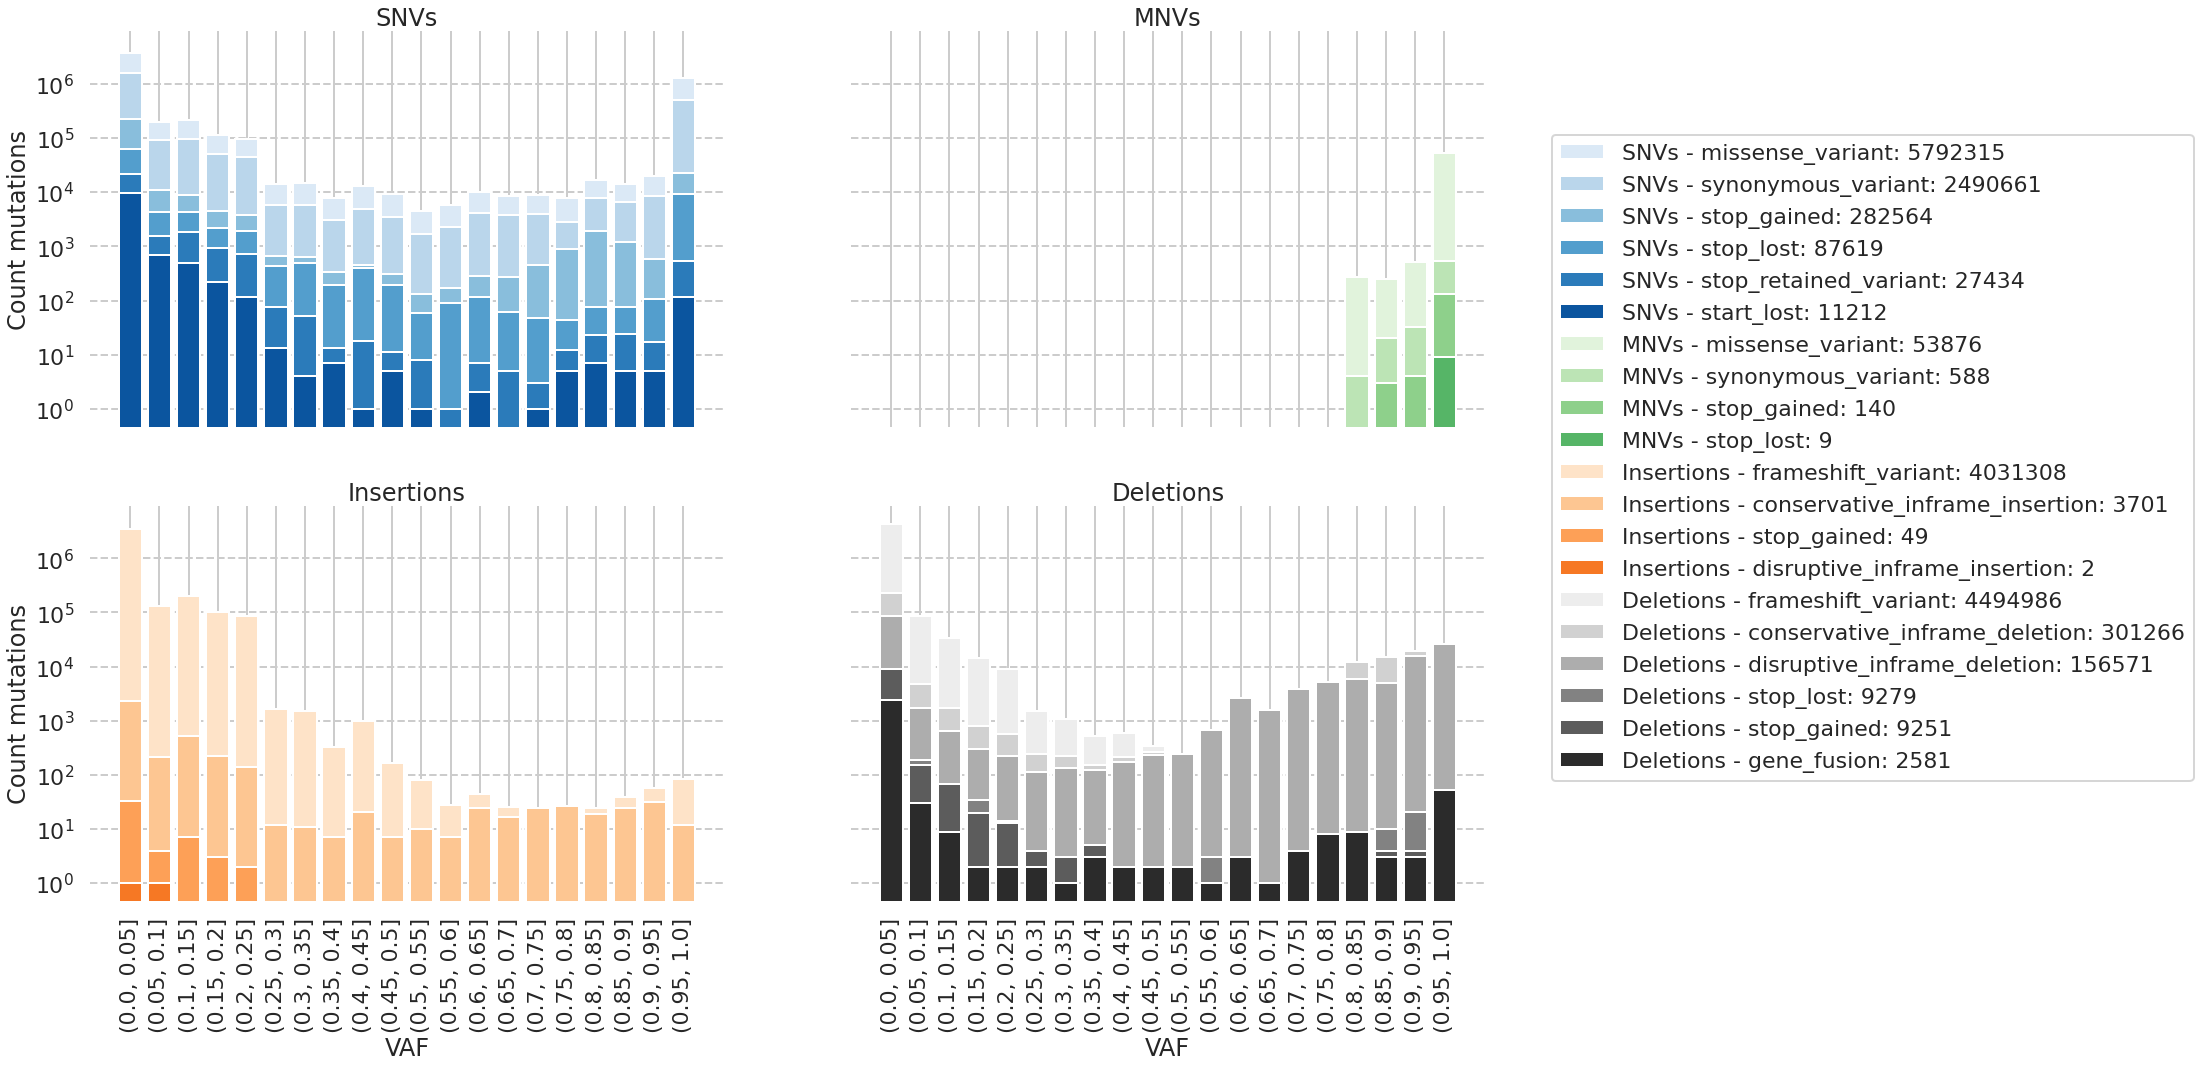

In [221]:
fig = plot_vaf_with_effect(variants=pd.concat([clonal_variants, subclonal_variants, low_frequency_variants]), title="All variants")
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_with_effect.jpg'), dpi=200)

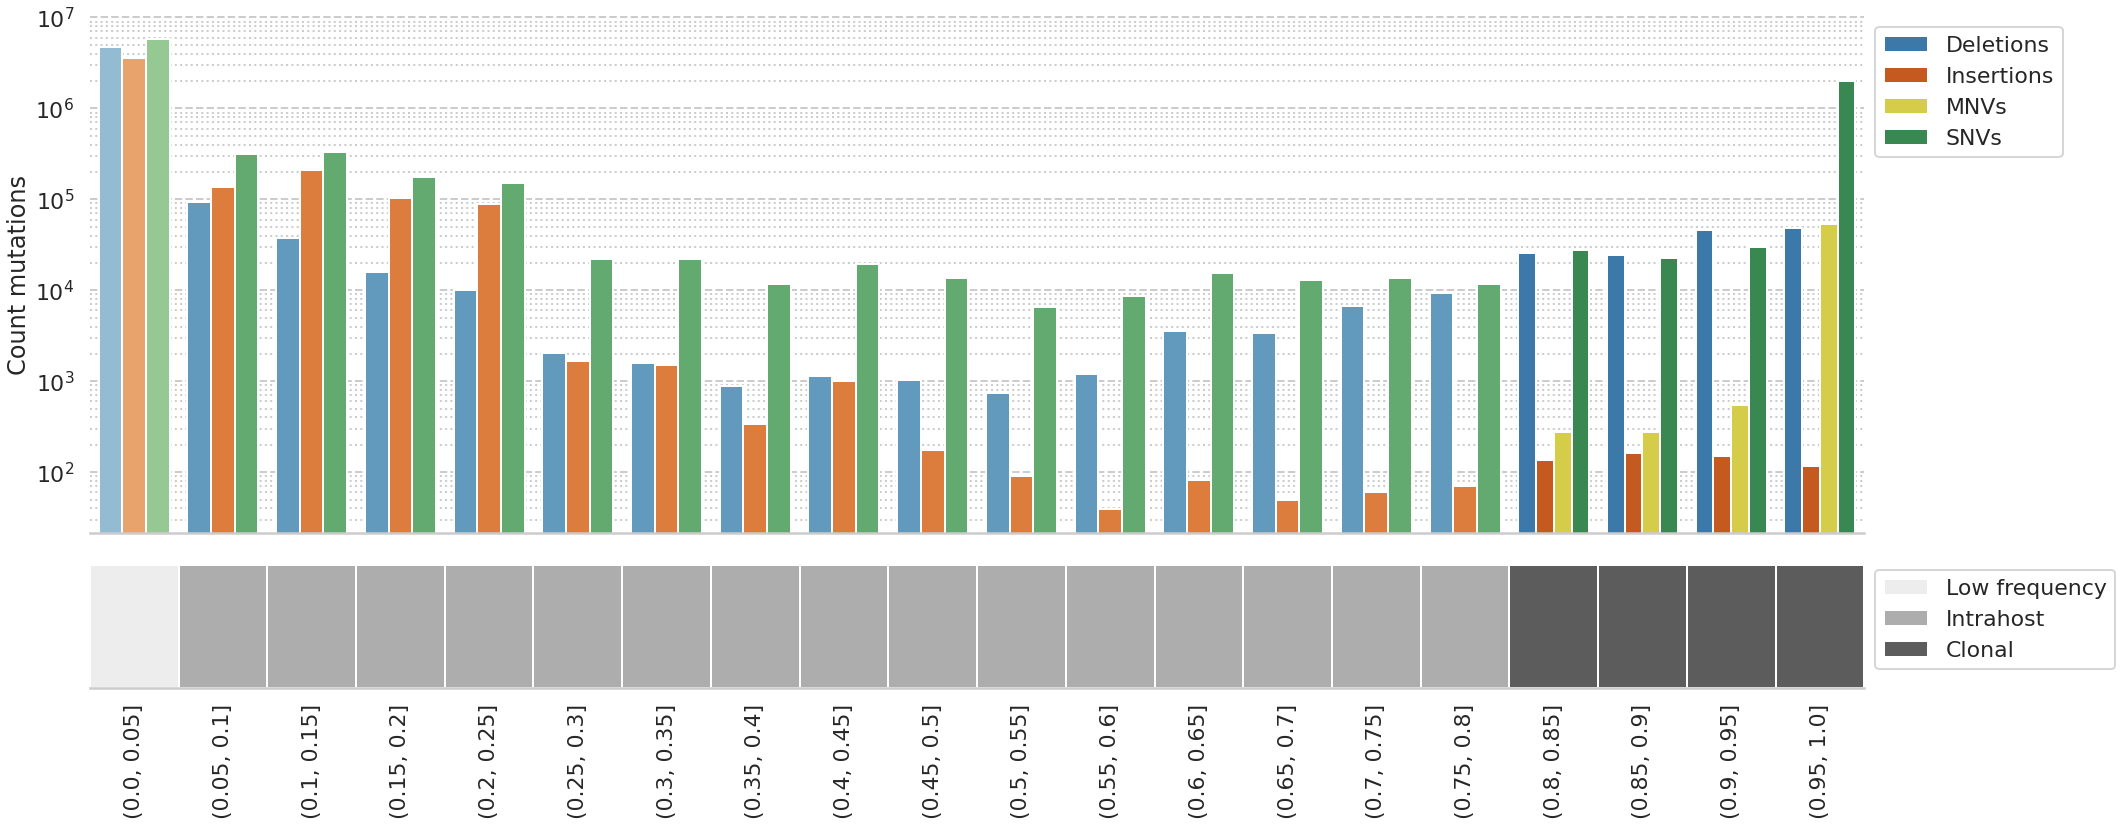

In [35]:
fig = plot_vaf_by_variant_type(clonal_data=clonal_variants, subclonal_data=subclonal_variants, low_frequency_data=low_frequency_variants)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies.jpg'), dpi=200)

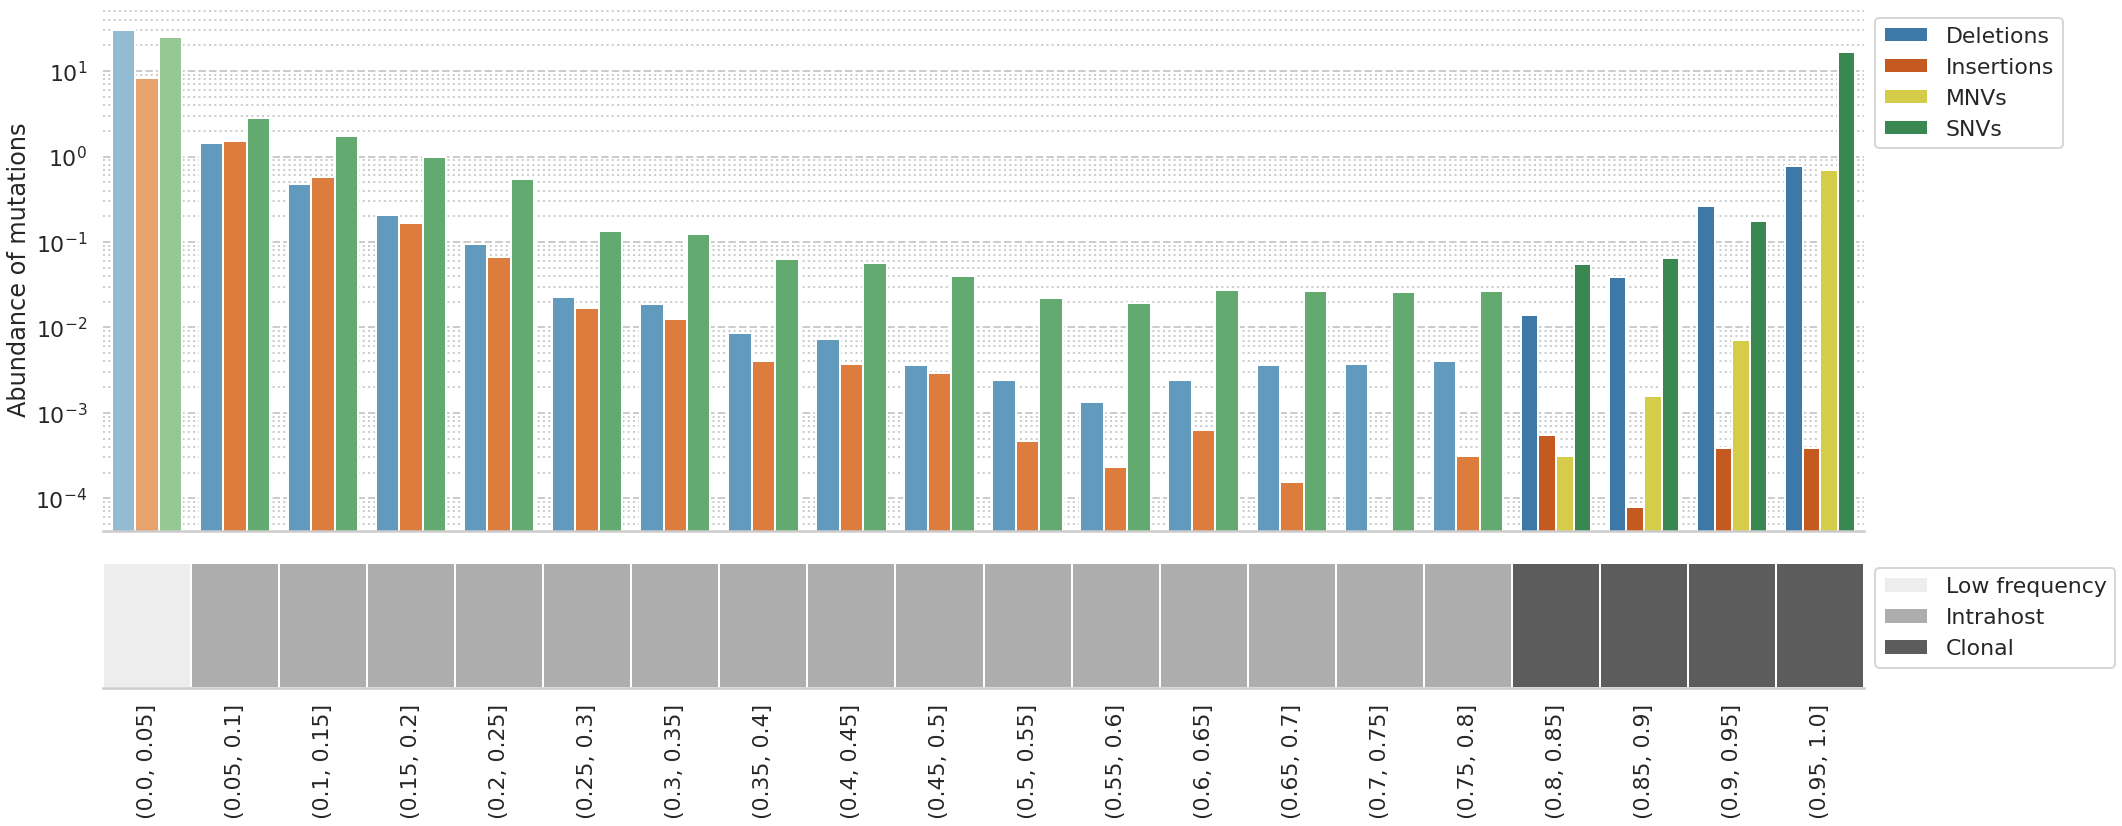

In [43]:
fig = plot_vaf_by_variant_type(
    clonal_data=clonal_variants[clonal_variants.library_strategy == "Targeted-Capture"], 
    subclonal_data=subclonal_variants[subclonal_variants.library_strategy == "Targeted-Capture"],
    low_frequency_data=low_frequency_variants[low_frequency_variants.library_strategy == "Targeted-Capture"],
    normalization_factor=sample_ena[sample_ena.library_strategy == "Targeted-Capture"].run_accession.unique().shape[0]
)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_library_strategy_targeted.jpg'), dpi=200)

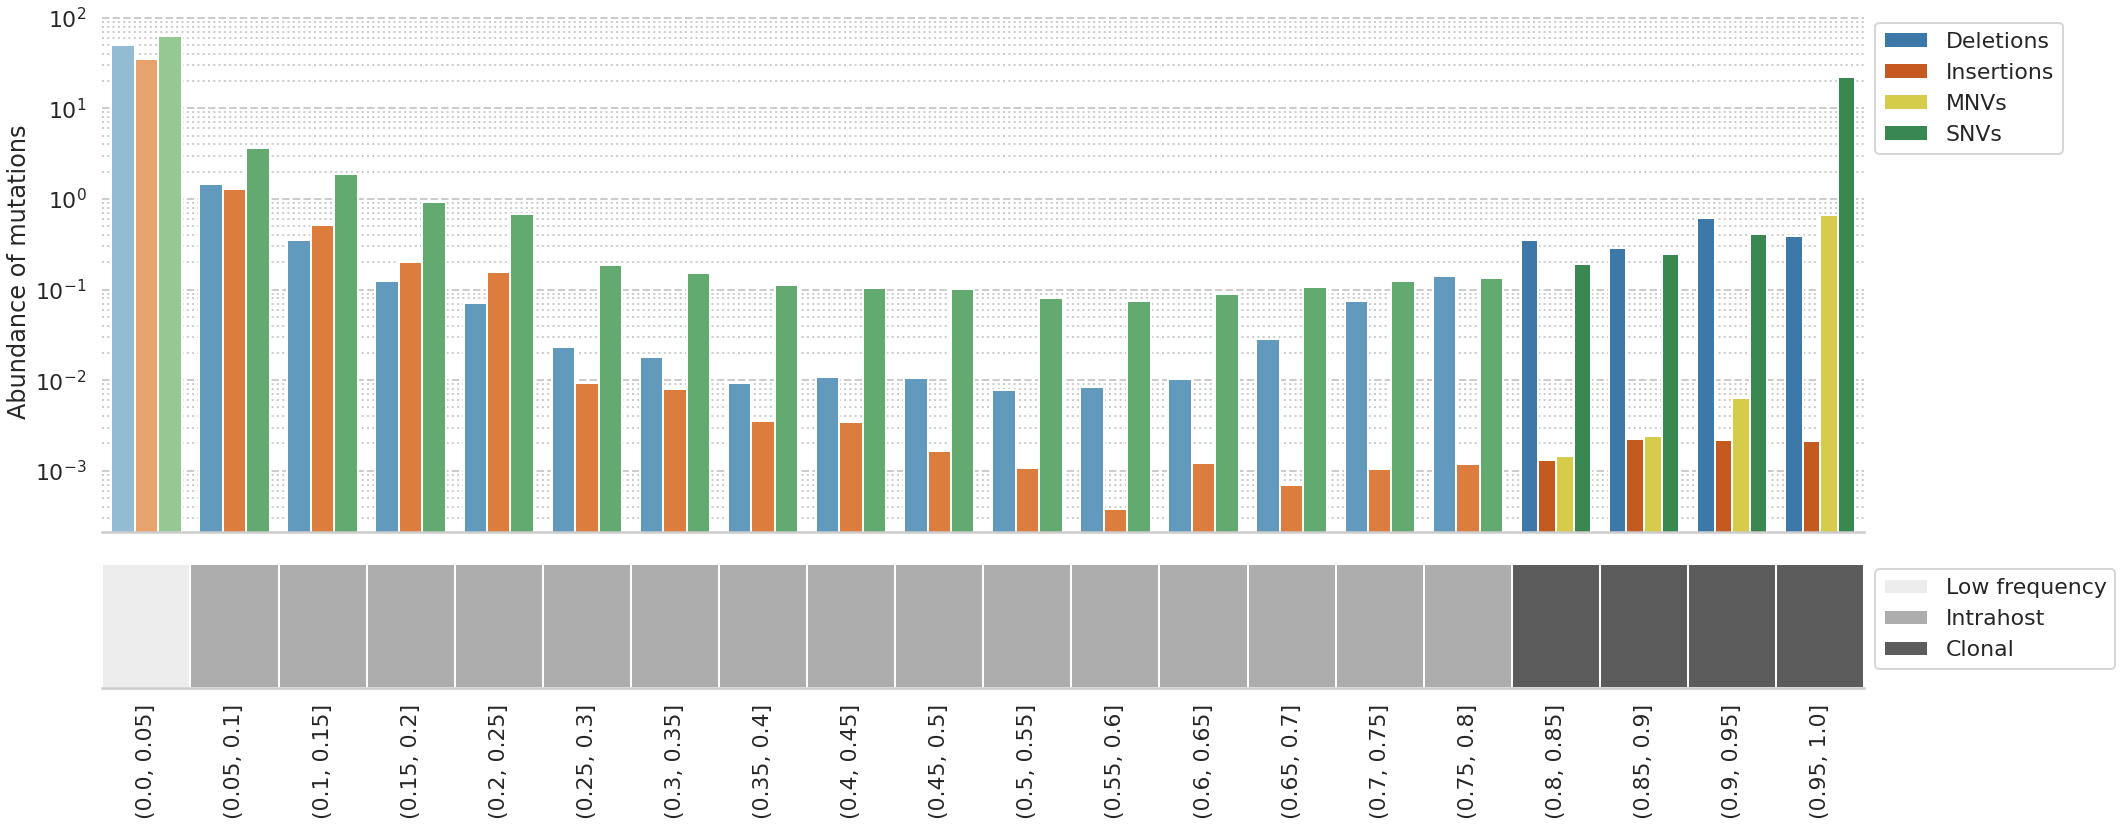

In [44]:
fig = plot_vaf_by_variant_type(
    clonal_data=clonal_variants[clonal_variants.library_strategy == "WGS"], 
    subclonal_data=subclonal_variants[subclonal_variants.library_strategy == "WGS"],
    low_frequency_data=low_frequency_variants[low_frequency_variants.library_strategy == "WGS"],
    normalization_factor=sample_ena[sample_ena.library_strategy == "WGS"].run_accession.unique().shape[0]
)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_library_strategy_wgs.jpg'), dpi=200)

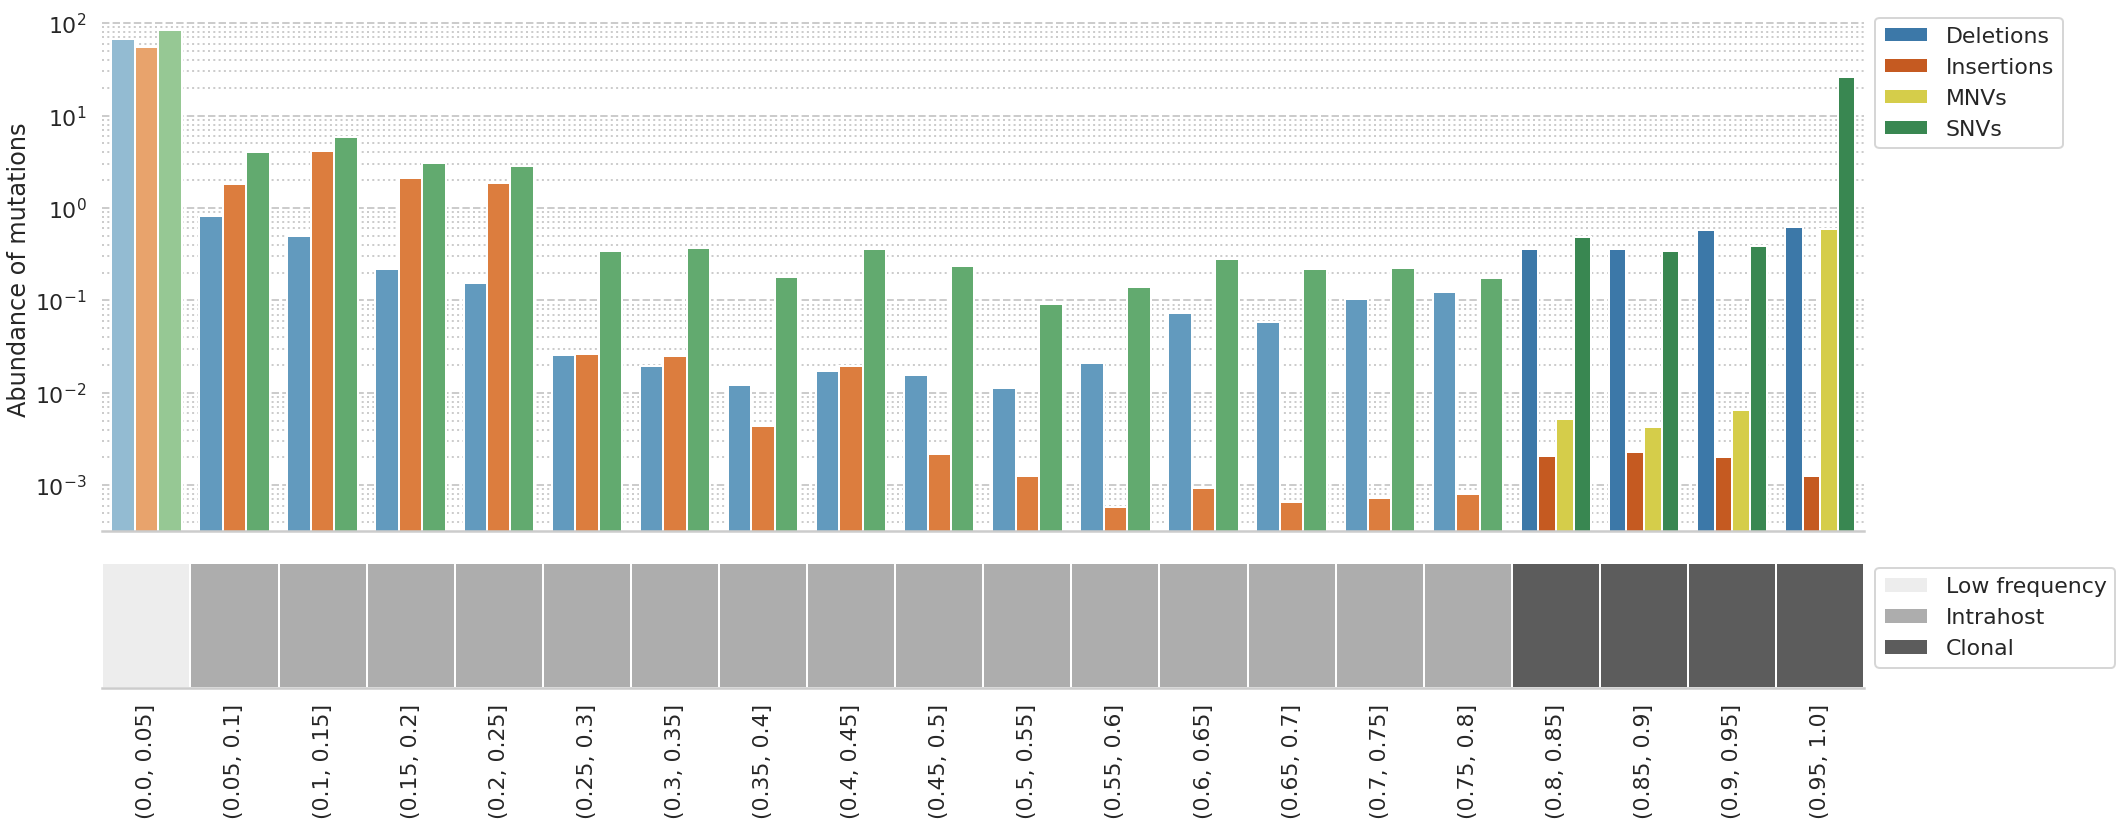

In [45]:
fig = plot_vaf_by_variant_type(
    clonal_data=clonal_variants[clonal_variants.library_strategy == "WGA"], 
    subclonal_data=subclonal_variants[subclonal_variants.library_strategy == "WGA"],
    low_frequency_data=low_frequency_variants[low_frequency_variants.library_strategy == "WGA"],
    normalization_factor=sample_ena[sample_ena.library_strategy == "WGA"].run_accession.unique().shape[0]
)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_library_strategy_wga.jpg'), dpi=200)

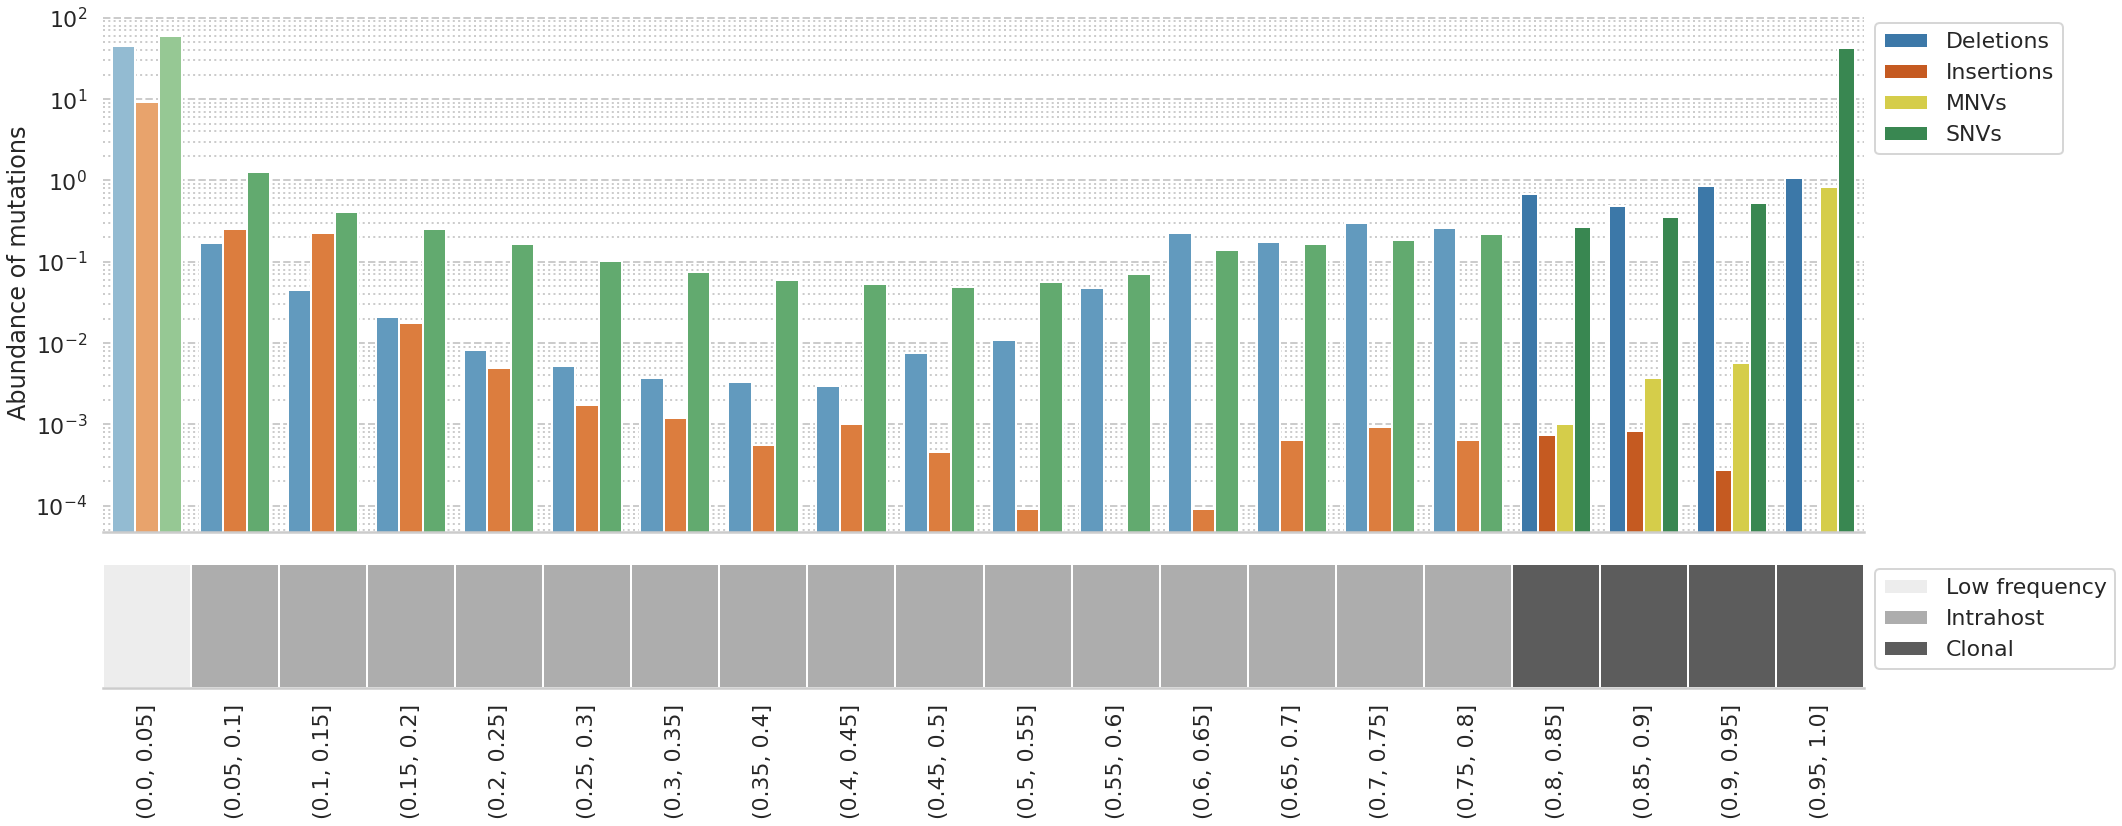

In [47]:
fig = plot_vaf_by_variant_type(
    clonal_data=clonal_variants[clonal_variants.artic == "ARTIC"], 
    subclonal_data=subclonal_variants[subclonal_variants.artic == "ARTIC"],
    low_frequency_data=low_frequency_variants[low_frequency_variants.artic == "ARTIC"],
    normalization_factor=sample_ena[sample_ena.artic == "ARTIC"].run_accession.unique().shape[0]
)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_artic.jpg'), dpi=200)

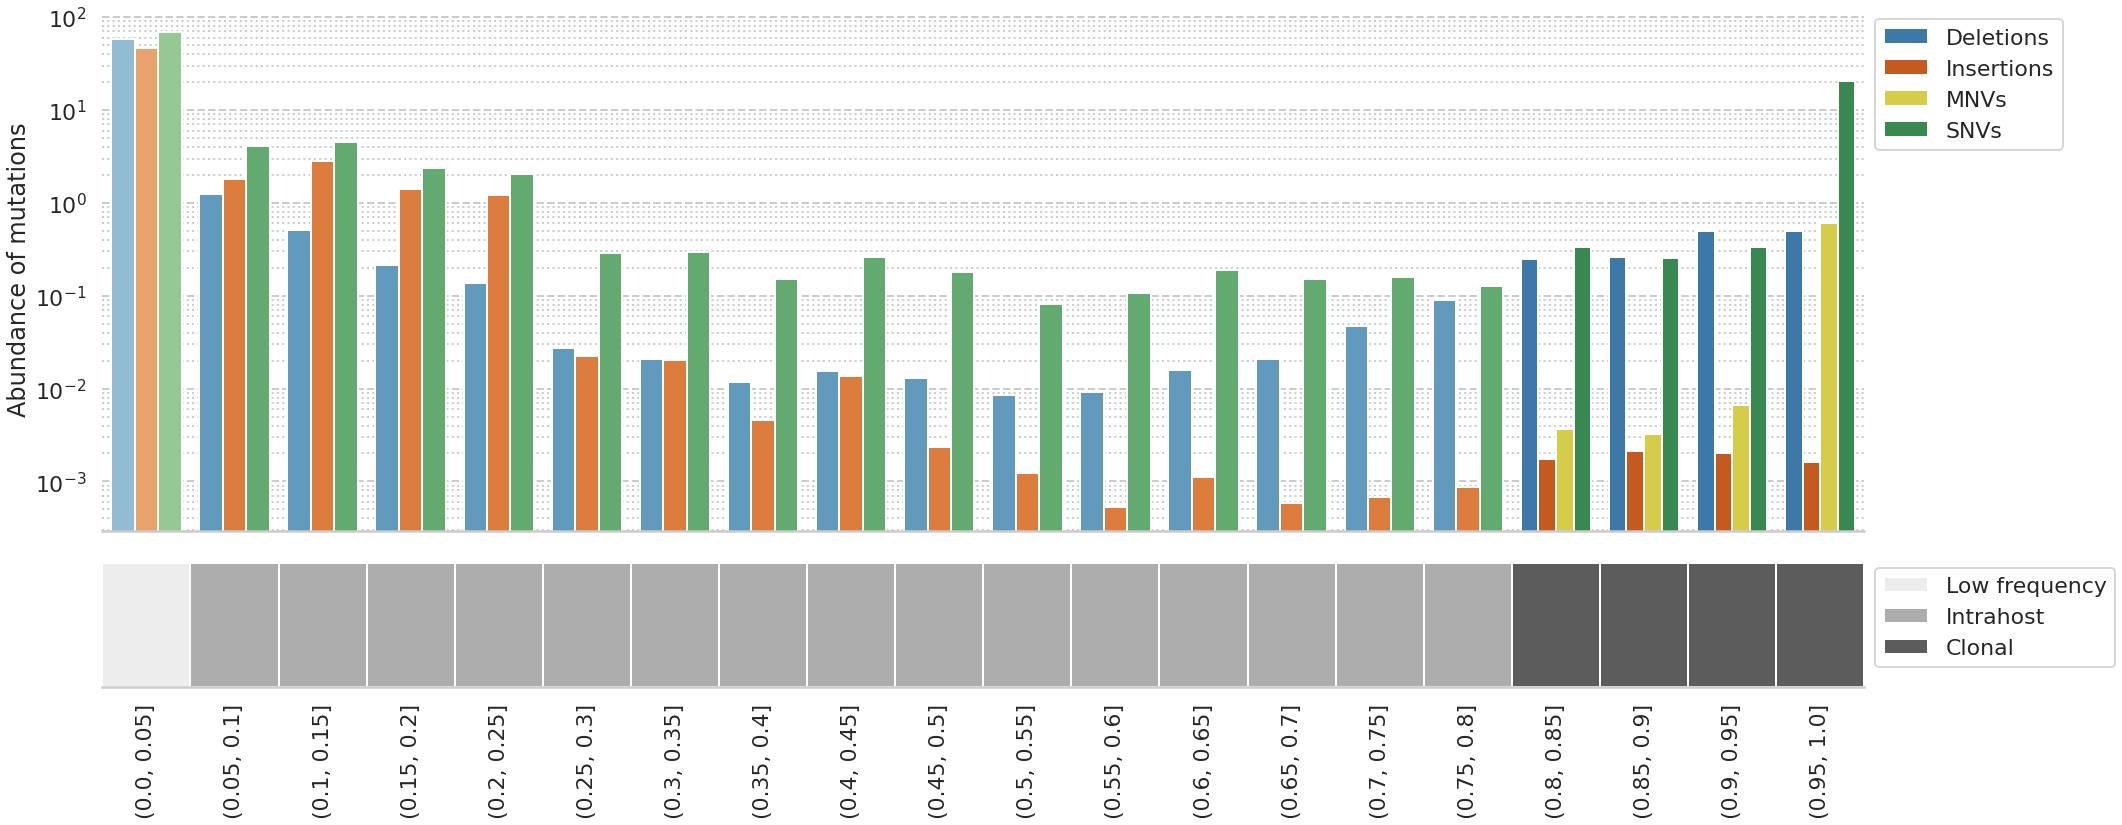

In [46]:
fig = plot_vaf_by_variant_type(
    clonal_data=clonal_variants[clonal_variants.artic == "Unknown"], 
    subclonal_data=subclonal_variants[subclonal_variants.artic == "Unknown"],
    low_frequency_data=low_frequency_variants[low_frequency_variants.artic == "Unknown"],
    normalization_factor=sample_ena[sample_ena.artic == "Unknown"].run_accession.unique().shape[0]
)
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_artic.jpg'), dpi=200)

In [42]:
sample_ena.run_accession.unique().shape[0]

84048

### Filter out samples

We may want to filter out some samples with extreme counts of variants. A similar approach has already been done using the count of clonal SNVs and indels separately. All samples with a count greater than the median plus three times the inter-quartile range were excluded.

#### Number of subclonal SNVs per sample

[None, Text(0.5, 0, '# SNVs')]

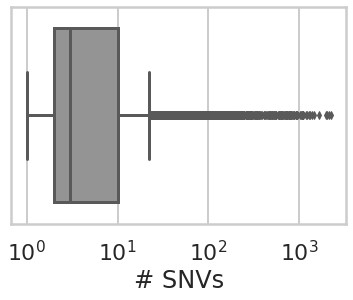

In [52]:
count_subclonal_snvs_per_samples = subclonal_snvs[["sample", "variant_id"]].groupby("sample").count().reset_index().rename(columns={'variant_id': 'count_snvs'})
splot = sns.boxplot(count_subclonal_snvs_per_samples.count_snvs, color=grey)
splot.set(xscale="log", xlabel="# SNVs")

In [53]:
print("Median number of SNVs per sample {}".format(count_subclonal_snvs_per_samples.count_snvs.quantile(0.5)))
iqr_count_subclonal_snvs = count_subclonal_snvs_per_samples.count_snvs.quantile(0.75) - count_subclonal_snvs_per_samples.count_snvs.quantile(0.25)
print("IQR number of SNVs per sample {}".format(iqr_count_subclonal_snvs))

Median number of SNVs per sample 3.0
IQR number of SNVs per sample 8.0


In [54]:
count_snvs_threshold = count_subclonal_snvs_per_samples.count_snvs.quantile(0.5) + (3 * iqr_count_subclonal_snvs)
excluded_samples_count_snvs = count_subclonal_snvs_per_samples[count_subclonal_snvs_per_samples.count_snvs > count_snvs_threshold]["sample"].unique()
print("Filtering all samples with a count of SNVs greater than {}, {} samples and {} SNVs are filtered out".format(
    count_snvs_threshold,
    excluded_samples_count_snvs.shape[0],
    count_subclonal_snvs_per_samples[count_subclonal_snvs_per_samples.count_snvs > count_snvs_threshold].count_snvs.sum()))

Filtering all samples with a count of SNVs greater than 27.0, 9065 samples and 838930 SNVs are filtered out


#### Number of subclonal indels per samples

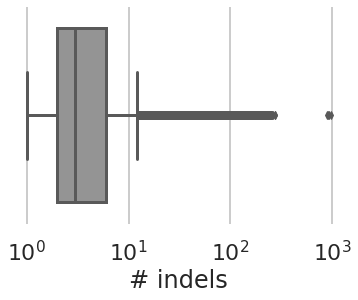

In [55]:
count_subclonal_indels_per_samples = subclonal_indels[["sample", "variant_id"]].groupby("sample").count().reset_index().rename(columns={'variant_id': 'count_indels'})
splot = sns.boxplot(count_subclonal_indels_per_samples.count_indels, color=grey)
splot.set(xscale="log", xlabel="# indels")
sns.despine(bottom=True, left=True)

In [56]:
print("Median number of indels per sample {}".format(count_subclonal_indels_per_samples.count_indels.quantile(0.5)))
iqr_count_subclonal_indels = count_subclonal_indels_per_samples.count_indels.quantile(0.75) - count_subclonal_indels_per_samples.count_indels.quantile(0.25)
print("IQR number of indels per sample {}".format(iqr_count_subclonal_indels))

Median number of indels per sample 3.0
IQR number of indels per sample 4.0


In [57]:
count_indels_threshold = count_subclonal_indels_per_samples.count_indels.quantile(0.5) + (3 * iqr_count_subclonal_indels)
excluded_samples_count_indels = count_subclonal_indels_per_samples[count_subclonal_indels_per_samples.count_indels > count_indels_threshold]["sample"].unique()
print("Filtering all samples with a count of indels greater than {}, {} samples and {} indels are filtered out".format(
    count_indels_threshold,
    excluded_samples_count_indels.shape[0],
    count_subclonal_indels_per_samples[count_subclonal_indels_per_samples.count_indels > count_indels_threshold].count_indels.sum()))

Filtering all samples with a count of indels greater than 15.0, 8482 samples and 543146 indels are filtered out


In [58]:
len(set(excluded_samples_count_indels).intersection(excluded_samples_count_snvs))

6901

In [59]:
excluded_samples_by_count_variants = set(excluded_samples_count_indels).union(excluded_samples_count_snvs)
print("Filtered {} indels after excluding all samples".format(
    count_subclonal_indels_per_samples[count_subclonal_indels_per_samples["sample"].isin(excluded_samples_by_count_variants)].count_indels.sum()))
print("Filtered {} SNVs after excluding all samples".format(
    count_subclonal_snvs_per_samples[count_subclonal_snvs_per_samples["sample"].isin(excluded_samples_by_count_variants)].count_snvs.sum()))

Filtered 558540 indels after excluding all samples
Filtered 863020 SNVs after excluding all samples


### Sample distribution and number of subclonal SNVs by technology

In [60]:
colors_library_strategy = {
    "RNA-Seq": blue,
    "Targeted-Capture": orange,
    "WGS": green,
    "WGA": grey
}

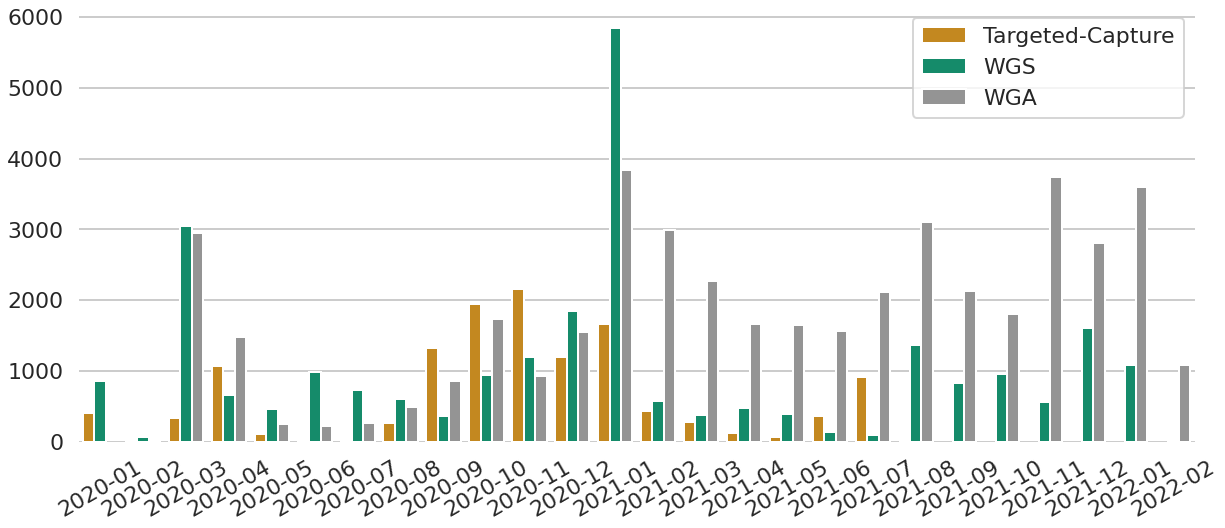

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
splot = sns.barplot(data=sample_ena[["library_strategy", "run_accession", "month"]].groupby(["month", "library_strategy"]).count().reset_index(), 
            y="run_accession", x="month", hue='library_strategy', palette=colors_library_strategy)
plt.xticks(rotation=30)
ax.legend(loc='upper right')
splot.set(xlabel=None, ylabel=None)
sns.despine(bottom=True, left=True)
fig.savefig(os.path.join(figure_output_folder, "figure_02_distribution_samples_through_time_by_technology.jpg"), dpi=200)

In [18]:
def plot_subclonal_per_sample(data, title=None, legend=False, sample_variable='library_strategy'):
    count_per_sample_and_library_strategy = data[["sample", "variant_id", sample_variable, "variant_type"]] \
    .groupby(["sample", sample_variable, "variant_type"]).count().reset_index().rename(columns={'variant_id': 'count'})
    count_per_sample_and_library_strategy.sort_values([sample_variable, "variant_type", 'sample'], inplace=True)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    splot = sns.boxplot(data=count_per_sample_and_library_strategy, x="count", y=sample_variable, hue="variant_type")
    splot.set(xscale="log", xlabel=None, ylabel=None, title=title) 
    ax.grid(axis='x', b=True, which='major', linestyle='--')
    ax.grid(axis='x', b=False, which='minor', linestyle=':')
    plt.tight_layout()
    sns.despine(bottom=True, left=True)
    if not legend:
        ax.get_legend().remove()
    return splot.figure

In [22]:
data = subclonal_snvs[["sample", "variant_id", "library_strategy"]] \
    .groupby(["sample", "library_strategy"]).count().reset_index().rename(columns={'variant_id': 'count_snvs'})
np.median(data[data.library_strategy == "Targeted-Capture"].count_snvs)

5.0

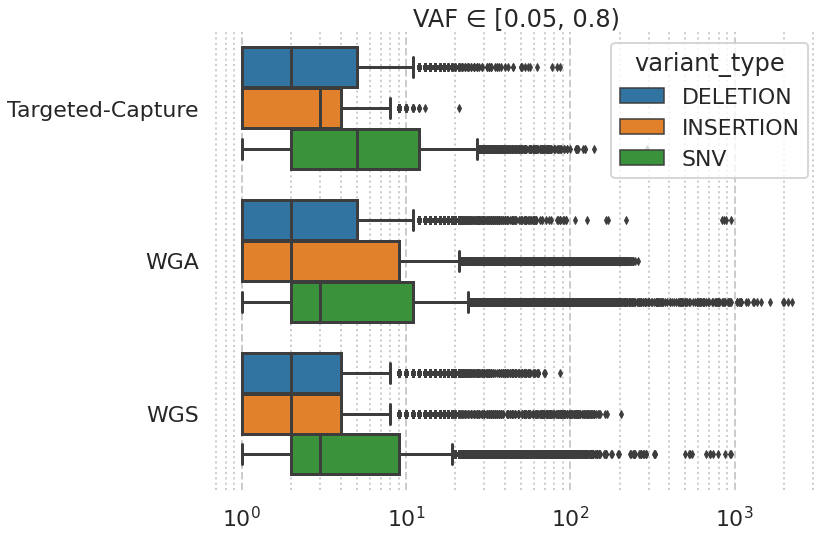

In [23]:
fig = plot_subclonal_per_sample(data=subclonal_variants, title='VAF ∈ [0.05, 0.8)', legend=True)
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_technology_vaf005.jpg"), dpi=200)

In [70]:
non_clonal_variants = pd.concat([subclonal_variants, low_frequency_variants])

In [71]:
non_clonal_variants.columns

Index(['sample', 'variant_id', 'chromosome', 'position', 'reference',
       'alternate', 'quality', 'filter', 'dp', 'ac', 'dp4_ref_forward',
       'dp4_ref_reverse', 'dp4_alt_forward', 'dp4_alt_reverse', 'vaf',
       'strand_bias', 'annotation', 'annotation_impact', 'biotype',
       'annotation_highest_impact', 'gene_name', 'hgvs_c', 'hgvs_p', 'date',
       'variant_type', 'length', 'reference_amino_acid',
       'alternate_amino_acid', 'position_amino_acid', 'cons_hmm_sars_cov_2',
       'cons_hmm_sarbecovirus', 'cons_hmm_vertebrate_cov', 'pfam_name',
       'pfam_description', 'vaf_bin'],
      dtype='object')

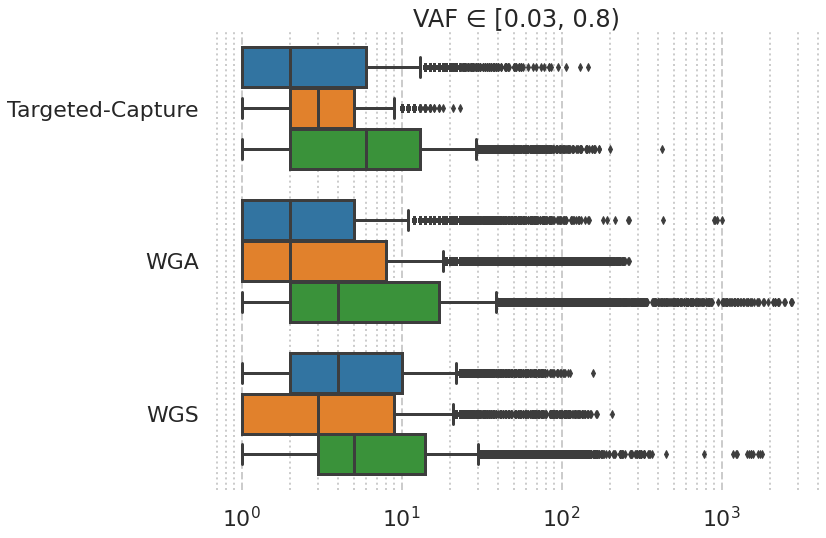

In [82]:
fig = plot_subclonal_per_sample(data=non_clonal_variants[non_clonal_variants.vaf >= 0.03], sample_data=sample_ena, title='VAF ∈ [0.03, 0.8)')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_technology_vaf003.jpg"), dpi=200)

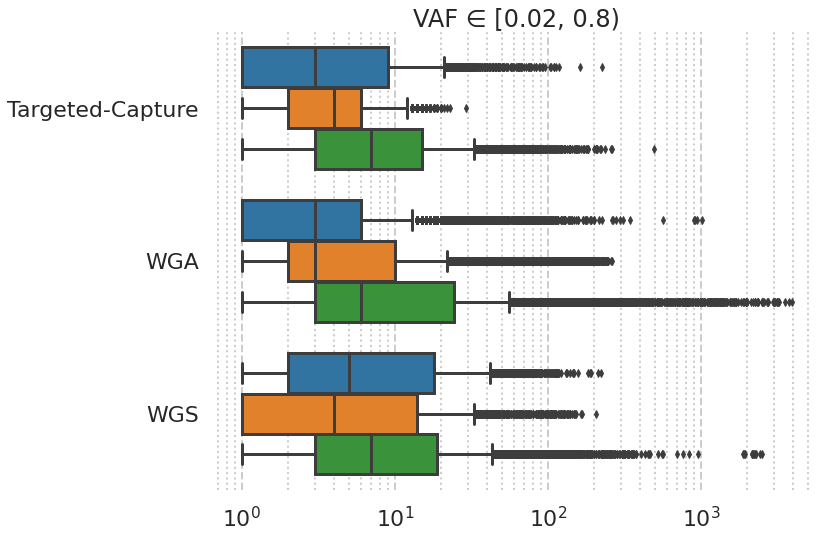

In [83]:
fig = plot_subclonal_per_sample(data=non_clonal_variants[non_clonal_variants.vaf >= 0.02], sample_data=sample_ena, title='VAF ∈ [0.02, 0.8)')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_technology_vaf002.jpg"), dpi=200)

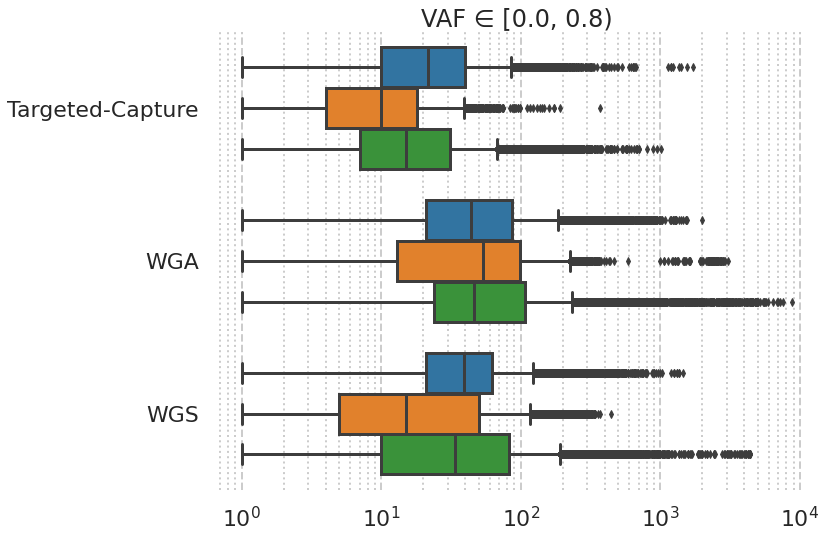

In [84]:
fig = plot_subclonal_per_sample(data=non_clonal_variants, sample_data=sample_ena, title='VAF ∈ [0.0, 0.8)')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_technology_vaf00.jpg"), dpi=200)

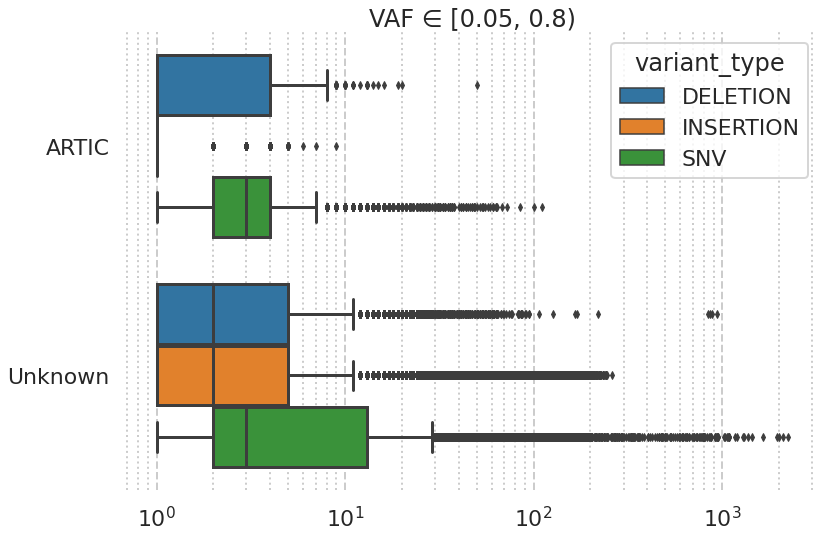

In [54]:
fig = plot_subclonal_per_sample(data=subclonal_variants, sample_data=sample_ena, title='VAF ∈ [0.05, 0.8)', legend=True, sample_variable='artic')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_artic_vaf005.jpg"), dpi=200)

In [56]:
sample_ena[['library_strategy', 'artic', 'run_accession']].groupby(['library_strategy', 'artic']).count().reset_index().sort_values('run_accession', ascending=False)

library_strategy    artic  run_accession
2               WGA  Unknown          34286
3               WGS  Unknown          26167
0  Targeted-Capture  Unknown          12756
1               WGA    ARTIC          10839

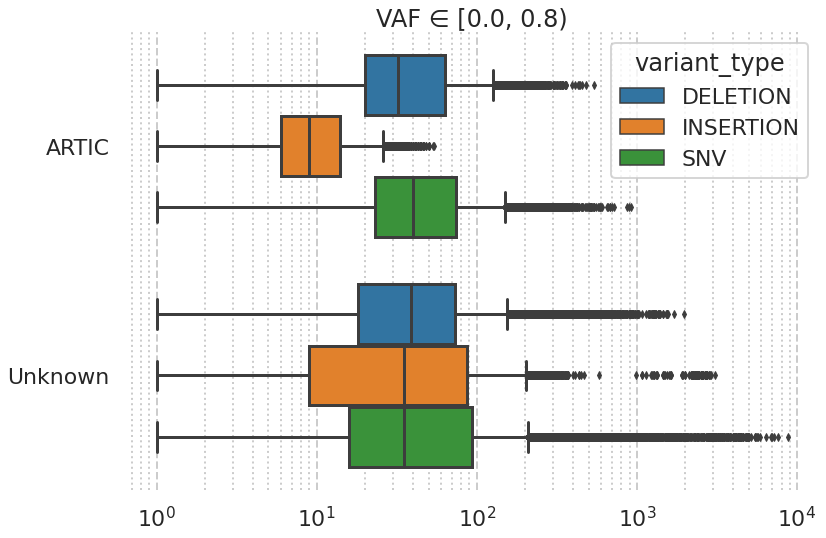

In [104]:
fig = plot_subclonal_per_sample(data=non_clonal_variants, sample_data=sample_ena, title='VAF ∈ [0.0, 0.8)', legend=True, sample_variable='artic')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_per_sample_by_artic_vaf00.jpg"), dpi=200)

In [97]:
'ARTIC' in "Nextera Flex"

False

In [92]:
sample_ena[['run_accession', 'library_name']].groupby('library_name').count().reset_index().sort_values('run_accession', ascending=False).head(50)

library_name  run_accession
10604                         Nextera Flex           8392
6169          Illumina COVIDSeq (ARTIC v3)           6929
5280       CleanPlex SARS-CoV-2 FLEX Panel           3938
6170          Illumina COVIDSeq (ARTIC v4)           2954
5279                  CleanPlex SARS-CoV-2            578
6168                     Illumina COVIDSeq            412
1081   ARCTIC v4-1 / Illumina DNA Prep (M)            371
10606                Nextera XT (ARTIC V4)            355
10607              Nextera XT (ARTIC V4.1)            230
10605                           Nextera XT             99
5281            CleanPlex SARS-CoV-2 Panel             26
16736                          unspecified              4
5368                            FD15540740              3
5345                            FD15540690              3
5342                            FD15540588              3
5432                            FD17059314              2
5435                            FD17059317              2
639                                      3              2
196                                     16              2
5431                            FD17059313              2
5729                            FD18231586              2
56                                       1              2
57                                      10              2
5362                            FD15540730              2
5437                            FD17059319              2
5436                            FD17059318              2
964                                      8              2
5454                            FD17059338              2
5455                            FD17059339              2
5450                            FD17059333              2
5341                            FD15539334              2
5449                            FD17059332              2
986                                      9              2
5445                            FD17059328              2
5444                            FD17059327              2
5562                            FD18160923              2
104                                     12              2
72                                      11              2
234                                     18              2
5442                            FD17059325              2
870                                      5              2
5440                            FD17059322              2
5439                            FD17059321              2
5337                            FD15518313              2
469                                  22444              2
317                                     20              2
813                                      4              2
5425                            FD17059307              2
5283                            FD15381415              2
5426                            FD17059308              2

In [32]:
# excludes samples effectively
excluded_samples = sample_ena[(sample_ena.run_accession.isin(excluded_samples_by_count_variants)) | (sample_ena.library_strategy == "RNA-Seq")].run_accession.unique()
sample_ena_filtered_samples = sample_ena[~sample_ena.run_accession.isin(excluded_samples)]
subclonal_snvs_filtered_samples = subclonal_snvs[~subclonal_snvs["sample"].isin(excluded_samples)]
subclonal_indels_filtered_samples = subclonal_indels[~subclonal_indels["sample"].isin(excluded_samples)]
print("Total excluded samples: {}".format(excluded_samples.shape[0]))

Total excluded samples: 10646


### Filter out low quality SNVs

* Filter out SNVs with too high coverage at the position. The distribution of DP has a long tail on the higher end, thus we filter out anything above the 99th percentile.
* The quality reported by LoFreq is not a Phred score. We filter out variant calls with quality less than or equal to 50.
* We filter variant calls with a strand bias score (ie: the lower the better) greater than 100.
* The number of supporting reads is calculated using the VAF and the DP. All variant calls with less than 10 supporting reads are filtered out.
* Finally, we filter all variant calls with a VAF lower than 0.01

The above rules allows us to filter down to **18.23 % of unique subclonal variants** and to **1.05 % of subclonal variant calls**. This represents **17.46 % of all possible SARS-CoV-2 mutations**.

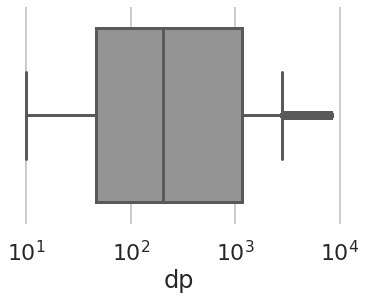

In [33]:
splot = sns.boxplot(subclonal_snvs_filtered_samples.dp, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_dp_boxplot.jpg"), dpi=200)

In [34]:
subclonal_snvs_filtered_samples.dp.quantile(0.99)

4756.0

In [35]:
DP_UPPER_THRESHOLD = subclonal_snvs_filtered_samples.dp.quantile(0.99)
print("Filtering all variants on positions with DP > {} removes {} variants".format(DP_UPPER_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.dp > DP_UPPER_THRESHOLD].shape[0]))

Filtering all variants on positions with DP > 4756.0 removes 2715 variants


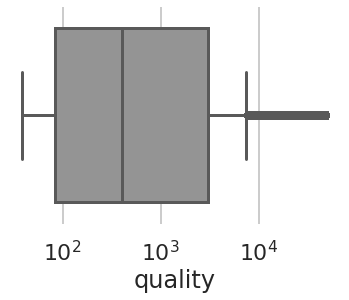

In [36]:
splot = sns.boxplot(subclonal_snvs_filtered_samples.quality, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_quality_boxplot.jpg"), dpi=200)

In [37]:
QUALITY_THRESHOLD = 50 #subclonal_snvs.quality.quantile(0.01)
print("Filtering all variants on positions with quality <= {} removes {} variants".format(QUALITY_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.quality <= QUALITY_THRESHOLD].shape[0]))

Filtering all variants on positions with quality <= 50 removes 11788 variants


In [38]:
print("There are {} extreme values for strand bias".format(subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.strand_bias > 1000000].shape[0]))

There are 167 extreme values for strand bias


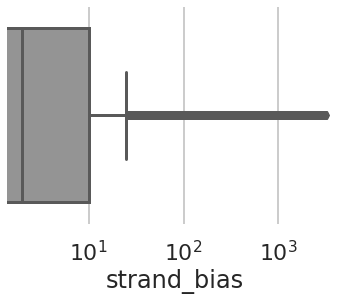

In [39]:
splot = sns.boxplot(subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.strand_bias < 1000000].strand_bias, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_strand_bias_boxplot.jpg"), dpi=200)

In [40]:
STRAND_BIAS_THRESHOLD = 100
print("Filtering all variants on positions with strand bias > {} removes {} variants".format(
    STRAND_BIAS_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.strand_bias > STRAND_BIAS_THRESHOLD].shape[0]))

Filtering all variants on positions with strand bias > 100 removes 18846 variants


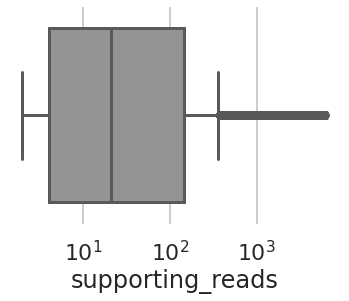

In [41]:
subclonal_snvs_filtered_samples["supporting_reads"] = subclonal_snvs_filtered_samples.vaf * subclonal_snvs_filtered_samples.dp
splot = sns.boxplot(subclonal_snvs_filtered_samples.supporting_reads, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_supporting_reads_boxplot.jpg"), dpi=200)

In [42]:
SUPPORTING_READS_THRESHOLD = 3
print("Filtering all variants on positions with supporting_reads < {} removes {} variants".format(
    SUPPORTING_READS_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.supporting_reads < SUPPORTING_READS_THRESHOLD].shape[0]))

Filtering all variants on positions with supporting_reads < 3 removes 40040 variants


In [43]:
MINIMUM_VAF_THRESHOLD = 0.001
print("Filtering all variants with VAF < {} removes {} variants".format(MINIMUM_VAF_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.vaf < MINIMUM_VAF_THRESHOLD].shape[0]))

Filtering all variants with VAF < 0.001 removes 0 variants


In [44]:
def filter_out_variants(data, dp_upper_threshold=DP_UPPER_THRESHOLD, quality_threshold=QUALITY_THRESHOLD, strand_bias_threshold=STRAND_BIAS_THRESHOLD,
                       supporting_reads_threshold=SUPPORTING_READS_THRESHOLD, minimum_vaf_threshold=MINIMUM_VAF_THRESHOLD):
    data_filtered_variants = data[
        (data.dp <= dp_upper_threshold) &
        (data.quality > quality_threshold) &
        (data.strand_bias <= strand_bias_threshold) &
        (data.supporting_reads >= supporting_reads_threshold) &
        (data.vaf >= minimum_vaf_threshold)
    ]
    print("Filtered subclonal SNV calls {}".format(data.shape[0] - data_filtered_variants.shape[0]))
    print("Subclonal SNV calls after filtering {}".format(data_filtered_variants.shape[0]))
    count_unique_after_filtering = data_filtered_variants.variant_id.unique().shape[0]
    print("Subclonal unique SNVs after filtering {} ({} % of all possible mutations)".format(count_unique_after_filtering, round(count_unique_after_filtering / (SARS_COV_2_GENOME_LENGTH * 3) * 100, 3)))
    return data_filtered_variants

In [45]:
subclonal_snvs_filtered_vaf0_sr0 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.0, supporting_reads_threshold=0)

Filtered subclonal SNV calls 33078
Subclonal SNV calls after filtering 238429
Subclonal unique SNVs after filtering 49375 (55.039 % of all possible mutations)


In [46]:
subclonal_snvs_filtered_vaf001 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.01)

Filtered subclonal SNV calls 61544
Subclonal SNV calls after filtering 209963
Subclonal unique SNVs after filtering 43318 (48.287 % of all possible mutations)


In [47]:
subclonal_snvs_filtered_vaf002 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.02)

Filtered subclonal SNV calls 61544
Subclonal SNV calls after filtering 209963
Subclonal unique SNVs after filtering 43318 (48.287 % of all possible mutations)


In [48]:
subclonal_snvs_filtered_vaf003 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.03)

Filtered subclonal SNV calls 61544
Subclonal SNV calls after filtering 209963
Subclonal unique SNVs after filtering 43318 (48.287 % of all possible mutations)


In [49]:
subclonal_snvs_filtered_vaf005 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.05)

Filtered subclonal SNV calls 61544
Subclonal SNV calls after filtering 209963
Subclonal unique SNVs after filtering 43318 (48.287 % of all possible mutations)


In [50]:
subclonal_snvs_filtered_vaf01 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.1)

Filtered subclonal SNV calls 172011
Subclonal SNV calls after filtering 99496
Subclonal unique SNVs after filtering 27454 (30.603 % of all possible mutations)


In [51]:
subclonal_snvs_filtered_vaf02 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.2)

Filtered subclonal SNV calls 219506
Subclonal SNV calls after filtering 52001
Subclonal unique SNVs after filtering 16453 (18.34 % of all possible mutations)


In [52]:
subclonal_snvs_filtered_vaf03 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.3)

Filtered subclonal SNV calls 236661
Subclonal SNV calls after filtering 34846
Subclonal unique SNVs after filtering 11320 (12.619 % of all possible mutations)


In [53]:
subclonal_snvs_filtered_samples["sample"].unique().shape

(58565,)

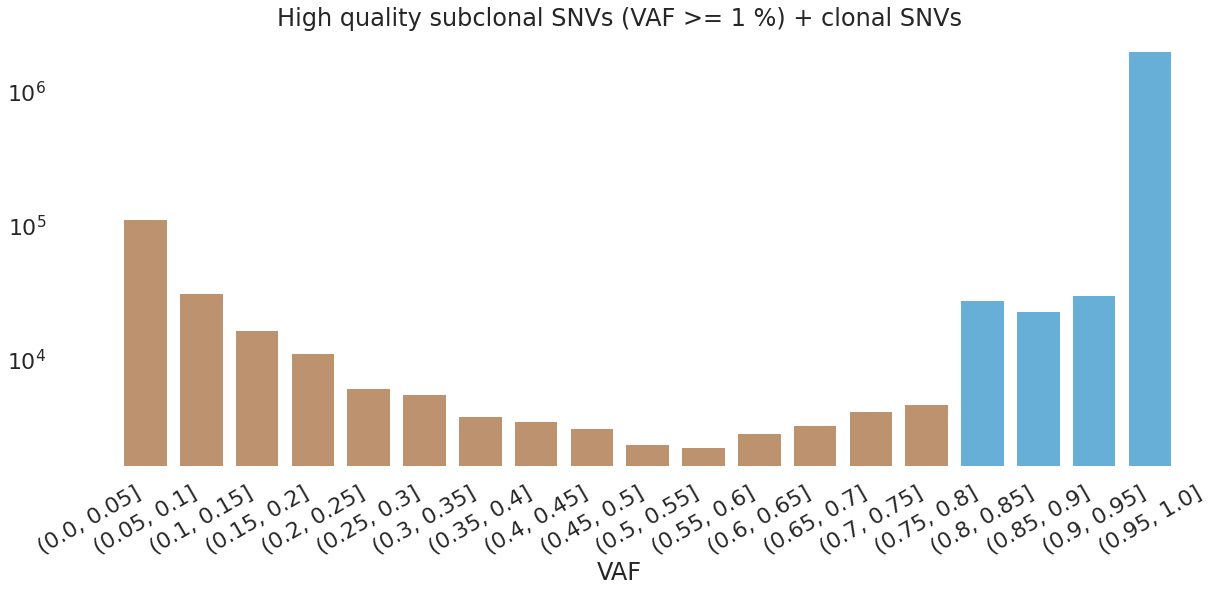

In [54]:
fig = plot_vaf(clonal_data=clonal_snvs, subclonal_data=subclonal_snvs_filtered_vaf001, title="High quality subclonal SNVs (VAF >= 1 %) + clonal SNVs")


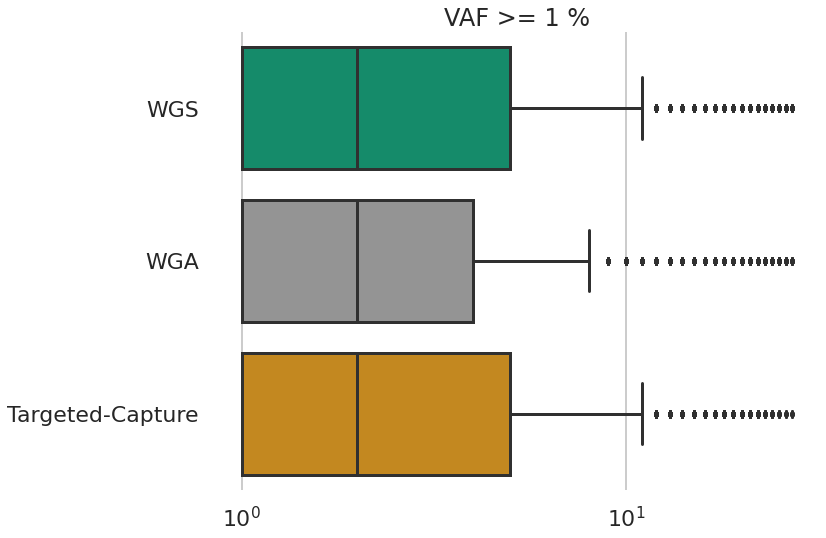

In [55]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf001, sample_data=sample_ena_filtered_samples, title="VAF >= 1 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_1.jpg"), dpi=200)

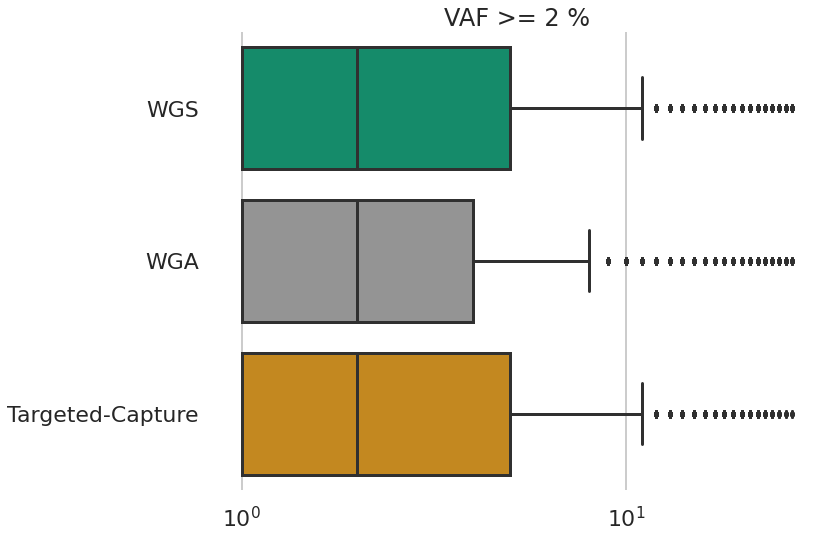

In [56]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf002, sample_data=sample_ena_filtered_samples, title="VAF >= 2 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_2.jpg"), dpi=200)

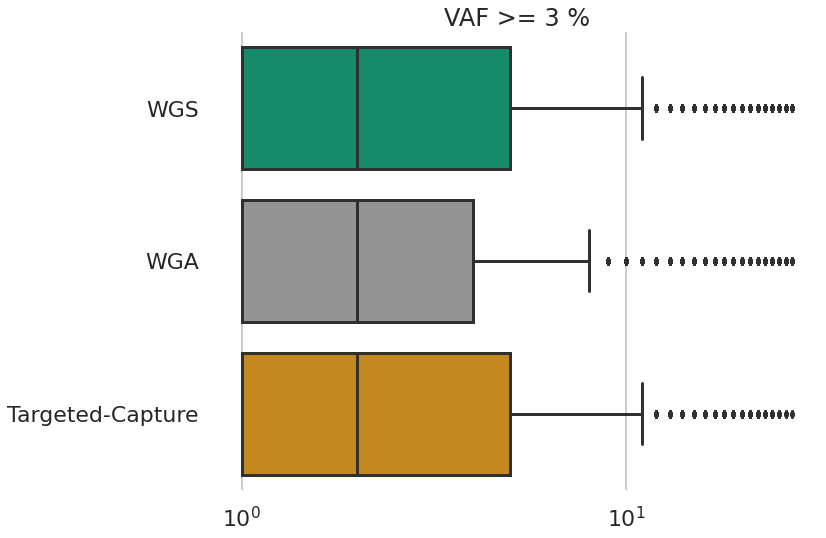

In [57]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf003, sample_data=sample_ena_filtered_samples, title="VAF >= 3 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_3.jpg"), dpi=200)

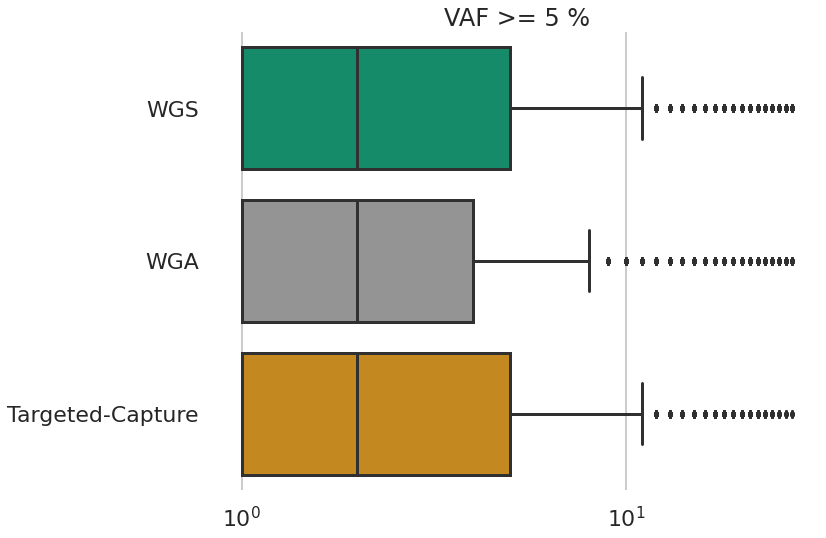

In [58]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf005, sample_data=sample_ena_filtered_samples, title="VAF >= 5 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_5.jpg"), dpi=200)

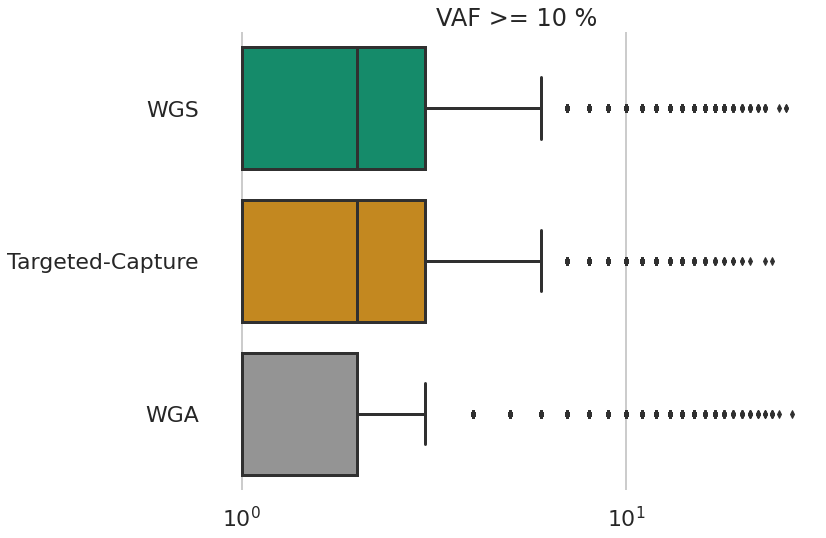

In [59]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf01, sample_data=sample_ena_filtered_samples, title="VAF >= 10 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_10.jpg"), dpi=200)

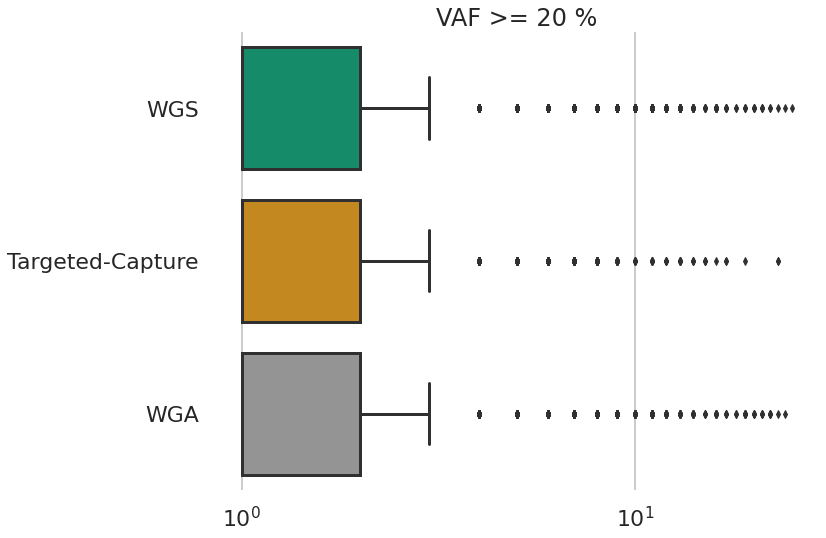

In [60]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf02, sample_data=sample_ena_filtered_samples, title="VAF >= 20 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_20.jpg"), dpi=200)

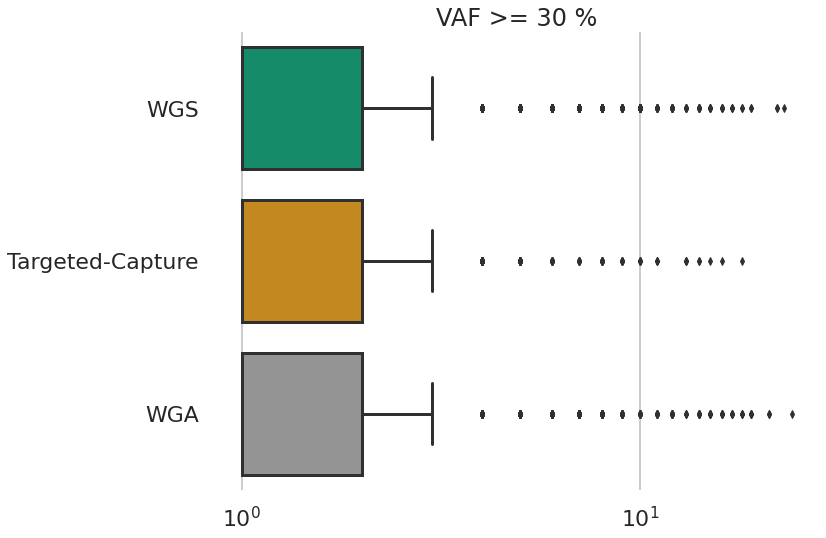

In [61]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf03, sample_data=sample_ena_filtered_samples, title="VAF >= 30 %")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_30.jpg"), dpi=200)

### Recurrent subclonal variants

In [62]:
def filter_out_non_recurrent_variants(data, recurrence_threshold=2):
    counts = data[["variant_id", "sample"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count"})
    non_recurrent_variant_ids = counts[counts["count"] < recurrence_threshold].variant_id
    data_filtered = data[~data.variant_id.isin(non_recurrent_variant_ids)]
    print("Filtered out {} unique variants and {} variant calls".format(non_recurrent_variant_ids.shape[0], data.shape[0] - data_filtered.shape[0]))
    return data_filtered

In [63]:
subclonal_snvs_filtered_samples_recurrence2 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf0_sr0)

Filtered out 19883 unique variants and 19883 variant calls


In [64]:
subclonal_snvs_filtered_samples_recurrence3 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf0_sr0, recurrence_threshold=3)

Filtered out 30231 unique variants and 40579 variant calls


In [65]:
subclonal_snvs_filtered_samples_recurrence4 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf0_sr0, recurrence_threshold=4)

Filtered out 36371 unique variants and 58999 variant calls


In [66]:
subclonal_snvs_filtered_samples_vaf001_sr3_recurrence2 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf001)

Filtered out 19148 unique variants and 19148 variant calls


In [67]:
subclonal_snvs_filtered_samples_vaf01_sr3_recurrence2 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf01)

Filtered out 15542 unique variants and 15542 variant calls


## Variant allele frequency distribution through time

1,132 samples were excluded due to a missing collection date.

In [68]:
count_subclonal_variants_per_sample = subclonal_snvs_filtered_vaf002[["sample", "variant_id"]].groupby("sample").count().reset_index()
count_subclonal_variants_per_sample.head()

sample  variant_id
0  DRR287659           1
1  DRR287662           2
2  DRR287663           1
3  DRR287665           4
4  DRR287666           3

In [69]:
samples_with_counts = pd.merge(left=sample_ena_filtered_samples[["run_accession", "month"]], right=count_subclonal_variants_per_sample, left_on="run_accession", right_on="sample", how="inner")
samples_with_counts.head()

run_accession    month       sample  variant_id
0    ERR5983522  2020-10   ERR5983522           1
1    ERR8960173  2022-01   ERR8960173           2
2    ERR8508786  2021-11   ERR8508786           1
3   SRR14119834  2020-04  SRR14119834           3
4    ERR8959977  2022-01   ERR8959977           7

In [70]:
samples_with_counts.shape

(53592, 4)

In [71]:
subclonal_variant_with_month = pd.merge(left=subclonal_snvs_filtered_vaf002[["sample", "vaf"]], right=sample_ena_filtered_samples[["run_accession", "month"]], right_on="run_accession", left_on="sample", how="inner")

In [72]:
sample_counts_per_month = samples_with_counts[["month", "sample"]].groupby("month").count().reset_index()
sample_counts_per_month.head()

month  sample
0  2020-01     765
1  2020-02      74
2  2020-03    3992
3  2020-04    2134
4  2020-05     465

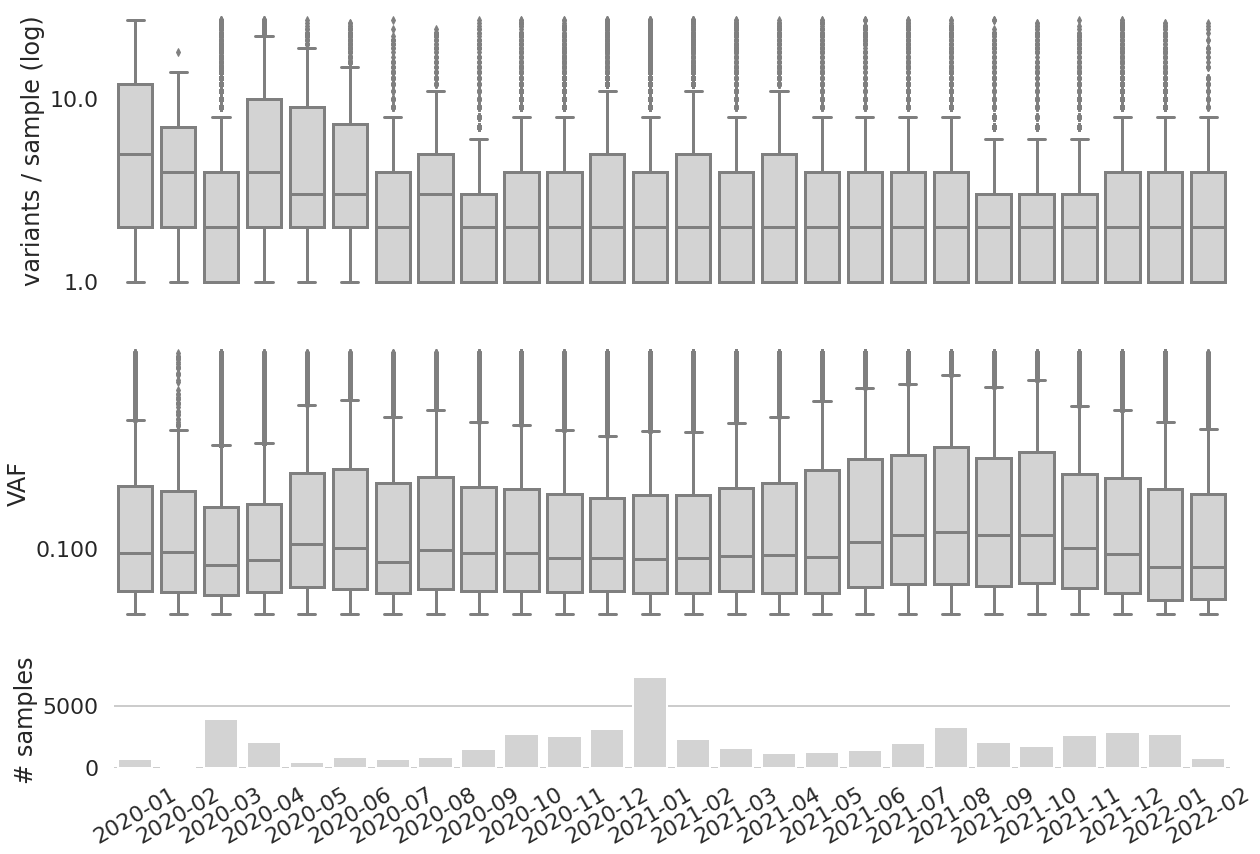

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20, 14), gridspec_kw={'height_ratios': [3, 3, 1]})
sns.boxplot(data=samples_with_counts.sort_values("month"), y="variant_id", x="month", ax=ax1, color='lightgrey')
sns.boxplot(data=subclonal_variant_with_month.sort_values("month"), y="vaf", x="month", ax=ax2, color='lightgrey')
sns.barplot(data=sample_counts_per_month, y="sample", x="month", ax=ax3, color='lightgrey')
ax1.set_ylabel("variants / sample (log)")
ax2.set_ylabel("VAF")
ax3.set_ylabel("# samples")
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax3.set_xlabel(None)
plt.xticks(rotation=30)
sns.despine(bottom=True, left=True)
ax1.grid(axis='y')
ax2.grid(axis='y')
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.ticklabel_format(style='plain', axis='y')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain', axis='y')
fig.savefig(os.path.join(figure_output_folder, "figure_05_subclonal_variant_allele_frequencies_evolution.jpg"), dpi=200)

## Population allele frequency of subclonal and clonal variants through time

In [74]:
all_variants = pd.concat([clonal_variants.loc[:, ["sample", "variant_id"]], subclonal_snvs_filtered_vaf002.loc[:, ["sample", "variant_id"]]])
all_variants = pd.merge(left=all_variants, right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
all_variants.head()

sample variant_id run_accession    month
0  ERR5063089    445:T>C    ERR5063089  2020-10
1  ERR5063089   6286:C>T    ERR5063089  2020-10
2  ERR5063089  11396:C>T    ERR5063089  2020-10
3  ERR5063089  21255:G>C    ERR5063089  2020-10
4  ERR5063089  21614:C>T    ERR5063089  2020-10

In [75]:
sample_counts_per_month["sample_cumsum"] = sample_counts_per_month.sort_values("month")["sample"].cumsum()
sample_counts_per_month.head()

month  sample  sample_cumsum
0  2020-01     765            765
1  2020-02      74            839
2  2020-03    3992           4831
3  2020-04    2134           6965
4  2020-05     465           7430

In [76]:
def plot_allele_frequencies_through_time(data, sample_counts_per_month, title):
    count_samples = data["sample"].unique().shape[0]
    count_variant_recurrence_per_month = data[["month", "sample", "variant_id"]].groupby(["month", "variant_id"]).count().reset_index()
    count_variant_recurrence_per_month.sort_values("month", inplace=True)
    count_variant_recurrence_per_month.rename(columns={"sample": "count"}, inplace=True)
    count_variant_recurrence_per_month["cumsum"] = count_variant_recurrence_per_month.groupby("variant_id")['count'].cumsum()
    count_variant_recurrence_per_month_with_sample_counts = pd.merge(left=count_variant_recurrence_per_month, right=sample_counts_per_month, on="month")
    count_variant_recurrence_per_month_with_sample_counts["af"] = count_variant_recurrence_per_month_with_sample_counts["cumsum"] / count_variant_recurrence_per_month_with_sample_counts["sample_cumsum"]
    count_variant_recurrence_per_month_with_sample_counts["af_intramonth"] = count_variant_recurrence_per_month_with_sample_counts["count"] / count_variant_recurrence_per_month_with_sample_counts["sample"]
    
    # plot
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(20, 14), gridspec_kw={'height_ratios': [3, 3]})
    sns.boxplot(data=count_variant_recurrence_per_month_with_sample_counts, x="month", y="af", ax=ax1, color="lightgrey")
    sns.boxplot(data=count_variant_recurrence_per_month_with_sample_counts, x="month", y="af_intramonth", ax=ax2, color="lightgrey")
    ax1.set_ylabel("accumulated allele frequency")
    ax2.set_ylabel("intra month allele frequency")
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_xlabel(None)
    ax2.set_xlabel(None)
    plt.xticks(rotation=30)
    sns.despine(bottom=True, left=True)
    ax1.grid(axis='y')
    ax2.grid(axis='y')
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.ticklabel_format(style='plain', axis='y')
    ax2.yaxis.set_major_formatter(ScalarFormatter())
    ax2.ticklabel_format(style='plain', axis='y')
    ax1.set_title(title)
    fig.savefig(os.path.join(figure_output_folder, "figure_05_population_allele_frequencies_evolution_{}.jpg".format(title.lower().replace(" ", "_"))), dpi=200)

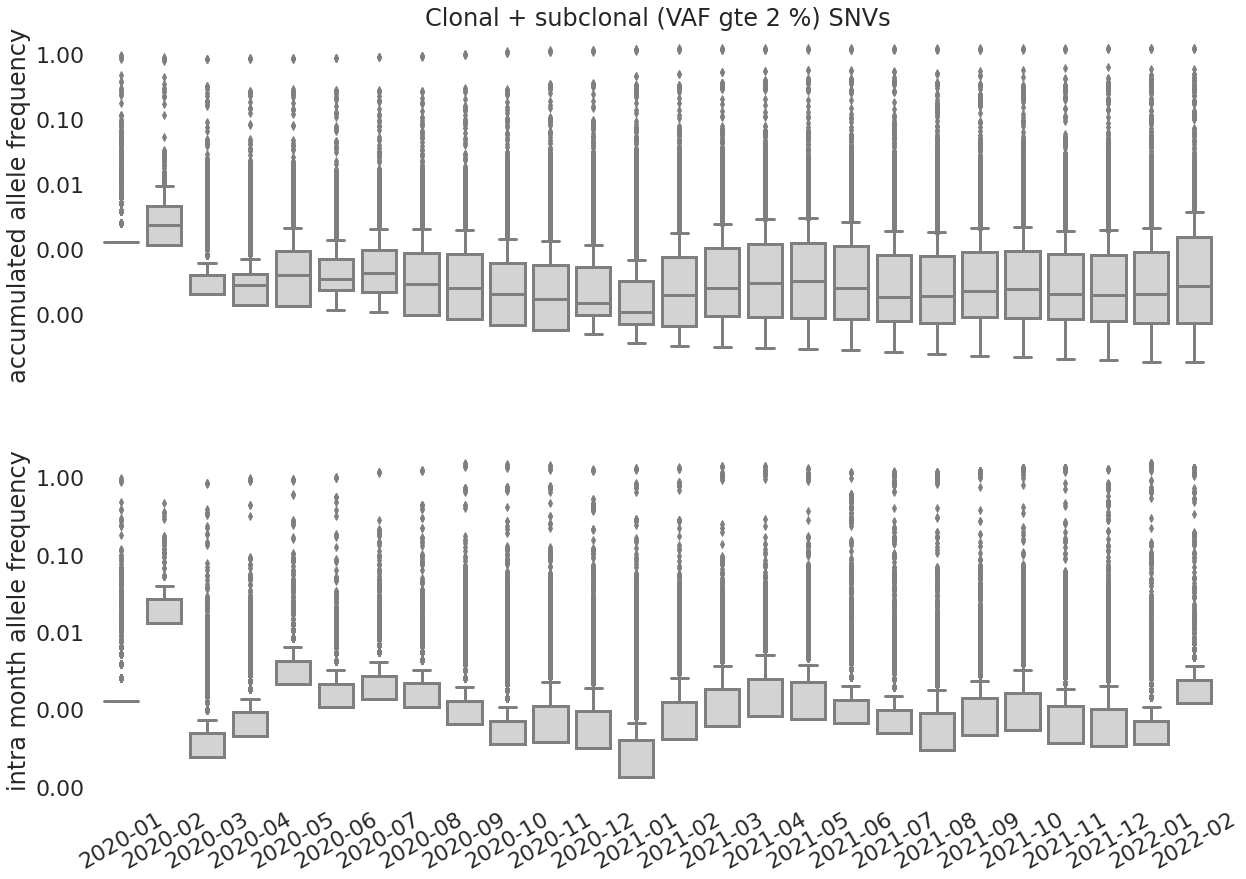

In [77]:
plot_allele_frequencies_through_time(data=all_variants, sample_counts_per_month=sample_counts_per_month, title="Clonal + subclonal (VAF gte 2 %) SNVs")

In [78]:
clonal_variants_with_month = pd.merge(left=clonal_snvs.loc[:, ["sample", "variant_id"]], 
                                      right=sample_ena_filtered_samples[["run_accession", "month"]], 
                                      left_on="sample", 
                                      right_on="run_accession", 
                                      how="inner")

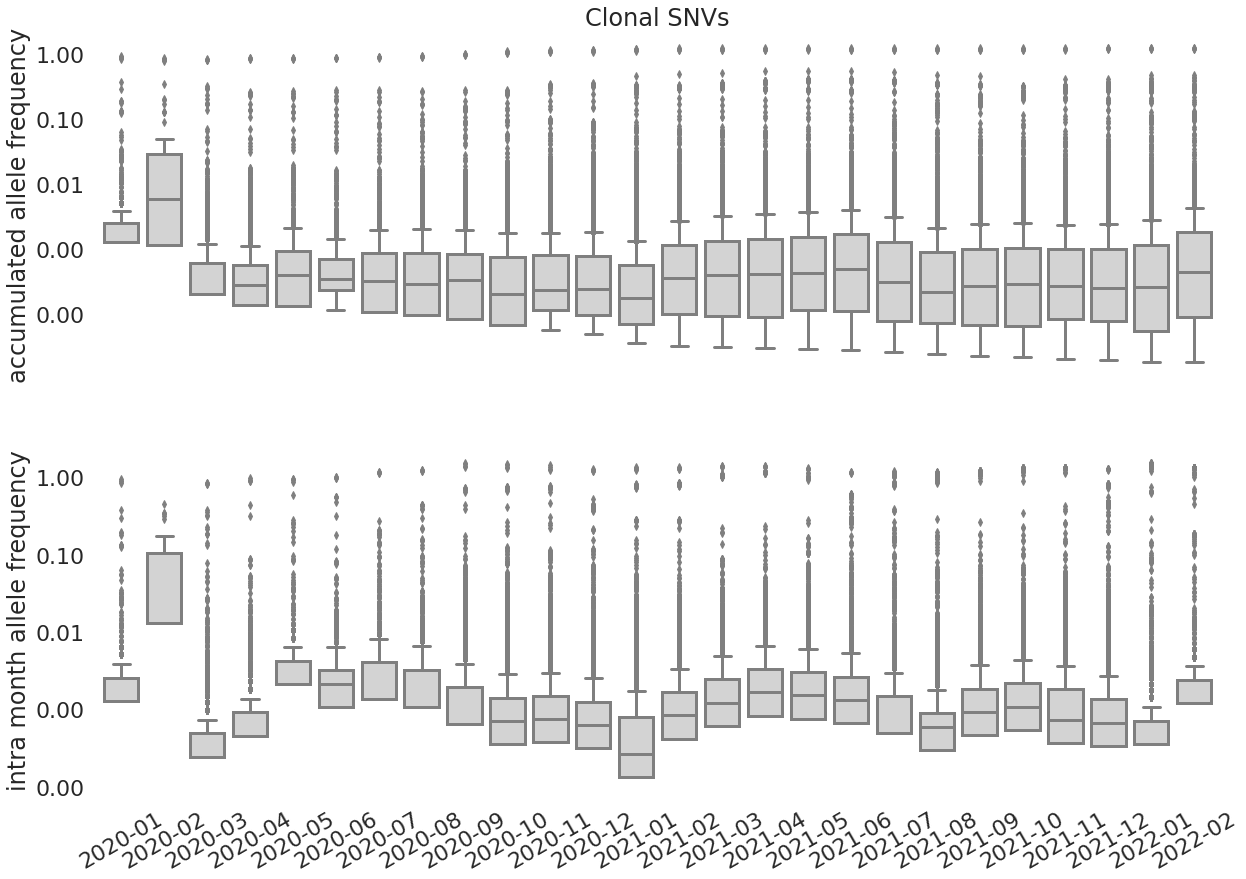

In [79]:
plot_allele_frequencies_through_time(data=clonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Clonal SNVs")

In [80]:
subclonal_variants_with_month = pd.merge(left=subclonal_snvs_filtered_vaf002.loc[:, ["sample", "variant_id"]], 
                                         right=sample_ena_filtered_samples[["run_accession", "month"]], 
                                         left_on="sample", 
                                         right_on="run_accession", 
                                         how="inner")

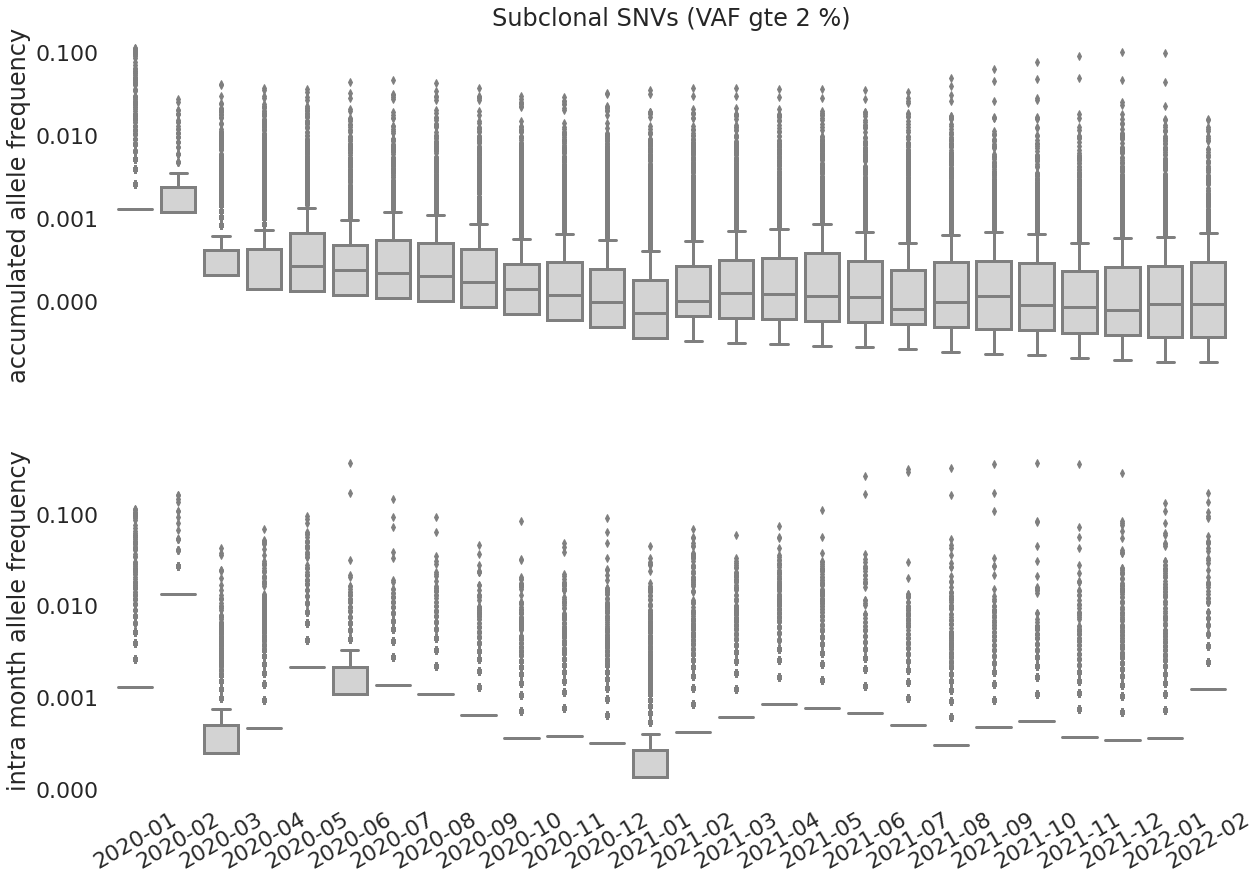

In [81]:
plot_allele_frequencies_through_time(data=subclonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Subclonal SNVs (VAF gte 2 %)")

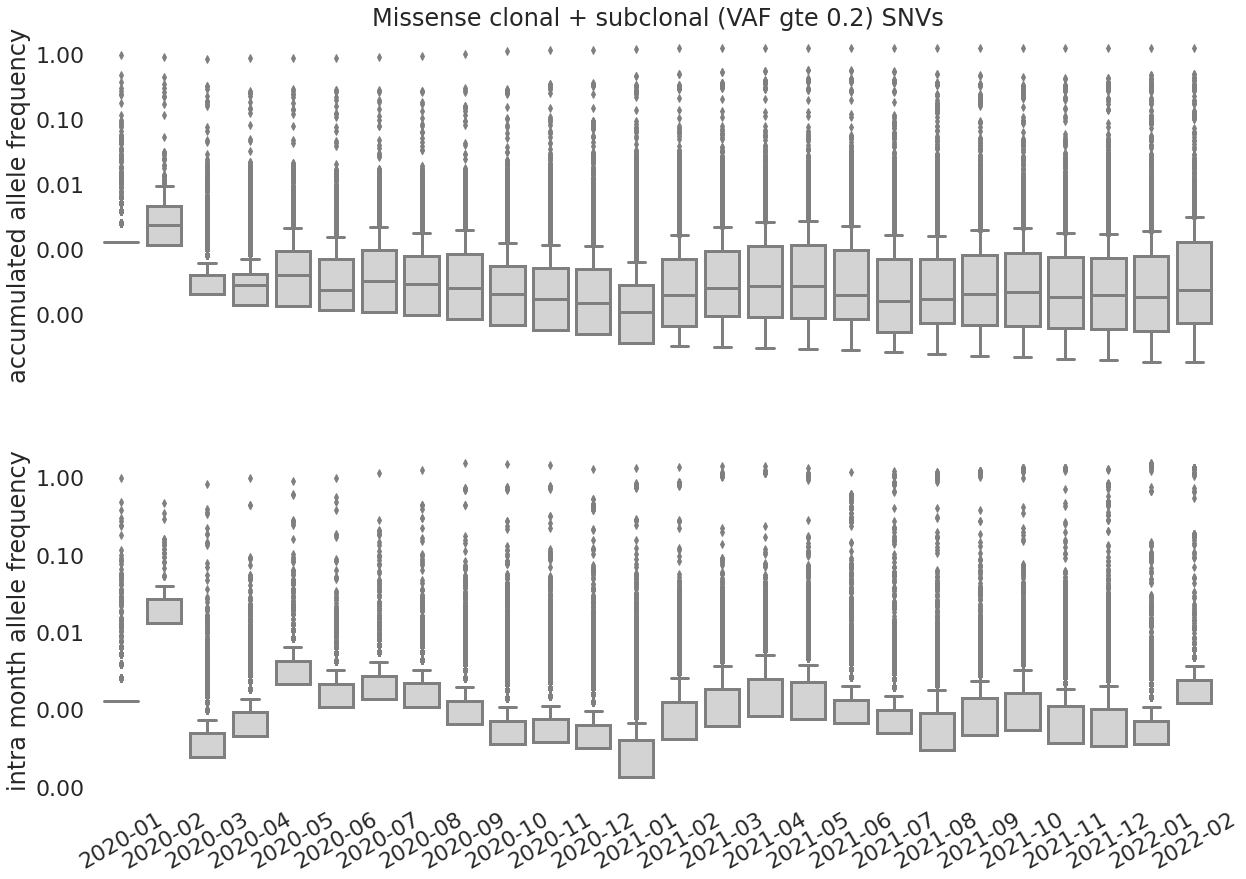

In [82]:
ns_all_variants_with_month = pd.merge(
    left=pd.concat([subclonal_snvs_filtered_vaf002.loc[subclonal_snvs_filtered_vaf002["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]], 
                    clonal_variants.loc[clonal_variants["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]]]),
    right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
plot_allele_frequencies_through_time(data=ns_all_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Missense clonal + subclonal (VAF gte 0.2) SNVs")

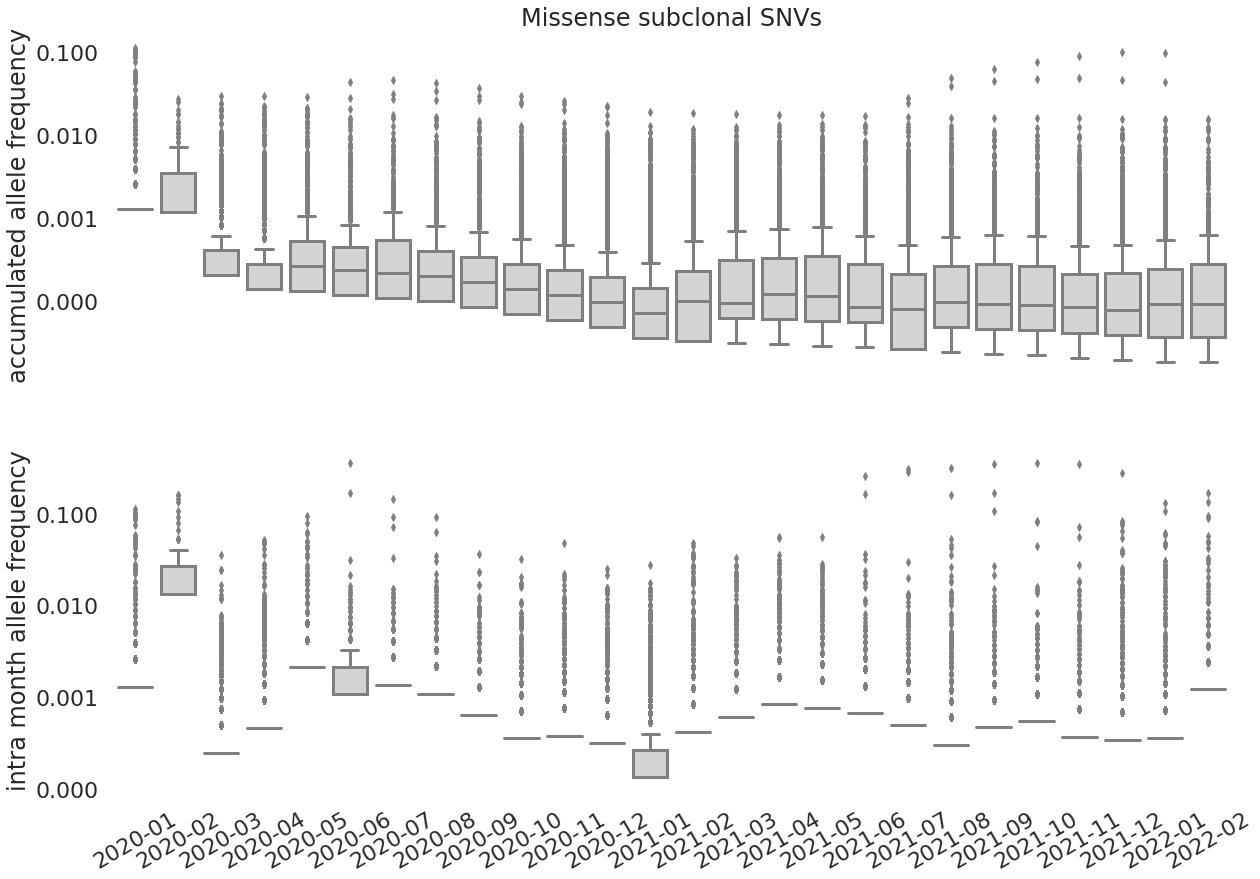

In [83]:
ns_subclonal_variants_with_month = pd.merge(
    left=subclonal_snvs_filtered_vaf002.loc[subclonal_snvs_filtered_vaf002["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]], 
    right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
plot_allele_frequencies_through_time(data=ns_subclonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Missense subclonal SNVs")

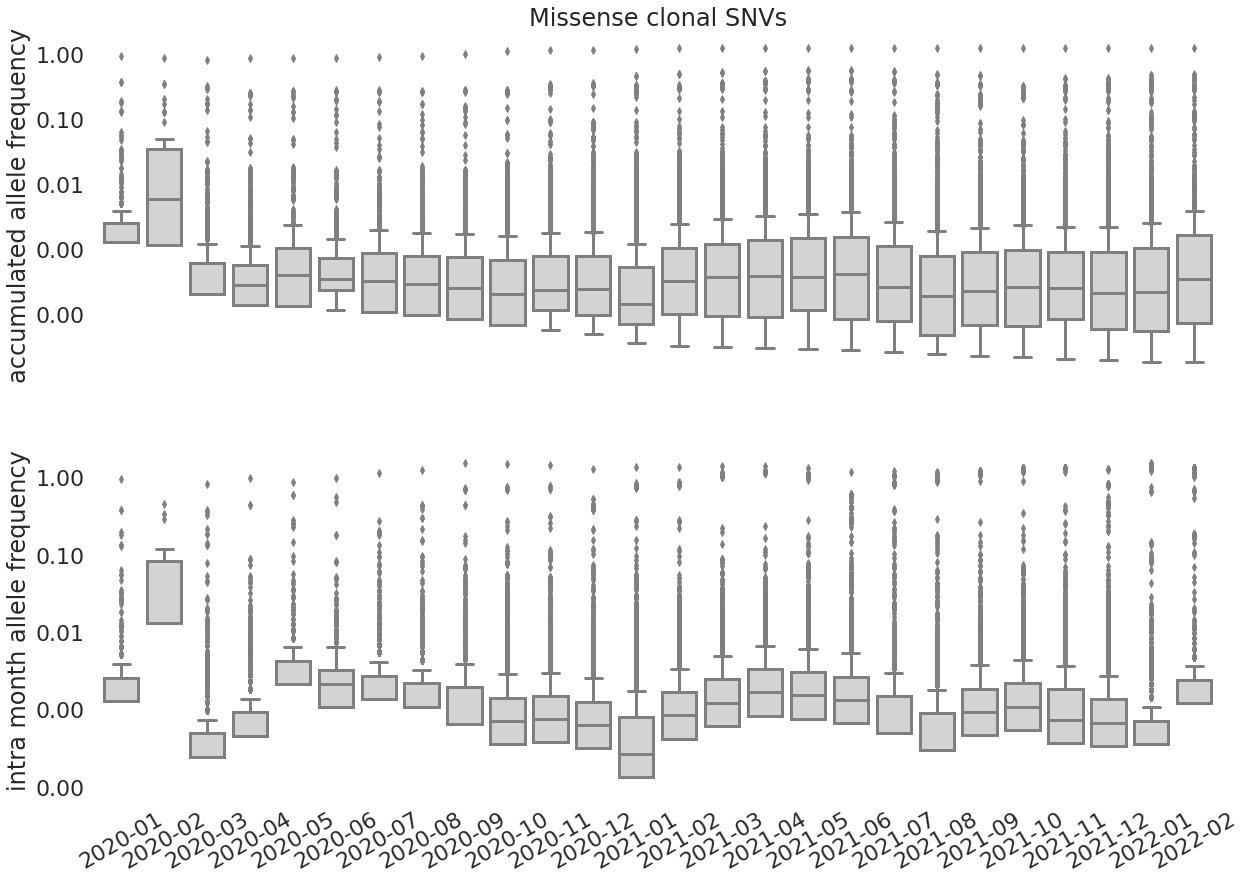

In [84]:
ns_clonal_variants_with_month = pd.merge(
    left=clonal_variants.loc[clonal_variants["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]], 
    right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
plot_allele_frequencies_through_time(data=ns_clonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Missense clonal SNVs")

## Correlations between clonal and subclonal

In [85]:
def plot_correlation(sample_data, clonal_data, subclonal_data, title=None):
    
    included_samples = sample_data.run_accession.unique()
    frequencies_clonal_snvs = clonal_data[clonal_data["sample"].isin(included_samples)][["variant_id", "sample"]].groupby("variant_id").count().reset_index()
    frequencies_clonal_snvs["af"] = frequencies_clonal_snvs["sample"] / included_samples.shape[0]
    frequencies_subclonal_snvs = subclonal_data[subclonal_data["sample"].isin(included_samples)][["variant_id", "sample"]].groupby("variant_id").count().reset_index()
    frequencies_subclonal_snvs["af"] = frequencies_subclonal_snvs["sample"] / included_samples.shape[0]
    frequencies_snvs = pd.merge(left=frequencies_clonal_snvs[["variant_id", "af"]], right=frequencies_subclonal_snvs[["variant_id", "af"]], on="variant_id", suffixes=("_clonal", "_subclonal"))
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    sns.regplot(data=frequencies_snvs, x="af_clonal", y="af_subclonal")
    plt.xticks(rotation=30)
    sns.despine(bottom=True, left=True)
    ax.set_xlabel("Clonal abundance")
    ax.set_ylabel("Subclonal abundance")
    plt.title("{} Pearson corr={}".format(title, round(frequencies_snvs.corr().af_subclonal[0], 3)))
    return fig

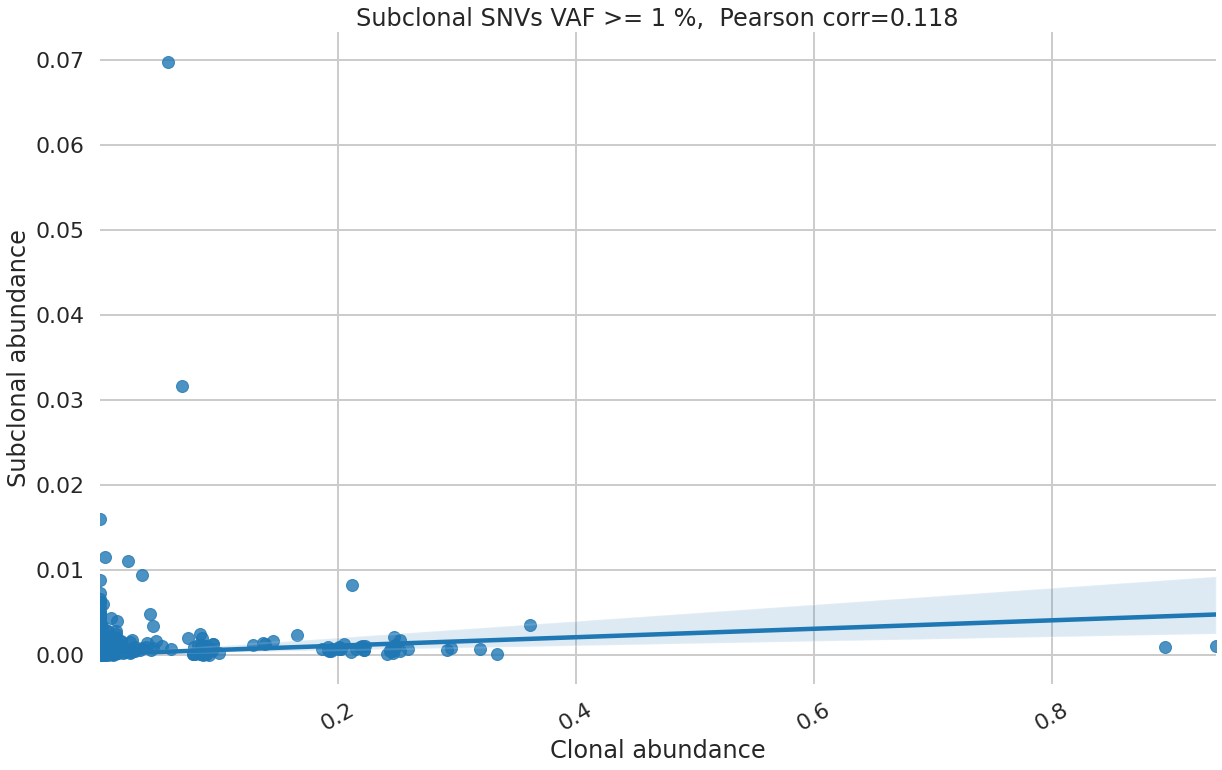

In [86]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf001), 
                 title="Subclonal SNVs VAF >= 1 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_1.png"), dpi=200)

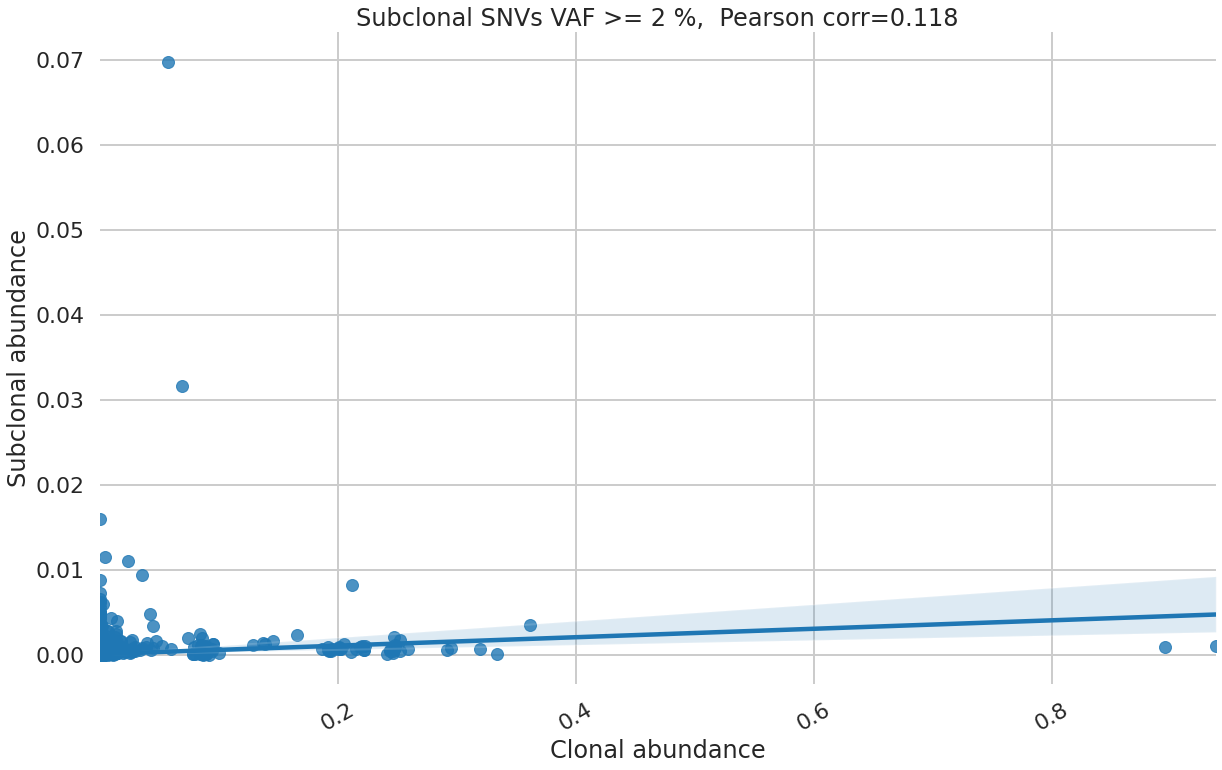

In [87]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf002), 
                 title="Subclonal SNVs VAF >= 2 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_2.png"), dpi=200)

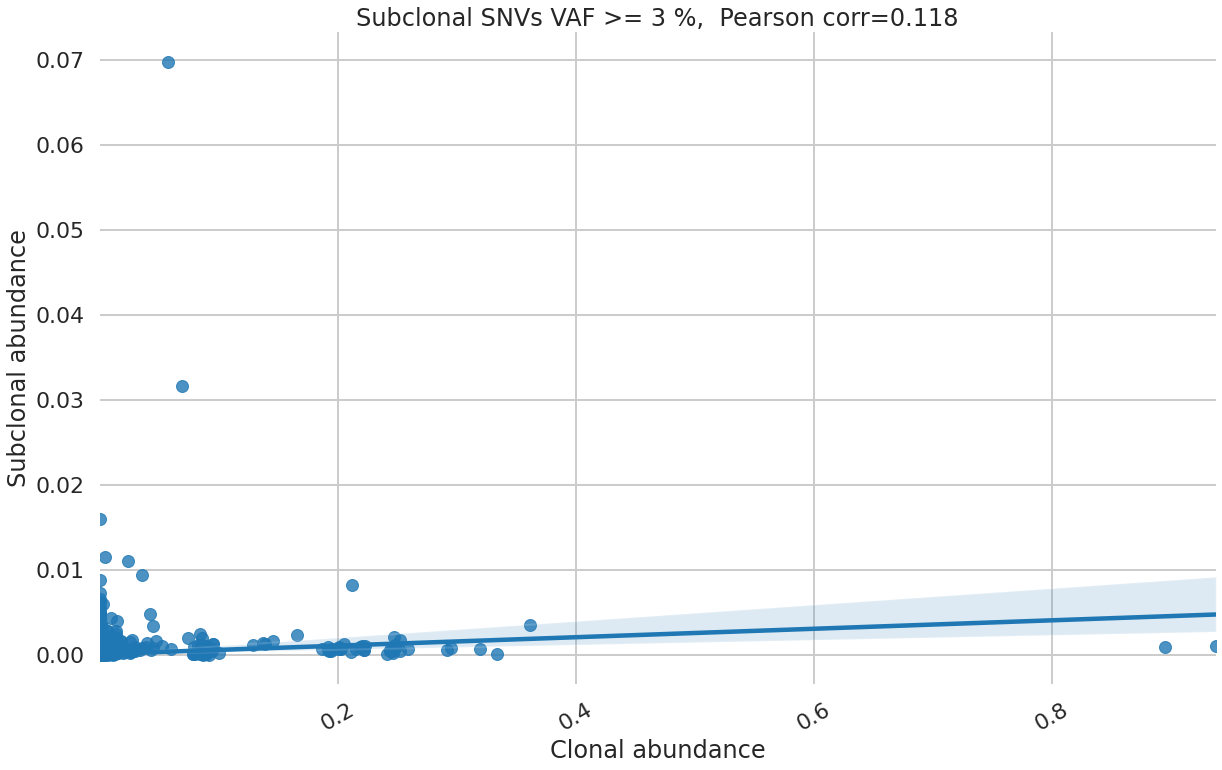

In [88]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf003), 
                 title="Subclonal SNVs VAF >= 3 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_3.png"), dpi=200)

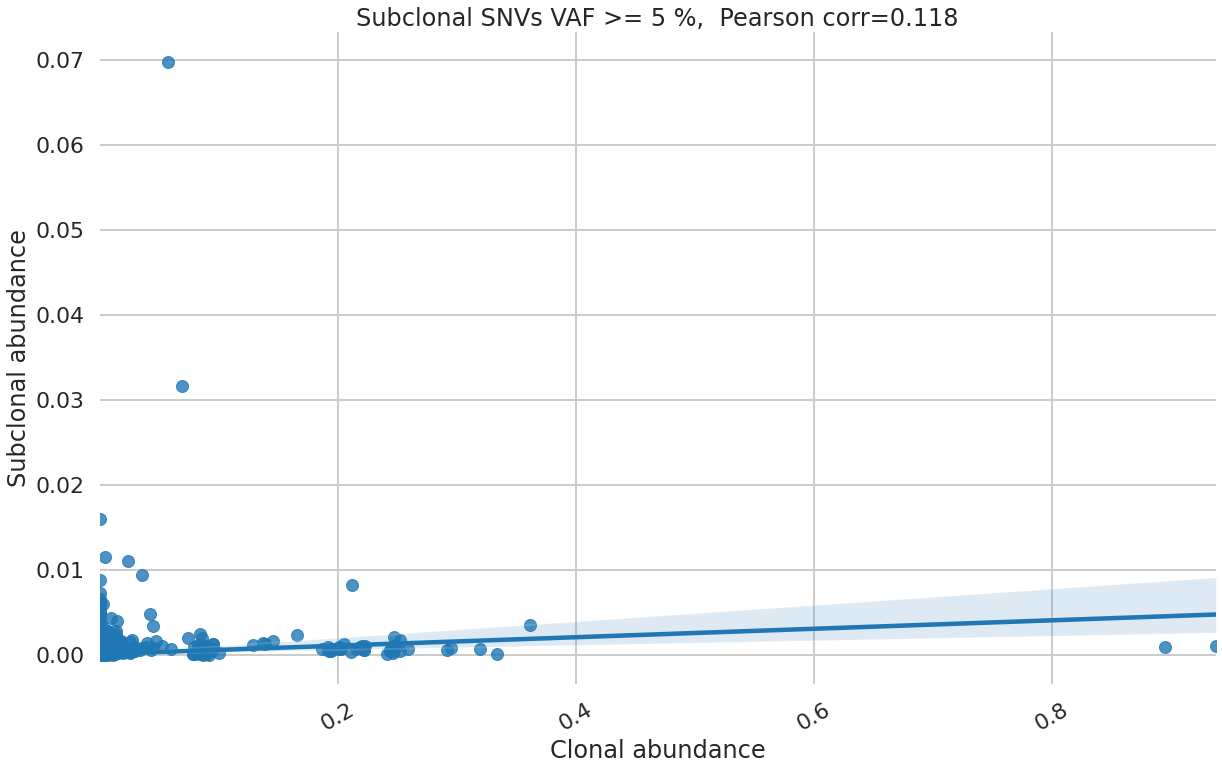

In [89]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf005), 
                 title="Subclonal SNVs VAF >= 5 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_5.png"), dpi=200)

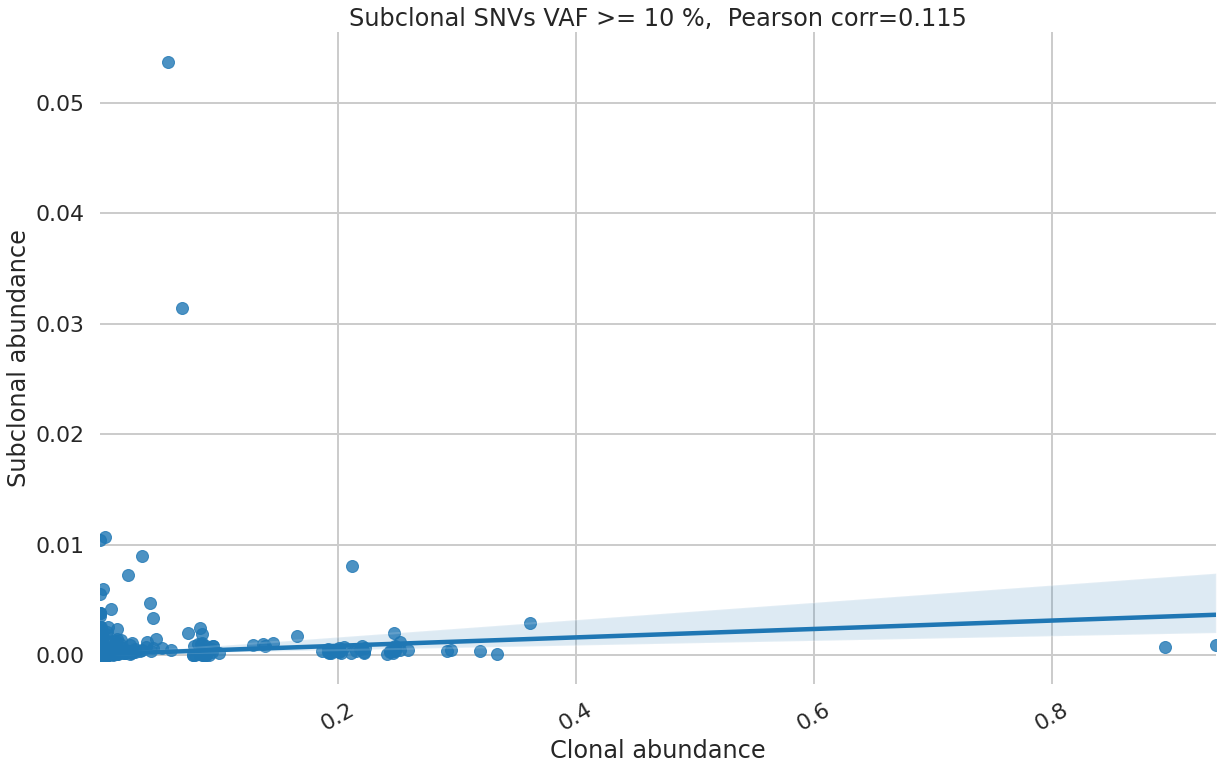

In [90]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf01), 
                 title="Subclonal SNVs VAF >= 10 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_10.png"), dpi=200)

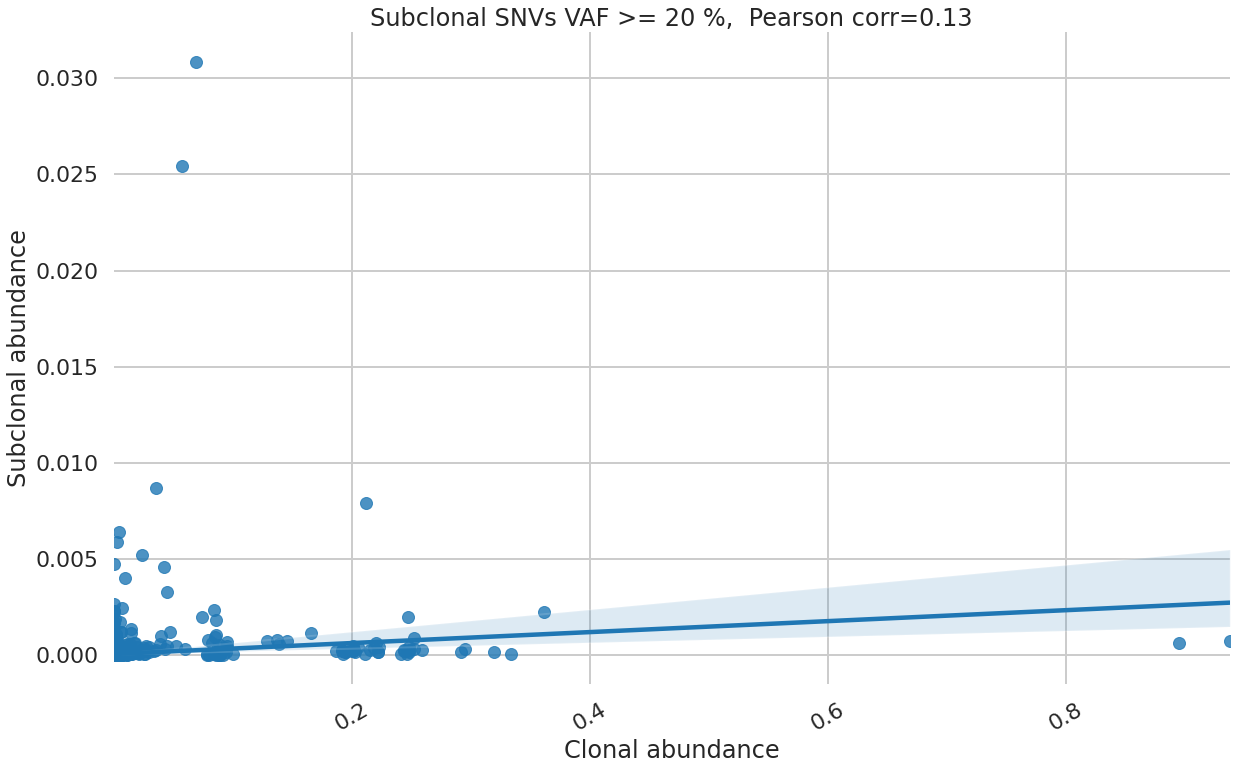

In [91]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf02), 
                 title="Subclonal SNVs VAF >= 20 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_20.png"), dpi=200)

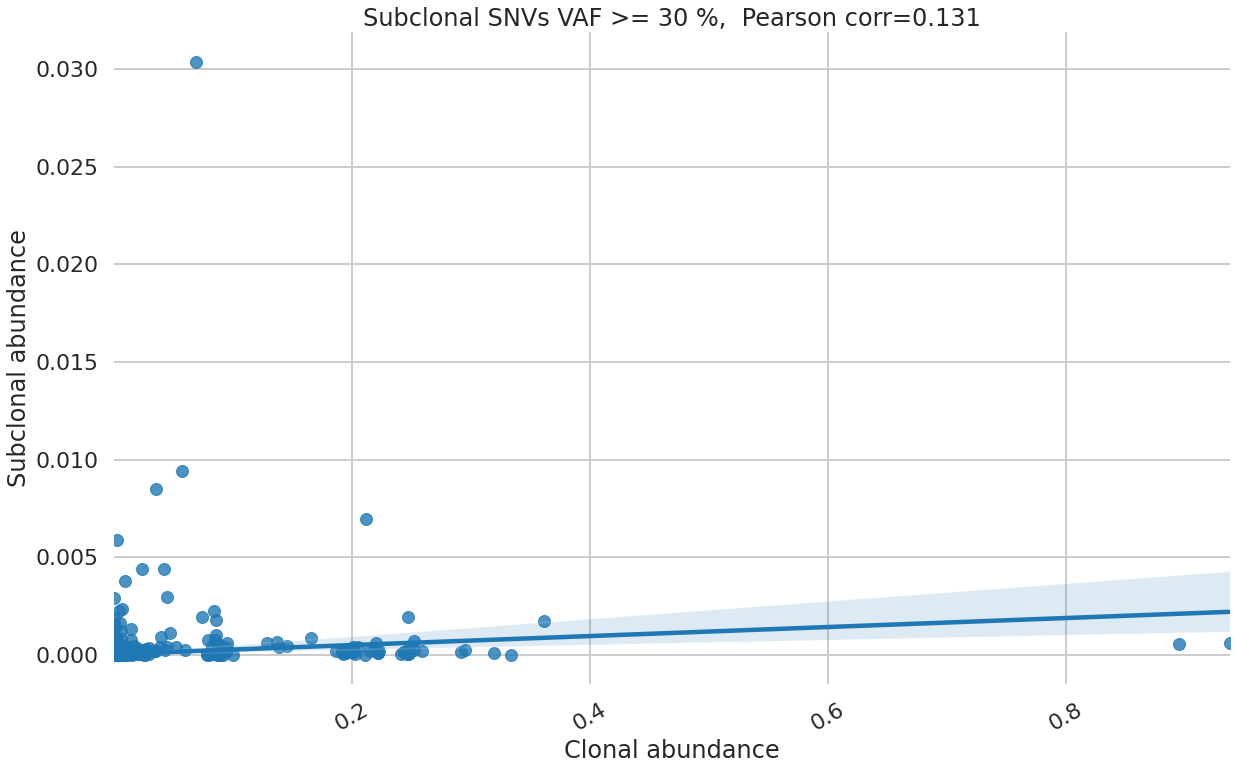

In [92]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf03), 
                 title="Subclonal SNVs VAF >= 30 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_30.png"), dpi=200)

## Correlation between clonal abundance and conservation

In [93]:
def plot_correlation_conservation(sample_data, clonal_data, title=None):
    
    included_samples = sample_data.run_accession.unique()
    frequencies_clonal_snvs = clonal_data[clonal_data["sample"].isin(included_samples)][["variant_id", "sample"]].groupby("variant_id").count().reset_index()
    frequencies_clonal_snvs["af"] = frequencies_clonal_snvs["sample"] / included_samples.shape[0]
    
    conservation_data = clonal_data[clonal_data["sample"].isin(included_samples)][["variant_id", "cons_hmm_sars_cov_2"]].groupby("variant_id").first().reset_index()
    
    data = pd.merge(left=frequencies_clonal_snvs, right=conservation_data, on="variant_id", how="left")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    sns.regplot(data=data, x="af", y="cons_hmm_sars_cov_2")
    plt.xticks(rotation=30)
    sns.despine(bottom=True, left=True)
    ax.set_xlabel("Clonal abundance")
    ax.set_ylabel("ConsHMM on SARS-CoV-2")
    plt.title("{} Pearson corr={}".format(title, round(data.corr().af[2], 3)))
    print(data.corr())
    return fig

                       sample        af  cons_hmm_sars_cov_2
sample               1.000000  1.000000            -0.017889
af                   1.000000  1.000000            -0.017889
cons_hmm_sars_cov_2 -0.017889 -0.017889             1.000000


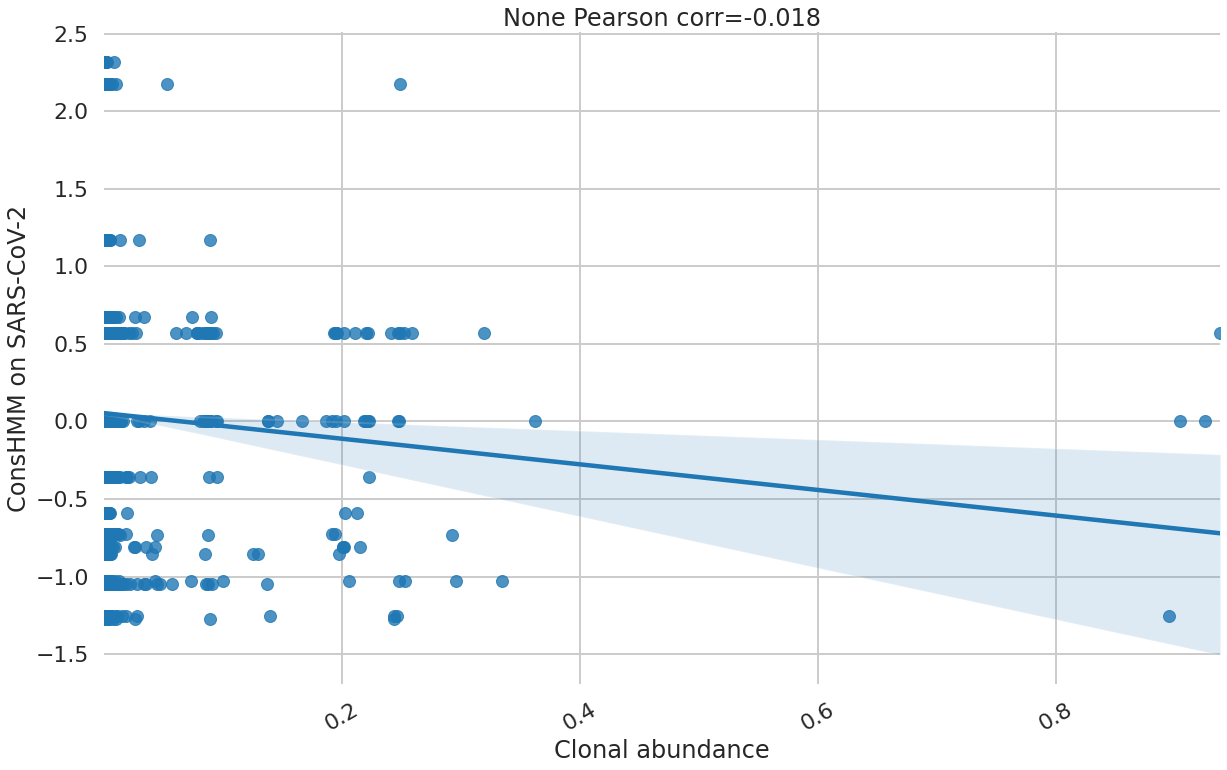

In [94]:
fig = plot_correlation_conservation(sample_data=sample_ena_filtered_samples, clonal_data=clonal_snvs)

                       sample        af  cons_hmm_sars_cov_2
sample               1.000000  1.000000            -0.023839
af                   1.000000  1.000000            -0.023839
cons_hmm_sars_cov_2 -0.023839 -0.023839             1.000000


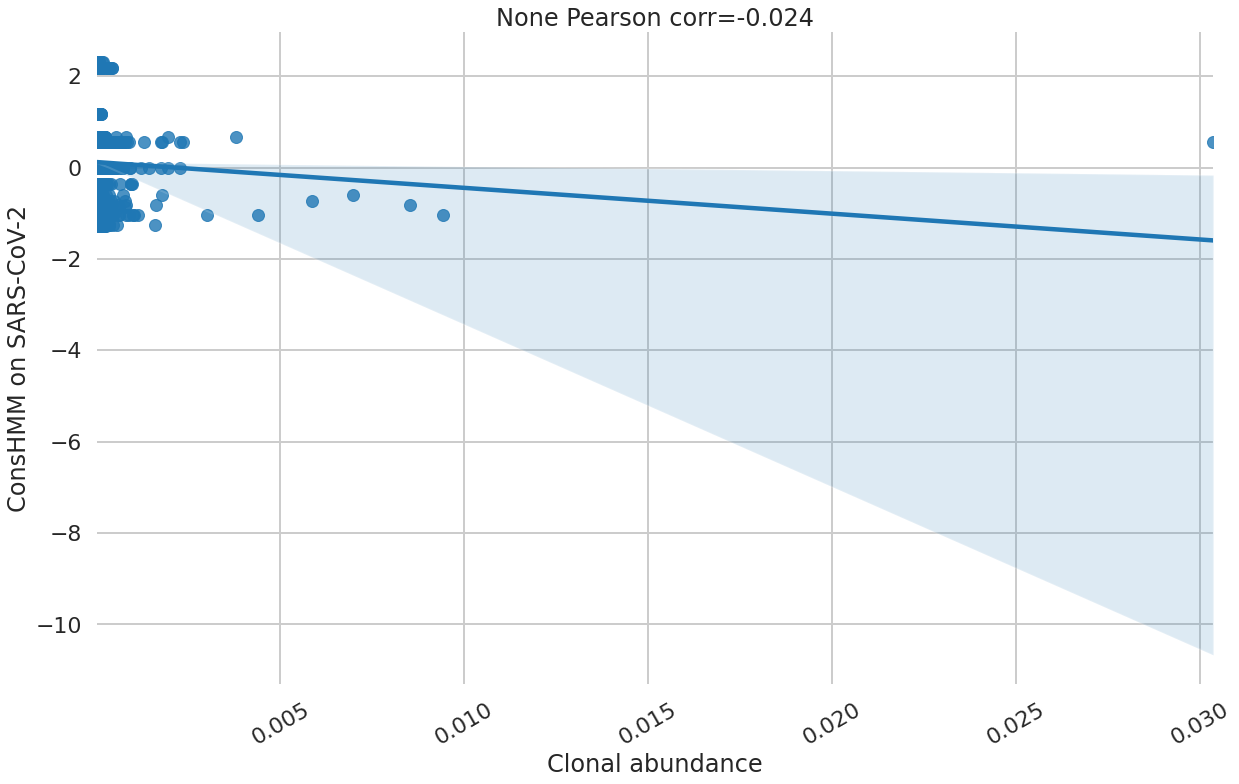

In [95]:
fig = plot_correlation_conservation(sample_data=sample_ena_filtered_samples, clonal_data=subclonal_snvs_filtered_vaf03)

In [96]:
clonal_snvs.shape

(2060026, 35)

## Evolution from subclonal into clonal

In [97]:
def plot_upset(clonal_data, subclonal_data, month):
    data = pd.merge(left=clonal_data[clonal_data.month <= month][["variant_id", "clonal"]],
             right=subclonal_data[subclonal_data.month <= month][["variant_id", "subclonal"]],
             on="variant_id", how="outer").fillna(False)[["variant_id", "clonal", "subclonal"]].groupby("variant_id").sum().reset_index()
    data.clonal = data.clonal.astype(bool)
    data.subclonal = data.subclonal.astype(bool)
    data.set_index(["clonal", "subclonal"], inplace=True)
    #return data
    fig = plt.figure(figsize=(10,6))
    upset = UpSet(data, subset_size='auto', intersection_plot_elements=2, facecolor='steelblue', show_counts=True, element_size=80)
    upset.plot(fig=fig)
    plt.title("Until {}                                                                                                                 ".format(month))
    fig.savefig("clonal_subclonal_upset_until_{}.jpg".format(month), dpi=200)

In [98]:
def plot_subclonal_clonal_through_time(clonal_data, subclonal_data, samples_data, title=None):
    
    subclonal_data = add_dates_to_variants(variants=subclonal_data, samples=samples_data)
    clonal_data = add_dates_to_variants(variants=clonal_data, samples=samples_data)
    
    months = list(clonal_data.collection_date_month.sort_values().unique())
    only_clonal = []
    only_subclonal = []
    both = []
    
    for m in months:
        subclonal_variant_ids = set(subclonal_data[subclonal_data.collection_date_month <= m].variant_id.unique())
        clonal_variant_ids = set(clonal_data[clonal_data.collection_date_month <= m].variant_id.unique())
        both.append(len(subclonal_variant_ids.intersection(clonal_variant_ids)))
        only_clonal.append(len(clonal_variant_ids.difference(subclonal_variant_ids)))
        only_subclonal.append(len(subclonal_variant_ids.difference(clonal_variant_ids)))
    
    all_counts = [x + y + z for x, y, z in  zip(only_clonal, only_subclonal, both)] 
    
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.lineplot(x=pd.Series(months).astype(str), y=both, color=orange, label="Subclonal + clonal", marker='o')
    sns.lineplot(x=pd.Series(months).astype(str), y=only_clonal, color=lightblue, label="Only clonal", marker='o')
    sns.lineplot(x=pd.Series(months).astype(str), y=only_subclonal, color=green, label="Only subclonal", marker='o')
    sns.lineplot(x=pd.Series(months).astype(str), y=all_counts, color=grey, label="All", linestyle='--')
    plt.axhline(SARS_COV_2_GENOME_LENGTH * 3, linestyle='--', color=red, label="Max. number SNVs")
    plt.title(title)
    plt.xlabel(None)
    plt.ylabel("Number of unique mutations")
    plt.yscale('log')
    plt.xticks(rotation=30)
    plt.minorticks_on()
    sns.despine(bottom=True, left=True)
    ax.legend()
    #ax.grid(axis='x')
    ax.grid(axis='x', which='major', alpha=0.5, linewidth=0.5)
    ax.grid(axis='y', which='minor', alpha=0.5, linestyle='dashed', linewidth=0.5)
    #ax.yaxis.set_major_formatter(ScalarFormatter())
    #ax.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    return fig

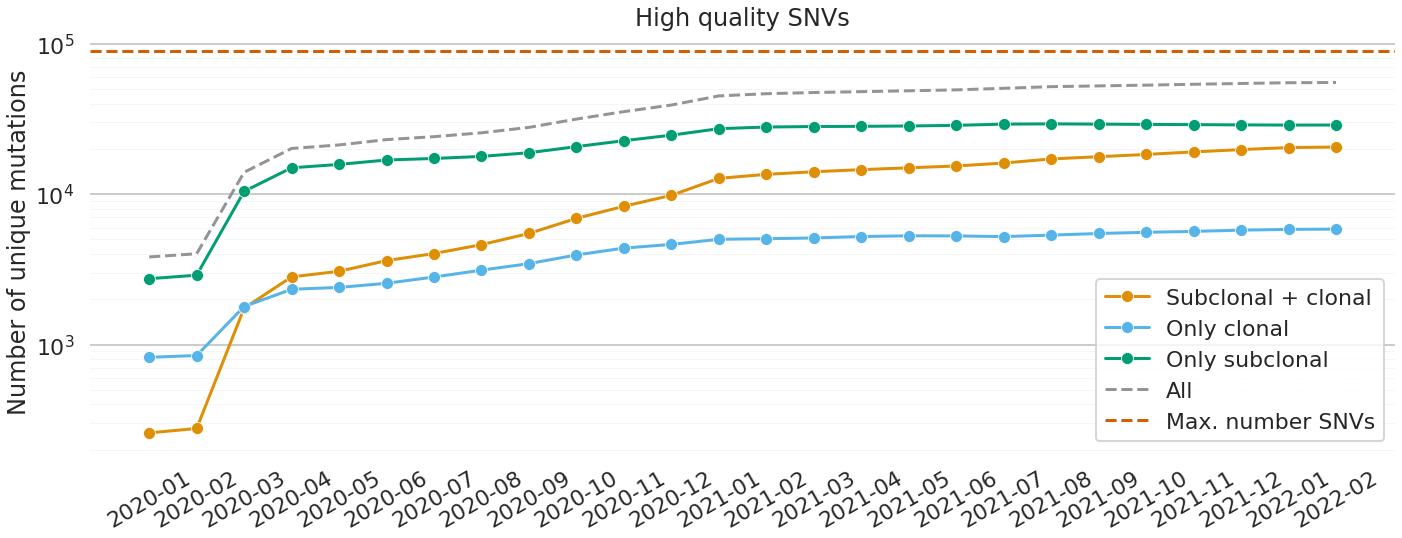

In [99]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf0_sr0, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs.png"), dpi=200)

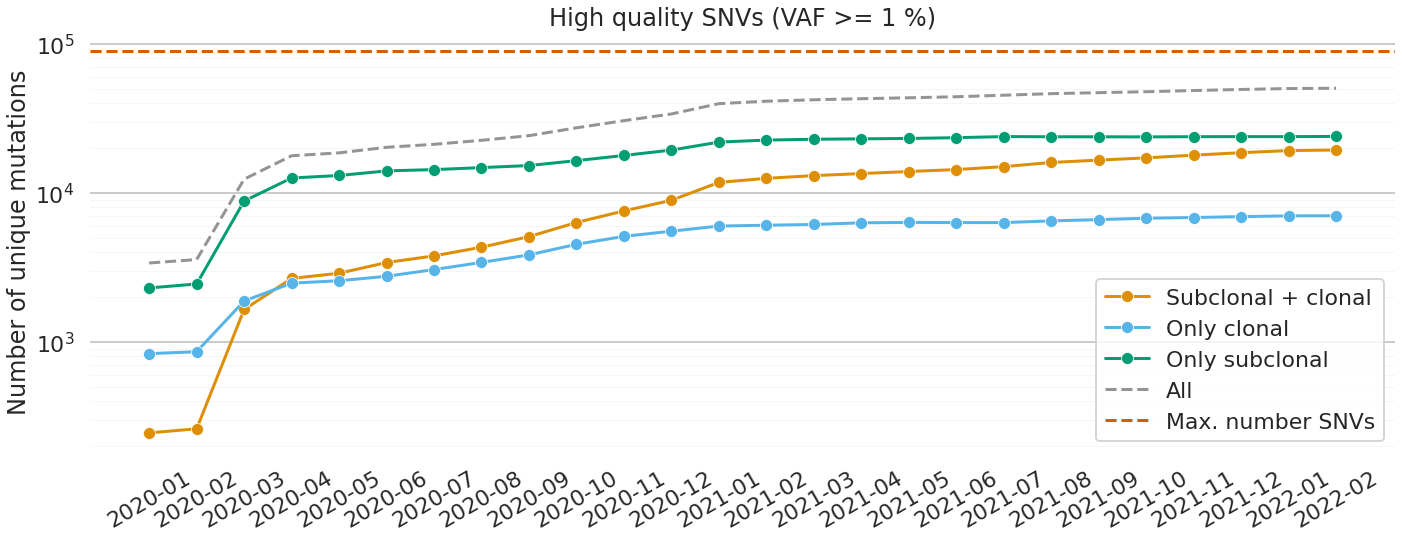

In [100]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf001, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 1 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_1.png"), dpi=200)

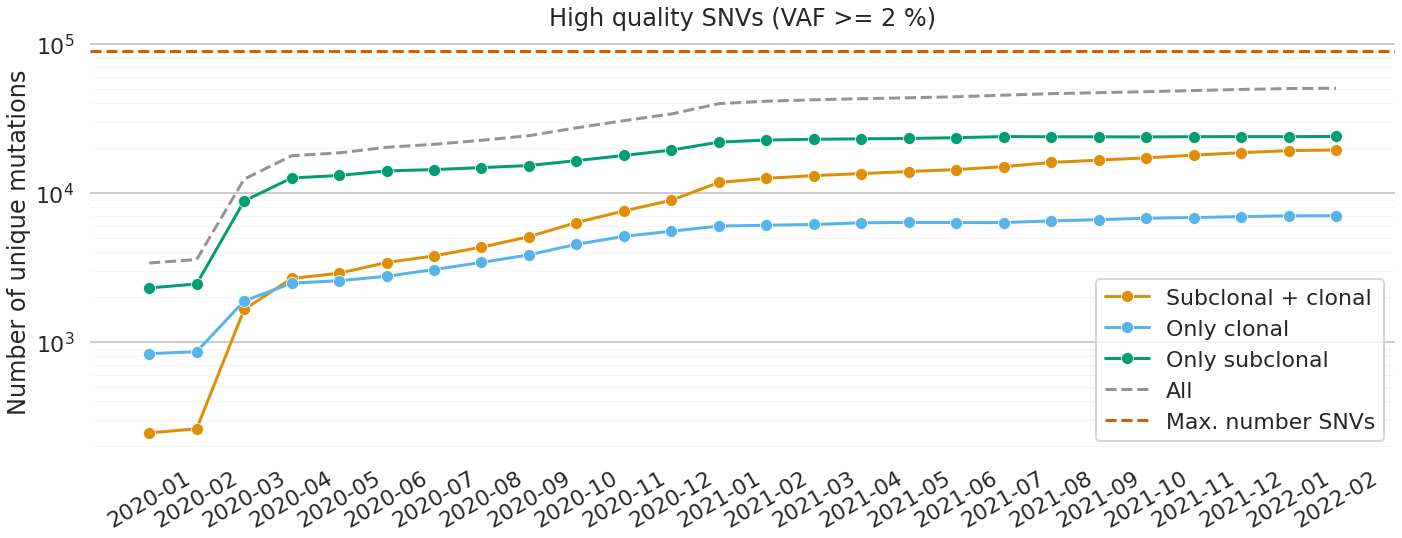

In [101]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf002, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 2 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_2.png"), dpi=200)

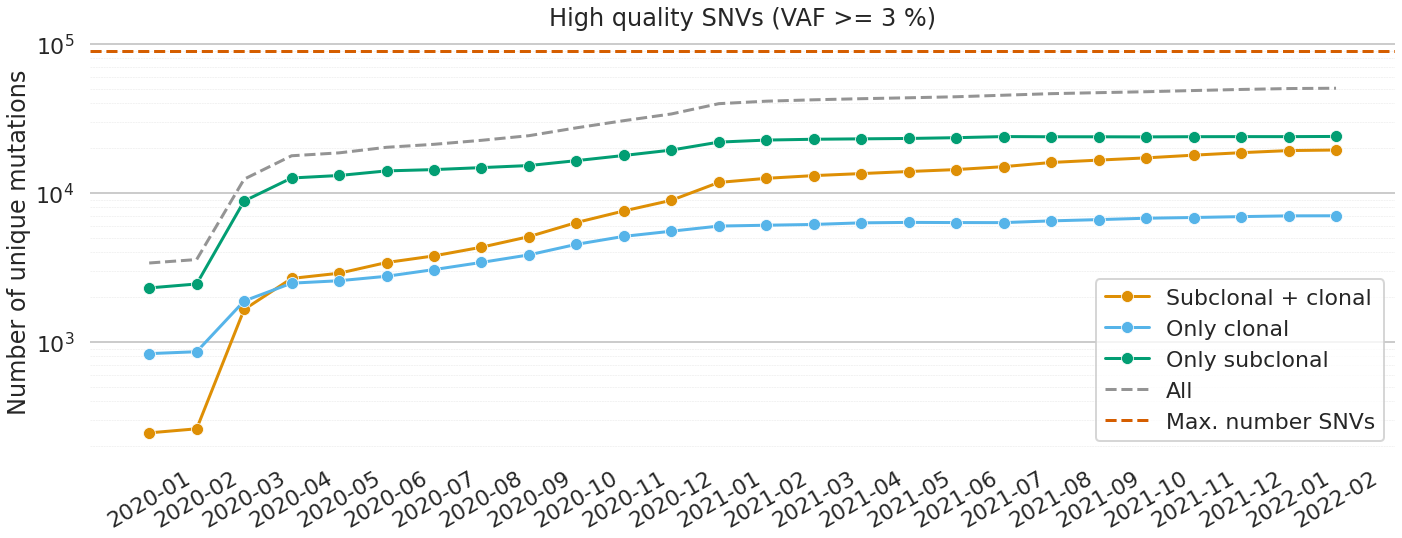

In [102]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf003, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 3 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_3.png"), dpi=200)

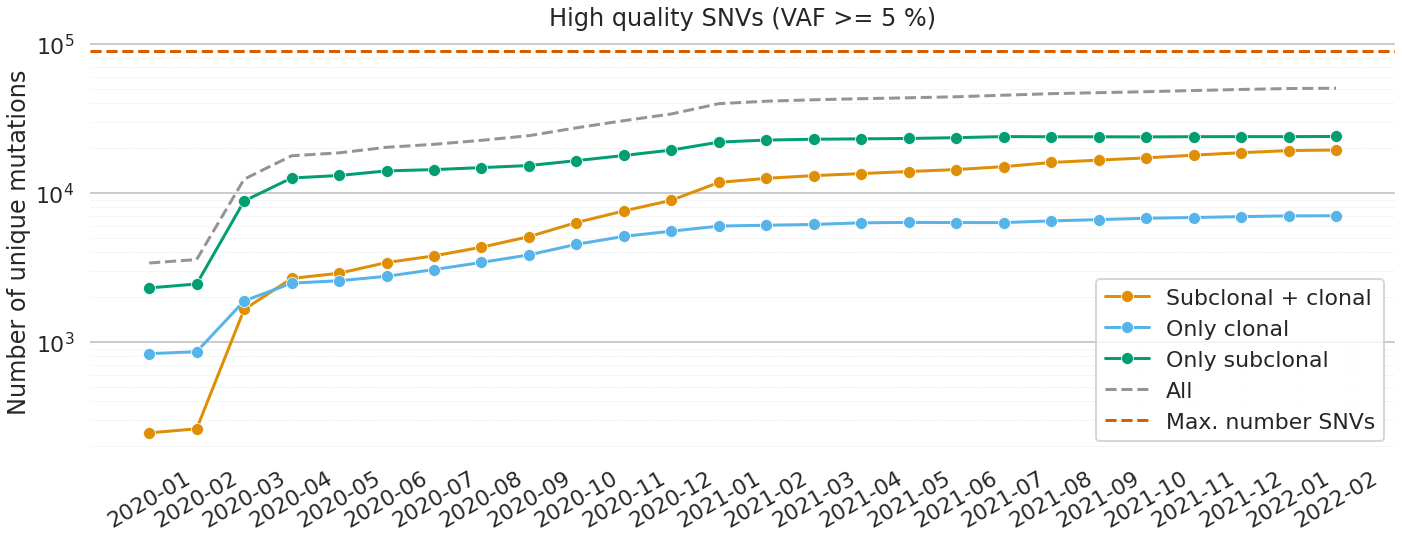

In [103]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf005, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 5 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_5.png"), dpi=200)

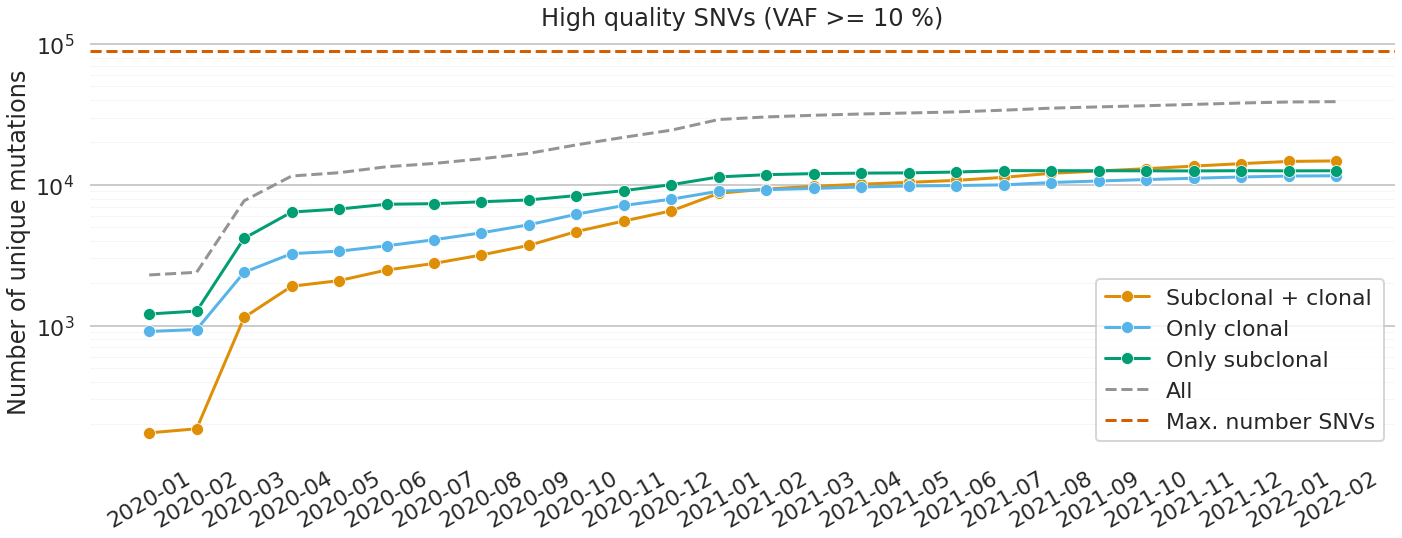

In [104]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf01, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 10 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_10.png"), dpi=200)

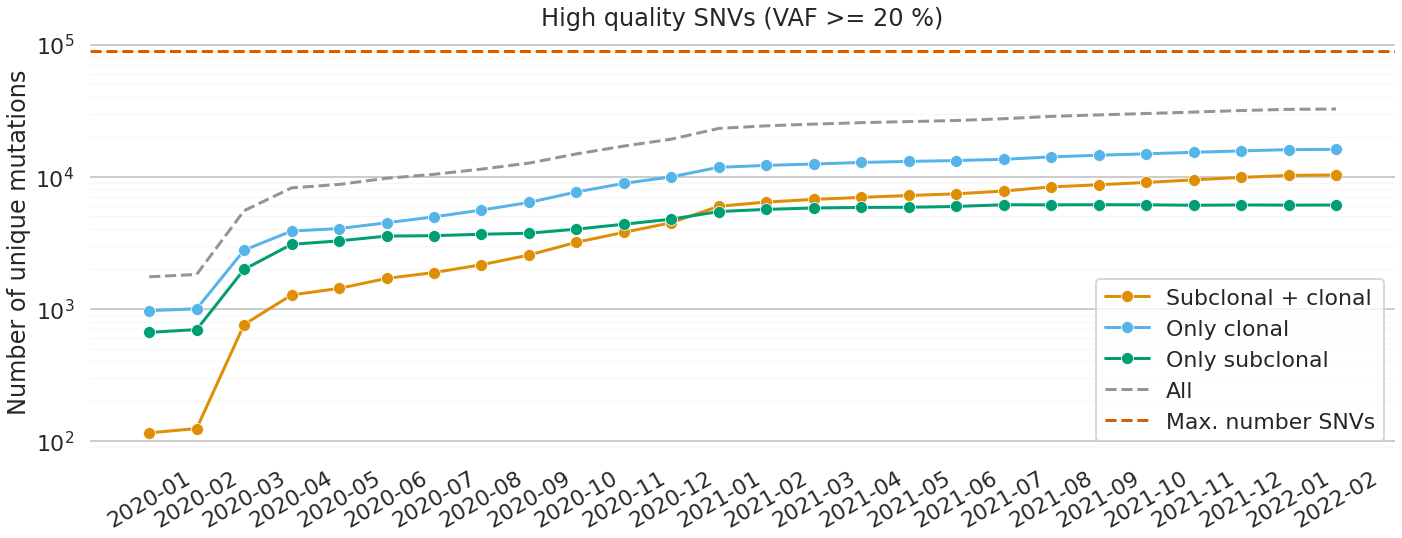

In [105]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf02, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 20 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_20.png"), dpi=200)

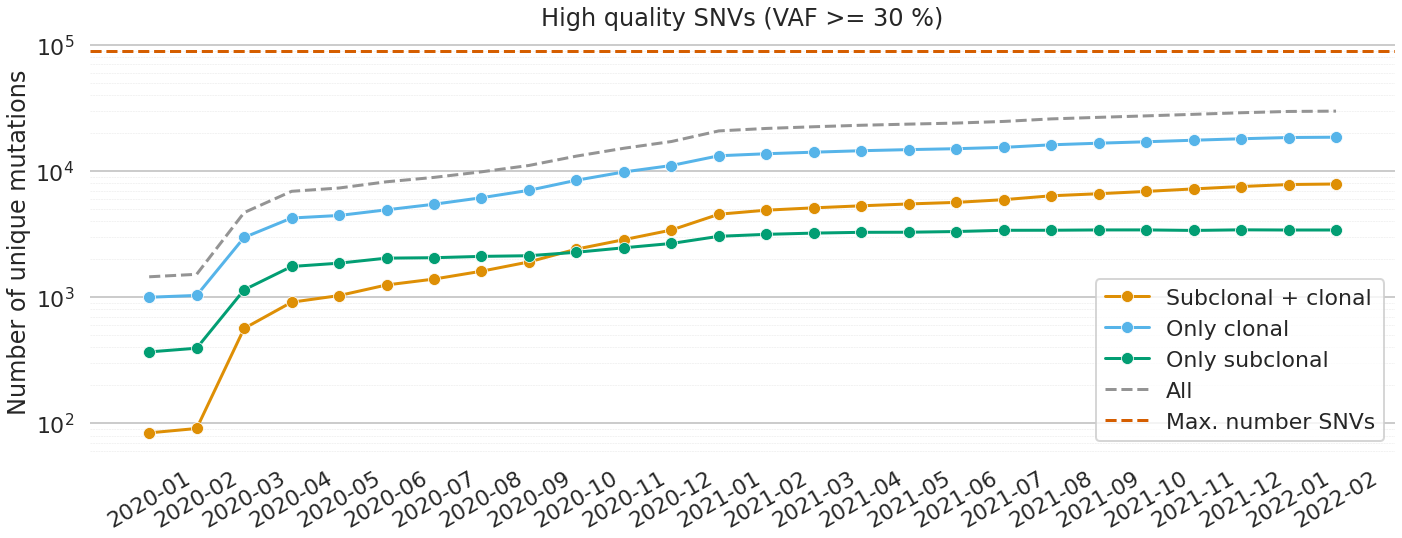

In [106]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf03, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 30 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_30.png"), dpi=200)

## Time from subclonal to clonal

Here we aim to confirm if subclonal observations occur before clonal observations. For that purpose we look into those variants which have both clonal and subclonal observations and then look at the time between the first clonal observation and the first subclonal observation. We expect to see a trend that grows with the passing of time as subclonal observations accumulate. 

Depending on the filtering criteria applied on the subclonal dataset, the mutation space for SARS-CoV-2 is saturated very quickly, meaning that all possible mutations are in the subclonal dataset and thus virtually all clonal variants are previously observed as subclonal. Thus we aim to confirm that the expected trend holds when the mutation space is not saturated. The RNA-Seq samples have a strong effect on the quick saturation of the mutation space, as those are more prevalent on the early months of the dataset and RNA-Seq shows a larger average number of mutations per sample.

In [107]:
def plot_subclonal_to_clonal_time(clonal_data, subclonal_data, sample_data, title=None):
    clonal_variant_ids = set(clonal_data.variant_id)
    subclonal_variant_ids = set(subclonal_data.variant_id)
    variants_of_interest = list(subclonal_variant_ids.intersection(clonal_variant_ids))
    print("There are {} variants with clonal and subclonal observations".format(len(variants_of_interest)))
    
    clonal_data_with_collection_date = add_dates_to_variants(variants=clonal_data, samples=sample_data)
    subclonal_data_with_collection_date = add_dates_to_variants(variants=subclonal_data, samples=sample_data)
    
    first_clonal_observations = clonal_data_with_collection_date[clonal_data_with_collection_date.variant_id.isin(variants_of_interest)][["variant_id", "collection_date"]]\
        .groupby("variant_id").min().reset_index().rename(columns={"collection_date": "first_clonal_observation"})
    first_clonal_observations.first_clonal_observation = pd.to_datetime(first_clonal_observations.first_clonal_observation)
    
    first_subclonal_observations = subclonal_data_with_collection_date[subclonal_data_with_collection_date.variant_id.isin(variants_of_interest)][["variant_id", "collection_date"]]\
        .groupby("variant_id").min().reset_index().rename(columns={"collection_date": "first_subclonal_observation"})
    first_subclonal_observations.first_subclonal_observation = pd.to_datetime(first_subclonal_observations.first_subclonal_observation)
    
    first_clonal_subclonal_observations = pd.merge(left=first_clonal_observations, right=first_subclonal_observations, on="variant_id", how="inner")
    first_clonal_subclonal_observations["time_from_subclonal_to_clonal"] = first_clonal_subclonal_observations.first_clonal_observation - first_clonal_subclonal_observations.first_subclonal_observation
    first_clonal_subclonal_observations["days_from_subclonal_to_clonal"] = first_clonal_subclonal_observations.time_from_subclonal_to_clonal.transform(lambda x: int(x.days))
    
    predictable = first_clonal_subclonal_observations[first_clonal_subclonal_observations.days_from_subclonal_to_clonal > 0]
    unpredictable = first_clonal_subclonal_observations[first_clonal_subclonal_observations.days_from_subclonal_to_clonal <= 0]
    predictable = predictable[predictable.first_clonal_observation > '2020-02']
    unpredictable = unpredictable[unpredictable.first_clonal_observation > '2020-02']
    
    predictable["first_subclonal_observation_month"] = predictable.first_subclonal_observation.dt.to_period('m')
    predictable["first_clonal_observation_month"] = predictable.first_clonal_observation.dt.to_period('m')
    unpredictable["first_subclonal_observation_month"] = unpredictable.first_subclonal_observation.dt.to_period('m')
    unpredictable["first_clonal_observation_month"] = unpredictable.first_clonal_observation.dt.to_period('m')
    
    predictable_counts_per_month = predictable[["first_subclonal_observation_month", "variant_id"]] \
        .groupby("first_subclonal_observation_month").count().reset_index().rename(columns={"variant_id": "count"})
    predictable_counts_per_month["class"] = "predictable"
    unpredictable_counts_per_month = unpredictable[["first_subclonal_observation_month", "variant_id"]] \
        .groupby("first_subclonal_observation_month").count().reset_index().rename(columns={"variant_id": "count"})
    unpredictable_counts_per_month["class"] = "unpredictable"

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [2, 1]})
    sns.scatterplot(data=predictable, 
                    x="first_clonal_observation", 
                    y="days_from_subclonal_to_clonal", 
                    marker="x", color=orange, alpha=0.7,
                    label="Predictable (n={})".format(predictable.shape[0]),
                    ax=ax1)
    sns.scatterplot(data=unpredictable, 
                    x="first_clonal_observation", 
                    y="days_from_subclonal_to_clonal", 
                    marker="x", color=grey, alpha=0.7,
                    label="Unpredictable (n={})".format(unpredictable.shape[0]),
                    ax=ax1)
    sbarplot = sns.barplot(data=pd.concat([predictable_counts_per_month, unpredictable_counts_per_month]).sort_values("first_subclonal_observation_month"), 
                y="count", x="first_subclonal_observation_month", hue="class",  ax=ax2, palette=[orange, grey])
    for p in sbarplot.patches:
        value = int(p.get_height()) if not math.isnan(p.get_height()) else 0
        sbarplot.annotate(value, (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points', size=10)
    
    ax1.tick_params(axis='x', labelrotation=30)
    ax2.tick_params(axis='x', labelrotation=30)
    ax1.set_title(title)
    sns.despine(bottom=True, left=True)
    ax1.grid(axis='y')
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.ticklabel_format(style='plain', axis='y')
    ax1.legend(loc='lower right')
    ax2.legend().remove()
    ax1.set_xlabel("1st clonal observation")
    ax2.set_ylabel(None)
    ax2.set_xlabel("Abundance of 1st subclonal observations")
    ax1.set_ylabel("Days since 1st subclonal observation")
    ax2.set_yscale("log")
    
    fig.tight_layout()

    return fig

There are 21463 variants with clonal and subclonal observations


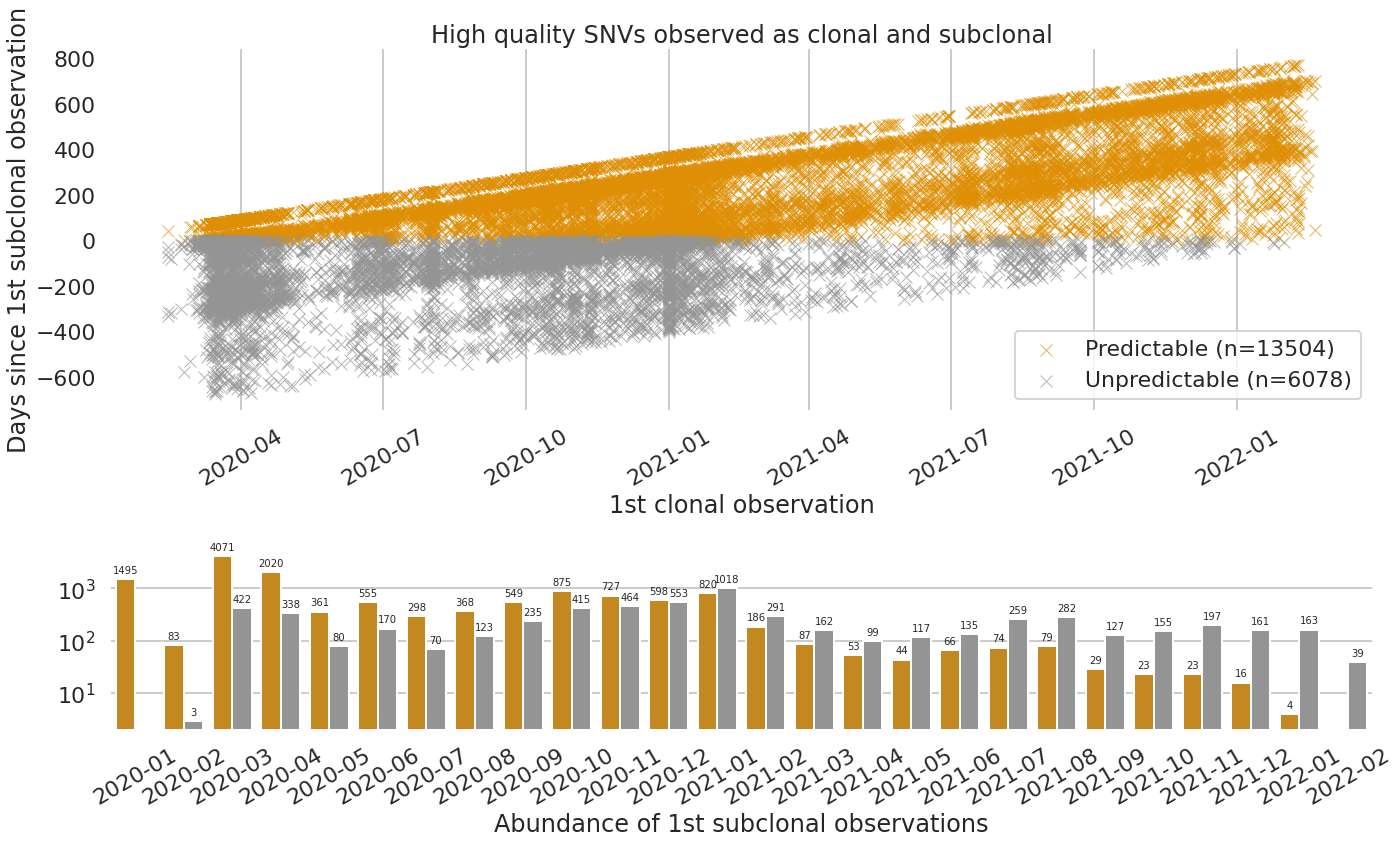

In [108]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf0_sr0, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs.png"), dpi=200)

There are 20187 variants with clonal and subclonal observations


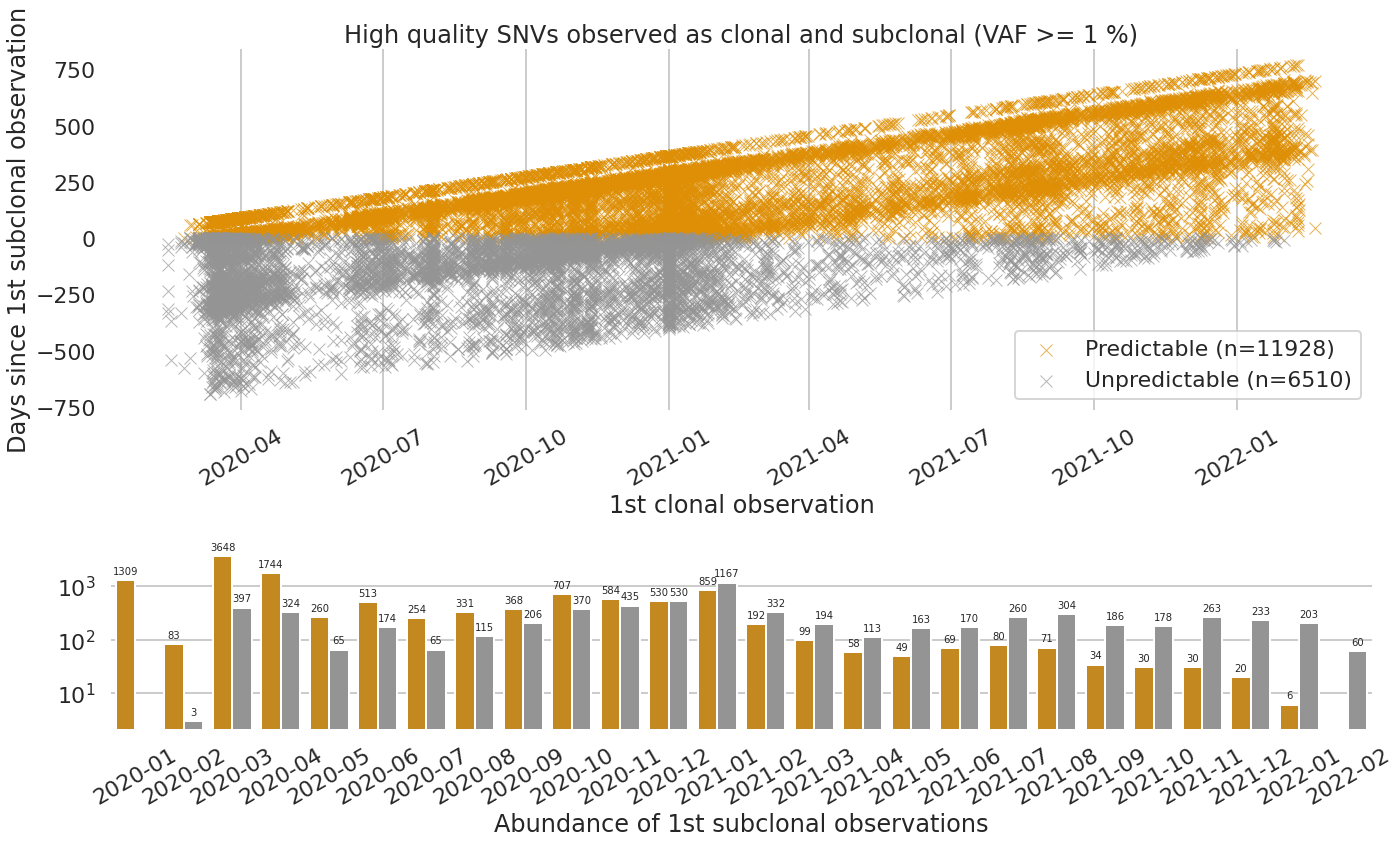

In [109]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf001, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 1 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_1.png"), dpi=200)

There are 20187 variants with clonal and subclonal observations


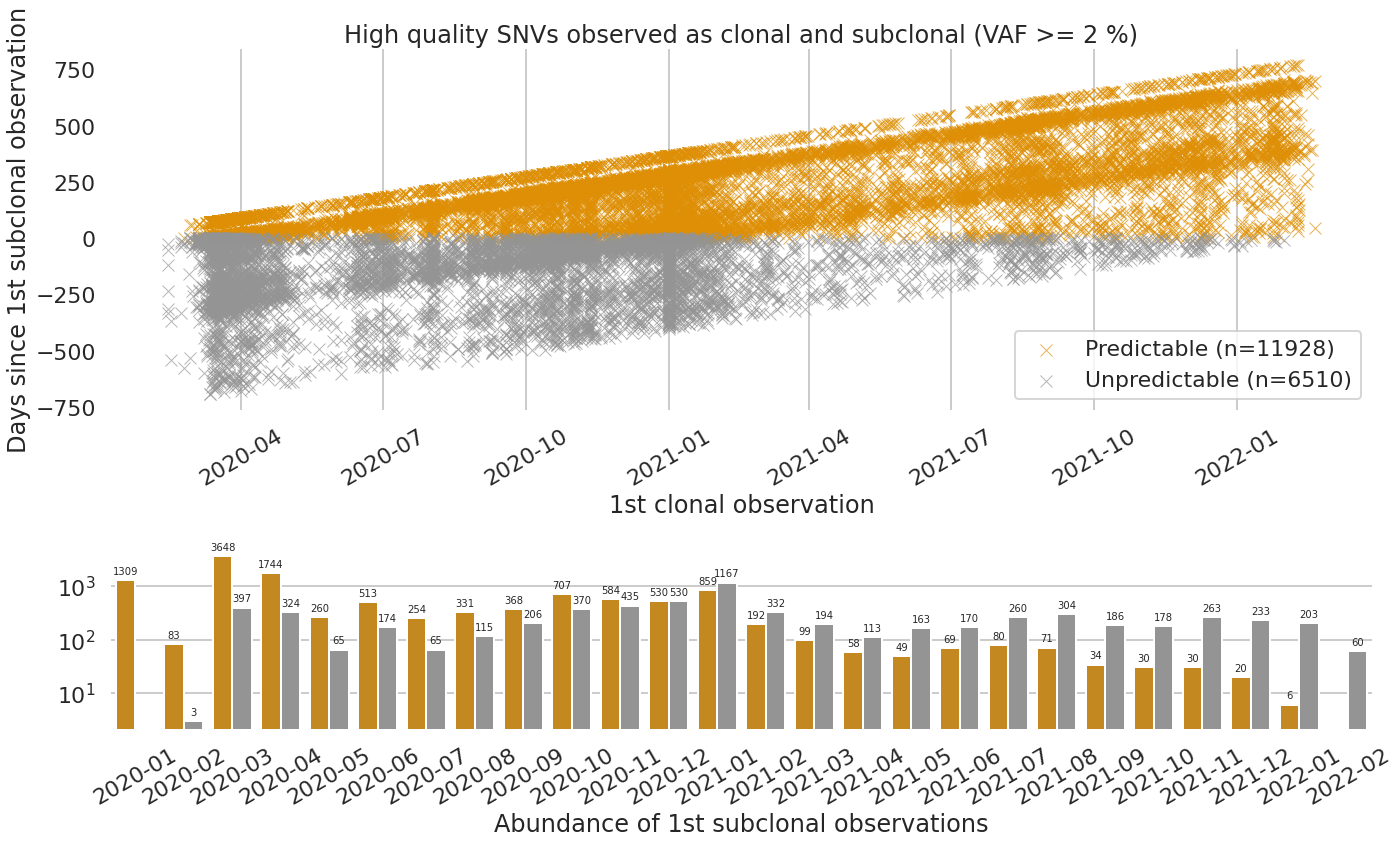

In [110]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf002, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 2 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_2.png"), dpi=200)

There are 20187 variants with clonal and subclonal observations


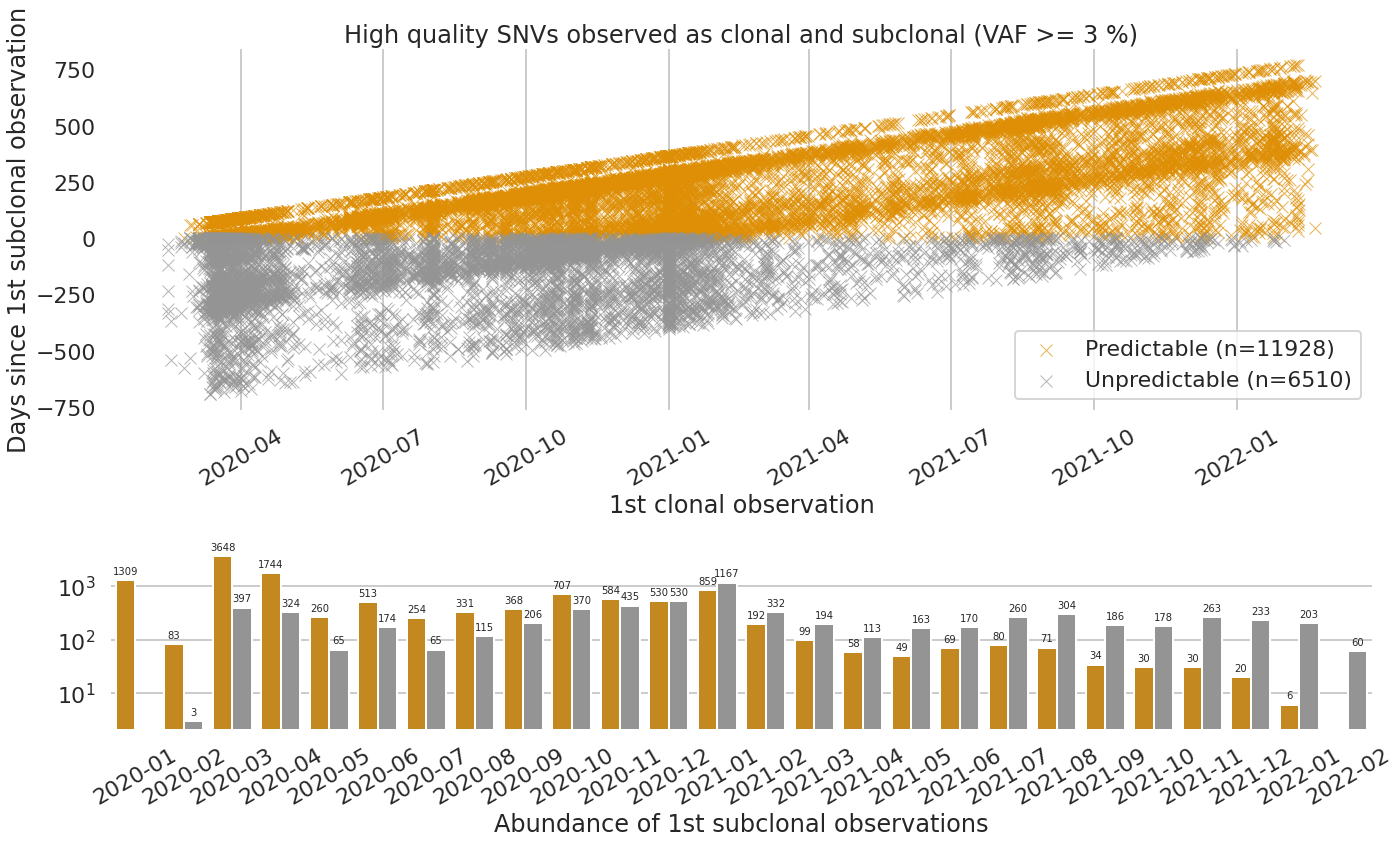

In [111]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf003, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 3 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_3.png"), dpi=200)

There are 20187 variants with clonal and subclonal observations


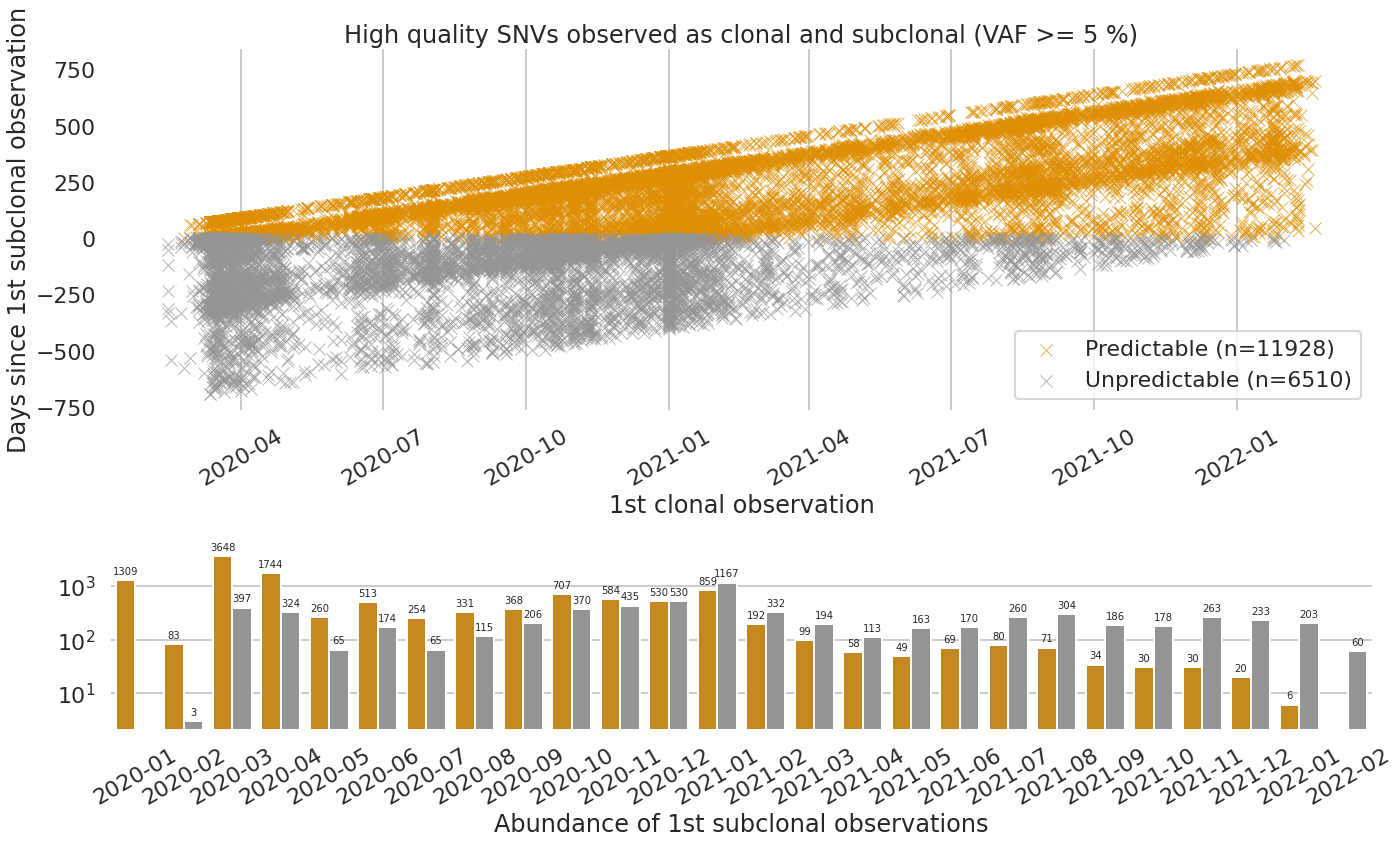

In [112]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf005, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 5 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_5.png"), dpi=200)

There are 15301 variants with clonal and subclonal observations


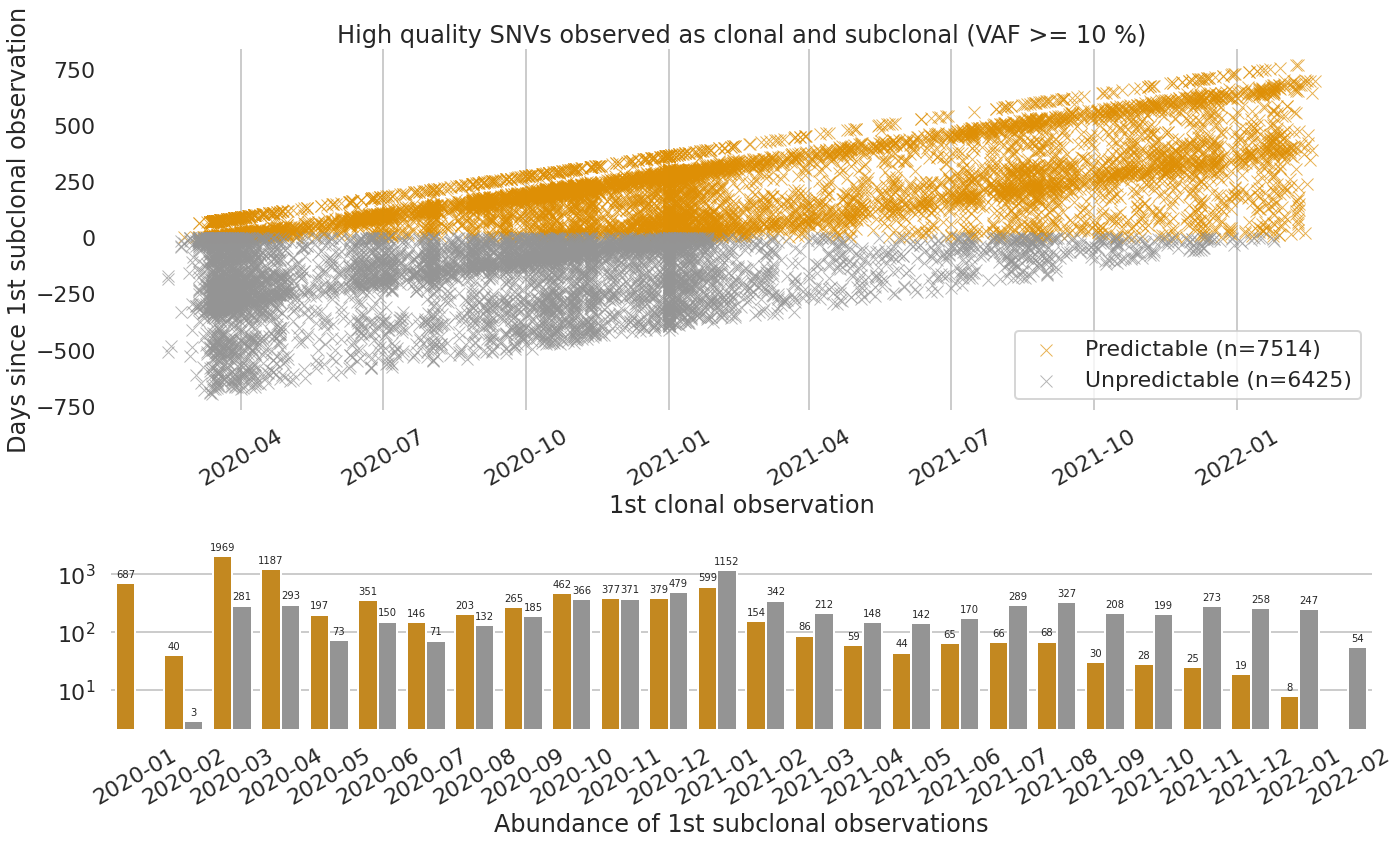

In [113]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf01, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 10 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_10.png"), dpi=200)

There are 10575 variants with clonal and subclonal observations


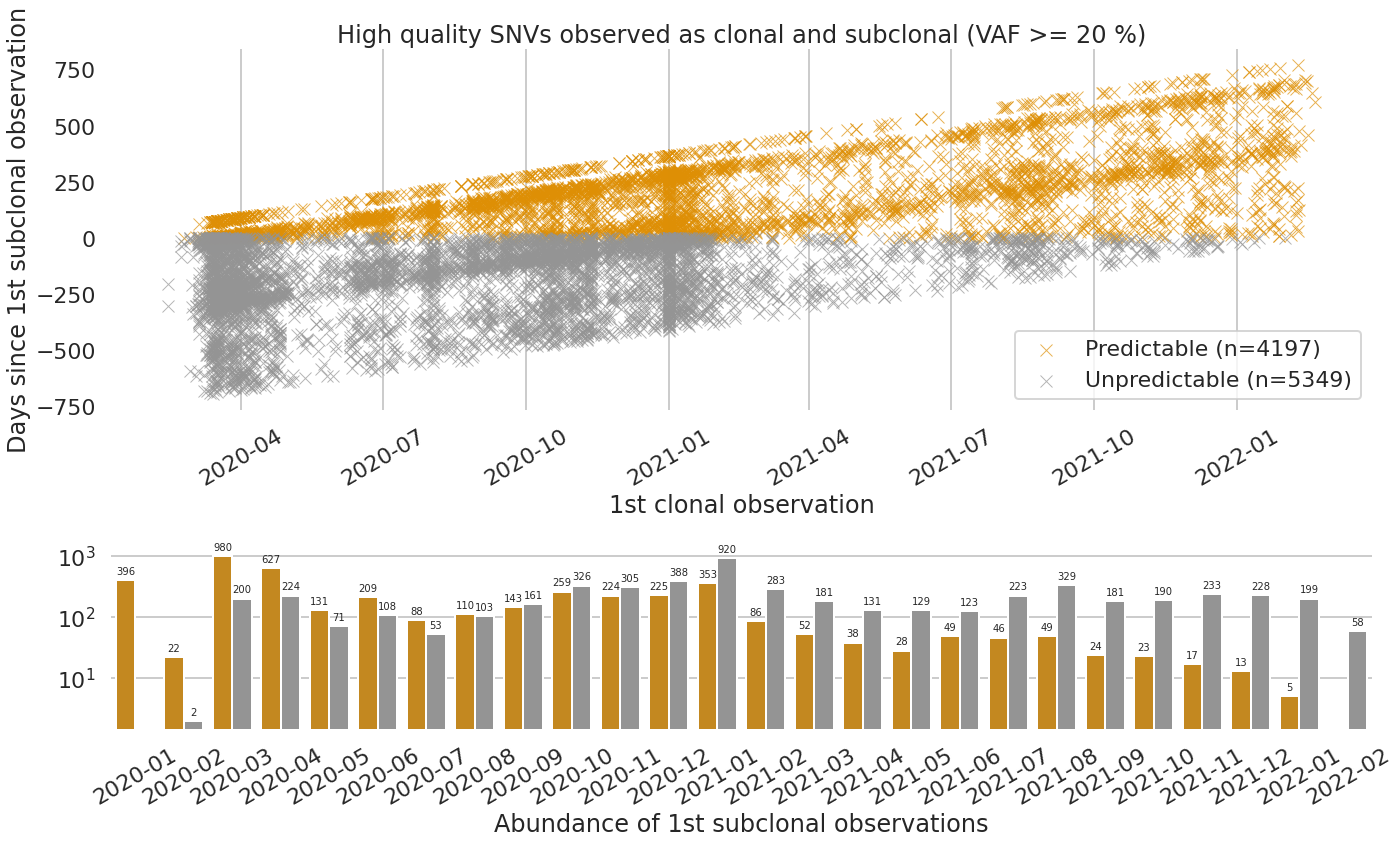

In [114]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf02, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 20 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_20.png"), dpi=200)

There are 8055 variants with clonal and subclonal observations


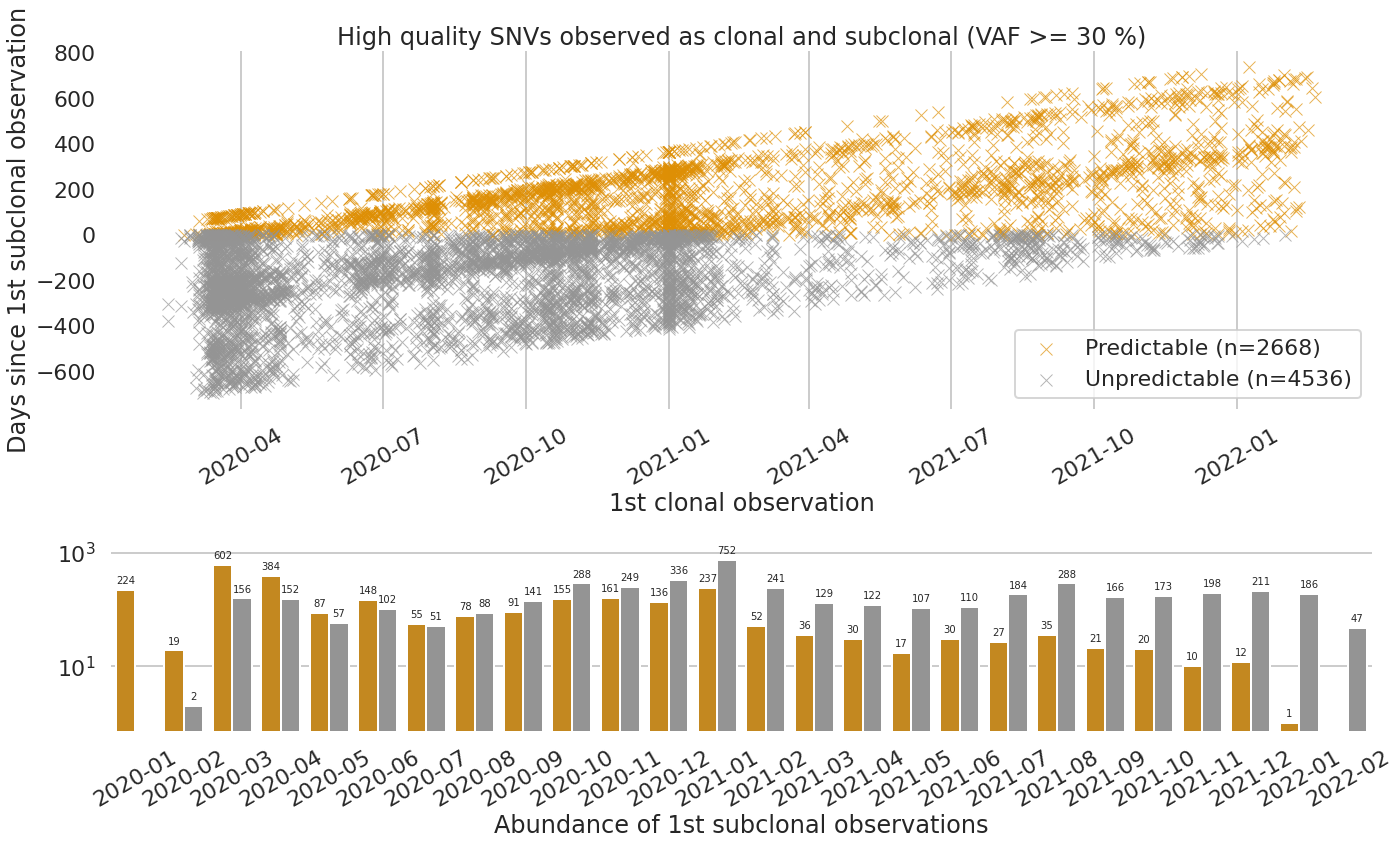

In [115]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf03, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 30 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_30.png"), dpi=200)

## Prioritise subclonal variants

Here we aim at prioritising subclonal variants for their risk of becoming clonal.

### Simulation on accumulated temporal data

We have data accumulated since January 2020 until June 2021. Here we will use the data accumulated prior to January 2021 to prioritise variants only observed as subclonal. Then we will assess this prioritsation with the clonal variants that were first observed from January 2021 onwards.

We will use the dataset filtering out all subclonal variants with a VAF < 0.1 and with less than 3 supporting reads as its population AFs show the larger correlation with the clonal variants. RNA-seq samples are also excluded.

In [116]:
def select_test_and_truth_set(clonal_data, subclonal_data, sample_data):

    clonal_data_with_dates = add_dates_to_variants(clonal_data[
        (clonal_data.annotation_highest_impact != "synonymous_variant") & (~clonal_data.gene_name.isna())], sample_data)
    subclonal_data_with_dates = add_dates_to_variants(subclonal_data[
        (subclonal_data.annotation_highest_impact != "synonymous_variant") & (~subclonal_data.gene_name.isna())], sample_data)
    
    # gets only subclonal variants from 2020
    subclonal_2020 = subclonal_data_with_dates[subclonal_data_with_dates.collection_date < '2021-01-01']
    clonal_2020 = clonal_data_with_dates[clonal_data_with_dates.collection_date < '2021-01-01']
    only_subclonal_2020 = subclonal_2020[~subclonal_2020.variant_id.isin(clonal_2020.variant_id.unique())]
    
    # gets the new clonal variants from 2021
    clonal_first_observations = clonal_data_with_dates[["variant_id", "collection_date"]].groupby("variant_id").min().reset_index()
    clonal_2021_variant_ids = clonal_first_observations[clonal_first_observations.collection_date >= '2021-01-01'].variant_id.unique()
    clonal_2021 = clonal_data_with_dates[clonal_data_with_dates.variant_id.isin(clonal_2021_variant_ids)][["variant_id", "sample"]]
    
    print("Only subclonal from 2020: {}".format(only_subclonal_2020.variant_id.unique().shape[0]))
    print("New clonal from 2021: {}".format(clonal_2021.variant_id.unique().shape[0]))
    print("Predictable: {}".format(len(set(clonal_2021.variant_id).intersection(set(only_subclonal_2020.variant_id)))))
    
    return only_subclonal_2020, clonal_2021

In [117]:
def prioritise_subclonal(subclonal_data, clonal_data):
    subclonal_counts = subclonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_subclonal"})
    clonal_counts = clonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_clonal"})
    prioritised_subclonal = pd.merge(left=subclonal_counts, right=clonal_counts, on="variant_id", how="left").reset_index().sort_values("count_subclonal", ascending=False).reset_index(drop=True)
    prioritised_subclonal["match"] = prioritised_subclonal.count_clonal > 0
    del prioritised_subclonal["index"]
    prioritised_subclonal.reset_index(inplace=True)
    prioritised_subclonal["rank"] = prioritised_subclonal["index"] + 1
    prioritised_subclonal.fillna(0, inplace=True)
    return prioritised_subclonal

In [118]:
only_subclonal_2020_vaf001, clonal_2021_vaf001 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf001, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf002, clonal_2021_vaf002 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf002, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf003, clonal_2021_vaf003 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf003, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf005, clonal_2021_vaf005 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf005, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf01, clonal_2021_vaf01 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf01, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf02, clonal_2021_vaf02 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf02, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf03, clonal_2021_vaf03 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf03, 
    sample_data=sample_ena_filtered_samples)

Only subclonal from 2020: 14485
New clonal from 2021: 7529
Predictable: 3198
Only subclonal from 2020: 14485
New clonal from 2021: 7529
Predictable: 3198
Only subclonal from 2020: 14485
New clonal from 2021: 7529
Predictable: 3198
Only subclonal from 2020: 14485
New clonal from 2021: 7529
Predictable: 3198
Only subclonal from 2020: 7425
New clonal from 2021: 7529
Predictable: 1854
Only subclonal from 2020: 3461
New clonal from 2021: 7529
Predictable: 937
Only subclonal from 2020: 1895
New clonal from 2021: 7529
Predictable: 550


In [119]:
prioritised_subclonal_vaf001 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf001, clonal_data=clonal_2021_vaf001)
prioritised_subclonal_vaf002 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf002, clonal_data=clonal_2021_vaf002)
prioritised_subclonal_vaf003 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf003, clonal_data=clonal_2021_vaf003)
prioritised_subclonal_vaf005 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf005, clonal_data=clonal_2021_vaf005)
prioritised_subclonal_vaf01 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf01, clonal_data=clonal_2021_vaf01)
prioritised_subclonal_vaf02 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf02, clonal_data=clonal_2021_vaf02)
prioritised_subclonal_vaf03 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf03, clonal_data=clonal_2021_vaf03)

In [120]:
def reset_rank_column(data):
    del data["rank"]
    del data["index"]
    data.reset_index(drop=True, inplace=True)
    data.reset_index(inplace=True)
    data["rank"] = data["index"] + 1
    return data

def get_discounted_cumulative_gain(data, top=50, verbose=False):
    top_data = data.head(top)
    dcg = top_data[["match", "rank"]].apply(lambda x: ((2 ** int(x[0])) - 1) / (np.log2(x[1] + 1)), axis=1).sum()
    if verbose:
        print("matches={}, ranks={}".format(top_data.match.sum(), list(top_data[top_data.match]["rank"])))
        print("DCG={}".format(round(dcg, 3)))
    return dcg

def get_ideal_discounted_cumulative_gain(data, top=50):
    ideal_data = reset_rank_column(data=data.sort_values("count_clonal", ascending=False))
    return get_discounted_cumulative_gain(data=ideal_data, top=top)

def get_normalized_discounted_cumulative_gain(data, top=50, verbose=False, shuffles=100):
    dcg = get_discounted_cumulative_gain(data=data, top=top, verbose=True)
    ndcg = dcg / get_ideal_discounted_cumulative_gain(data=data, top=top)
    print("nDCG={}".format(round(ndcg, 3)))
    
    
    random_dcgs = []
    random_ndcgs = []
    random_matches = []
    for _ in range(shuffles):
        shuffled = shuffle_order(data)
        random_dcg = get_discounted_cumulative_gain(data=shuffled, top=top, verbose=verbose)
        random_ndcg = random_dcg / get_ideal_discounted_cumulative_gain(data=shuffled, top=top)
        random_dcgs.append(random_dcg)
        random_ndcgs.append(random_ndcg)
        random_matches.append(shuffled.head(top).match.sum())

    print("Random sort (n={n}) median DCG={dcg}, uDCG={udcg}, matches={matches}, max uDCG={max_udcg}, matches={max_matches}".format(
        dcg=round(np.median(random_dcgs), 3), udcg=round(np.median(random_ndcgs), 3), matches=np.median(random_matches), 
        max_udcg=round(np.max(random_ndcgs), 3), max_matches=np.max(random_matches),
        n=shuffles))
    
    return dcg, ndcg

In [121]:
def shuffle_order(data):
    random_prioritised_subclonal_2020 = data.sample(frac=1)
    del random_prioritised_subclonal_2020["rank"]
    del random_prioritised_subclonal_2020["index"]
    random_prioritised_subclonal_2020.reset_index(drop=True)
    random_prioritised_subclonal_2020.reset_index(inplace=True)
    random_prioritised_subclonal_2020["rank"] = random_prioritised_subclonal_2020["index"] + 1
    return random_prioritised_subclonal_2020

In [122]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf001)

matches=9, ranks=[1, 6, 21, 22, 29, 32, 38, 45, 46]
DCG=2.754
nDCG=0.214
Random sort (n=100) median DCG=0.948, uDCG=0.073, matches=11.0, max uDCG=0.116, matches=17


In [123]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf002)

matches=9, ranks=[1, 6, 21, 22, 29, 32, 38, 45, 46]
DCG=2.754
nDCG=0.214
Random sort (n=100) median DCG=0.914, uDCG=0.071, matches=11.0, max uDCG=0.124, matches=18


In [124]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf003)

matches=9, ranks=[1, 6, 21, 22, 29, 32, 38, 45, 46]
DCG=2.754
nDCG=0.214
Random sort (n=100) median DCG=0.913, uDCG=0.071, matches=11.0, max uDCG=0.139, matches=22


In [125]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf005)

matches=9, ranks=[1, 6, 21, 22, 29, 32, 38, 45, 46]
DCG=2.754
nDCG=0.214
Random sort (n=100) median DCG=0.898, uDCG=0.07, matches=11.0, max uDCG=0.124, matches=18


In [126]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf01)

matches=9, ranks=[1, 3, 12, 18, 28, 32, 38, 45, 47]
DCG=2.959
nDCG=0.229
Random sort (n=100) median DCG=1.149, uDCG=0.089, matches=13.0, max uDCG=0.17, matches=21


In [127]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf02)

matches=12, ranks=[1, 2, 8, 15, 16, 26, 32, 35, 38, 41, 45, 46]
DCG=3.779
nDCG=0.293
Random sort (n=100) median DCG=1.379, uDCG=0.107, matches=14.0, max uDCG=0.171, matches=21


In [128]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf03)

matches=19, ranks=[3, 4, 9, 15, 16, 19, 21, 22, 23, 24, 26, 27, 30, 31, 34, 40, 41, 42, 48]
DCG=4.586
nDCG=0.356
Random sort (n=100) median DCG=1.63, uDCG=0.126, matches=15.0, max uDCG=0.212, matches=22


In [129]:
def prioritise_subclonal_by_conservation(subclonal_data, clonal_data):
    #subclonal_data_with_conservation = pd.merge(left=subclonal_data, right=subclonal_snvs[["variant_id", "cons_hmm_sars_cov_2"]], on="variant_id", how="left").reset_index()
    subclonal_counts = subclonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_subclonal"})
    subclonal_counts_with_annotations = pd.merge(left=subclonal_counts, right=subclonal_data, on="variant_id", how="left").groupby("variant_id").first().reset_index()
    clonal_counts = clonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_clonal"})
    subclonal_counts_with_annotations["af_cons"] = subclonal_counts_with_annotations[["count_subclonal", "cons_hmm_sars_cov_2"]].apply(lambda x: np.log(x[0])*x[1], axis=1)
    prioritised_subclonal = pd.merge(left=subclonal_counts_with_annotations, right=clonal_counts, on="variant_id", how="left").reset_index().sort_values("af_cons", ascending=True).reset_index(drop=True)
    prioritised_subclonal["match"] = prioritised_subclonal.count_clonal > 0
    del prioritised_subclonal["index"]
    prioritised_subclonal.reset_index(inplace=True)
    prioritised_subclonal["rank"] = prioritised_subclonal["index"] + 1
    prioritised_subclonal.fillna(0, inplace=True)
    return prioritised_subclonal

In [130]:
prioritised_subclonal_by_conservation_vaf001 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf001, clonal_data=clonal_2021_vaf001)
prioritised_subclonal_by_conservation_vaf002 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf002, clonal_data=clonal_2021_vaf002)
prioritised_subclonal_by_conservation_vaf003 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf003, clonal_data=clonal_2021_vaf003)
prioritised_subclonal_by_conservation_vaf005 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf005, clonal_data=clonal_2021_vaf005)
prioritised_subclonal_by_conservation_vaf01 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf01, clonal_data=clonal_2021_vaf01)
prioritised_subclonal_by_conservation_vaf02 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf02, clonal_data=clonal_2021_vaf02)
prioritised_subclonal_by_conservation_vaf03 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf03, clonal_data=clonal_2021_vaf03)

In [131]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf001)

matches=18, ranks=[4, 6, 9, 14, 19, 20, 23, 25, 32, 36, 37, 44, 45, 46, 47, 48, 49, 50]
DCG=4.068
nDCG=0.315
Random sort (n=100) median DCG=0.945, uDCG=0.073, matches=11.0, max uDCG=0.133, matches=19


In [132]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf002)

matches=18, ranks=[4, 6, 9, 14, 19, 20, 23, 25, 32, 36, 37, 44, 45, 46, 47, 48, 49, 50]
DCG=4.068
nDCG=0.315
Random sort (n=100) median DCG=0.968, uDCG=0.075, matches=12.0, max uDCG=0.115, matches=17


In [133]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf003)

matches=18, ranks=[4, 6, 9, 14, 19, 20, 23, 25, 32, 36, 37, 44, 45, 46, 47, 48, 49, 50]
DCG=4.068
nDCG=0.315
Random sort (n=100) median DCG=0.894, uDCG=0.069, matches=11.0, max uDCG=0.123, matches=19


In [134]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf005)

matches=18, ranks=[4, 6, 9, 14, 19, 20, 23, 25, 32, 36, 37, 44, 45, 46, 47, 48, 49, 50]
DCG=4.068
nDCG=0.315
Random sort (n=100) median DCG=0.93, uDCG=0.072, matches=11.0, max uDCG=0.114, matches=18


In [135]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf01)

matches=18, ranks=[2, 8, 9, 18, 19, 25, 29, 32, 33, 34, 36, 39, 42, 43, 46, 47, 48, 50]
DCG=4.181
nDCG=0.324
Random sort (n=100) median DCG=1.12, uDCG=0.087, matches=12.0, max uDCG=0.15, matches=19


In [136]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf02)

matches=21, ranks=[5, 6, 7, 10, 12, 14, 16, 17, 18, 25, 26, 28, 31, 34, 38, 39, 41, 43, 47, 48, 50]
DCG=4.915
nDCG=0.381
Random sort (n=100) median DCG=1.39, uDCG=0.108, matches=13.5, max uDCG=0.192, matches=22


In [137]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf03)

matches=28, ranks=[1, 5, 7, 8, 11, 15, 16, 18, 19, 20, 23, 27, 30, 31, 32, 33, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50]
DCG=6.928
nDCG=0.537
Random sort (n=100) median DCG=1.649, uDCG=0.128, matches=14.0, max uDCG=0.197, matches=24


In [138]:
prioritised_subclonal_by_conservation_vaf03.head(50)

index variant_id  count_subclonal       sample  cons_hmm_sars_cov_2  \
0       0  19563:G>T                4   ERR6908046             -1.04511   
1       1  23607:G>T                4  SRR12749719             -1.02973   
2       2  22646:G>C                3   ERR7814010             -1.27455   
3       3  23606:C>T                3   ERR5079142             -1.02973   
4       4  28099:C>T                4   ERR6340529             -0.80744   
5       5  21420:A>C               23   ERR6295848             -0.35633   
6       6  28254:A>T                3   ERR5062297             -0.80744   
7       7  20712:A>G                2  SRR15514182             -1.27455   
8       8  27765:C>G                2   ERR4891384             -1.27455   
9       9  25324:C>A                2   ERR4242208             -1.27455   
10     10  12766:T>G                2  SRR17926781             -1.27455   
11     11  22373:C>T                2   ERR6091059             -1.04511   
12     12  17418:G>T                2  SRR12426824             -1.04511   
13     13  13998:G>T                2   ERR5310955             -1.04511   
14     14  24198:C>T                2   ERR4249295             -1.04511   
15     15  15909:T>C                2   ERR5494484             -1.04511   
16     16   4829:C>T                2   ERR6091064             -1.04511   
17     17  15744:C>T                2   ERR6430738             -1.04511   
18     18   2430:A>G                2  SRR12427349             -1.04511   
19     19  15927:T>C                2  SRR12423245             -1.04511   
20     20  14847:A>G                2   ERR5928933             -1.04511   
21     21  13695:A>G                2  SRR12423786             -1.04511   
22     22  23612:G>A                2   ERR6292745             -1.02973   
23     23  27158:T>G                7  SRR13620203             -0.35633   
24     24  21736:C>G                2   ERR6318766             -0.85561   
25     25   4067:G>A                2  SRR12427509             -0.80744   
26     26  27895:T>C                2   ERR6897598             -0.80744   
27     27   1143:T>G                2   ERR5924684             -0.72927   
28     28  23064:A>G                2   ERR5431019             -0.72927   
29     29  15342:C>A                2   ERR5076527             -0.72839   
30     30  15615:C>T                2  SRR12427193             -0.72839   
31     31  29000:G>A                2   ERR6356706             -0.59191   
32     32   3416:A>G                3   ERR6087871             -0.35633   
33     33   2837:T>G                2   ERR4240056             -0.35633   
34     34  21171:A>C                2   ERR6318661             -0.35633   
35     35   3701:G>A                2   ERR5070762             -0.35633   
36     36  17265:T>C                2  SRR12423203             -0.35633   
37     37   3354:G>T                2  SRR12427017             -0.35633   
38     38  26526:G>C                2   ERR5065412             -0.35633   
39     39  27792:T>C                2   ERR8518191             -0.35633   
40     40   3741:T>C                2   ERR6292538             -0.35633   
41     41  27619:C>T                1   ERR5065327              0.57215   
42     42  27535:C>T                1  SRR13089102              0.57215   
43     43  27536:C>T                1   ERR6435382              0.57215   
44     44  27713:T>C                1   ERR5697111              0.57215   
45     45  27969:A>G                1   ERR5499341             -1.04511   
46     46  27706:G>A                1   ERR6087925             -0.35633   
47     47  27667:G>T                1  SRR13208433              0.00000   
48     48  27562:A>C                1   ERR6336308              0.57215   
49     49  27967:G>A                1   ERR8517810             -0.80744   

   gene_name         hgvs_p run_accession collection_date  \
0     ORF1ab       p.C6433F    ERR6908046      2020-01-01   
1          S        p.R682L   SRR12749719      2020-08-0

In [139]:
prioritised_subclonal_by_conservation_vaf03.head(50)[prioritised_subclonal_by_conservation_vaf03.gene_name == "S"][["variant_id", "hgvs_p", "gene_name", "cons_hmm_sars_cov_2", "count_subclonal", "count_clonal"]]

variant_id    hgvs_p gene_name  cons_hmm_sars_cov_2  count_subclonal  \
1   23607:G>T   p.R682L         S             -1.02973                4   
2   22646:G>C   p.V362L         S             -1.27455                3   
3   23606:C>T   p.R682W         S             -1.02973                3   
9   25324:C>A  p.C1254*         S             -1.27455                2   
11  22373:C>T   p.Q271*         S             -1.04511                2   
14  24198:C>T   p.A879V         S             -1.04511                2   
22  23612:G>A   p.A684T         S             -1.02973                2   
24  21736:C>G    p.F58L         S             -0.85561                2   
28  23064:A>G   p.N501S         S             -0.72927                2   

    count_clonal  
1            0.0  
2            0.0  
3            0.0  
9            0.0  
11           0.0  
14          87.0  
22           1.0  
24           0.0  
28           0.0

In [140]:
prioritised_subclonal_by_conservation_vaf001[prioritised_subclonal_by_conservation_vaf001.hgvs_p == "p.L452Q"]

Empty DataFrame
Columns: [index, variant_id, count_subclonal, sample, cons_hmm_sars_cov_2, gene_name, hgvs_p, run_accession, collection_date, collection_date_month, collection_date_month_str, af_cons, count_clonal, match, rank]
Index: []

In [141]:
prioritised_subclonal_by_conservation_vaf001[prioritised_subclonal_by_conservation_vaf001.hgvs_p == "p.G75V"]

Empty DataFrame
Columns: [index, variant_id, count_subclonal, sample, cons_hmm_sars_cov_2, gene_name, hgvs_p, run_accession, collection_date, collection_date_month, collection_date_month_str, af_cons, count_clonal, match, rank]
Index: []

In [142]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf03)  #get_ideal_discounted_cumulative_gain(data=prioritised_subclonal_vaf03)

matches=28, ranks=[1, 5, 7, 8, 11, 15, 16, 18, 19, 20, 23, 27, 30, 31, 32, 33, 36, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 50]
DCG=6.928
nDCG=0.537
Random sort (n=100) median DCG=1.68, uDCG=0.13, matches=15.0, max uDCG=0.214, matches=23


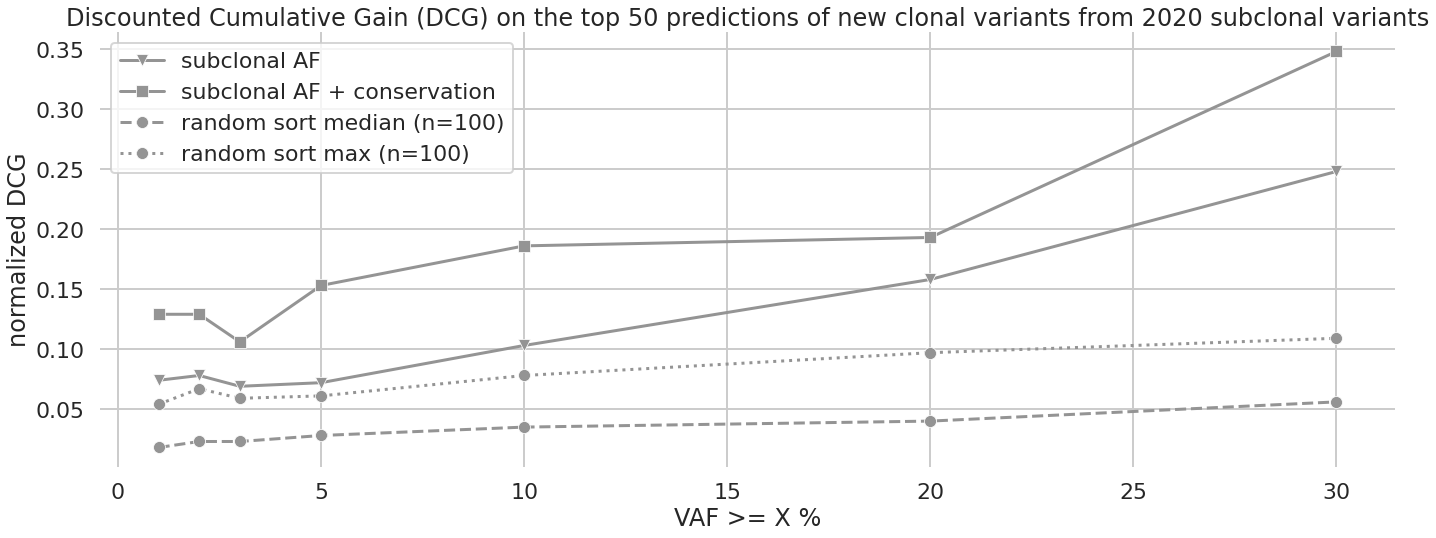

In [143]:
data = pd.DataFrame({"vaf_threshold":[1, 2, 3, 5, 10, 20, 30], 
                     "prioritization_by_subclonal_count":[0.074, 0.078, 0.069, 0.072, 0.103, 0.158, 0.248],
                     "prioritization_by_subclonal_count_and_conservation":[0.129, 0.129, 0.106, 0.153, 0.186, 0.193, 0.348],
                     "prioritization_random_median":[0.018, 0.023, 0.023, 0.028, 0.035, 0.04, 0.056],
                     "prioritization_random_max":[0.054, 0.067, 0.059, 0.061, 0.078, 0.097, 0.109]
                    })

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_by_subclonal_count", color=grey, label="subclonal AF", marker='v')
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_by_subclonal_count_and_conservation", color=grey, label="subclonal AF + conservation", marker='s')
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_random_median", color=grey, label="random sort median (n=100)", marker='o', linestyle='--', )
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_random_max", color=grey, label="random sort max (n=100)", marker='o', linestyle='dotted', )
#plt.axhline(1.0, linestyle='--', color=red, label="ideal (sort by clonal frequency)")
plt.title("Discounted Cumulative Gain (DCG) on the top 50 predictions of new clonal variants from 2020 subclonal variants")
plt.xlabel("VAF >= X %")
plt.ylabel("normalized DCG")
sns.despine(bottom=True, left=True)
ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(figure_output_folder, "figure_08_prediction_clonal_ndcg.jpg"), dpi=200)

In [144]:
def get_percentage_clonal(data):
    return data[data.count_clonal > 0].shape[0] / data[data.count_clonal == 0].shape[0]

print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf001))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf002))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf003))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf005))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf01))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf02))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf03))

0.2833348099583592
0.2833348099583592
0.2833348099583592
0.2833348099583592
0.33279483037156704
0.3712361331220285
0.40892193308550184


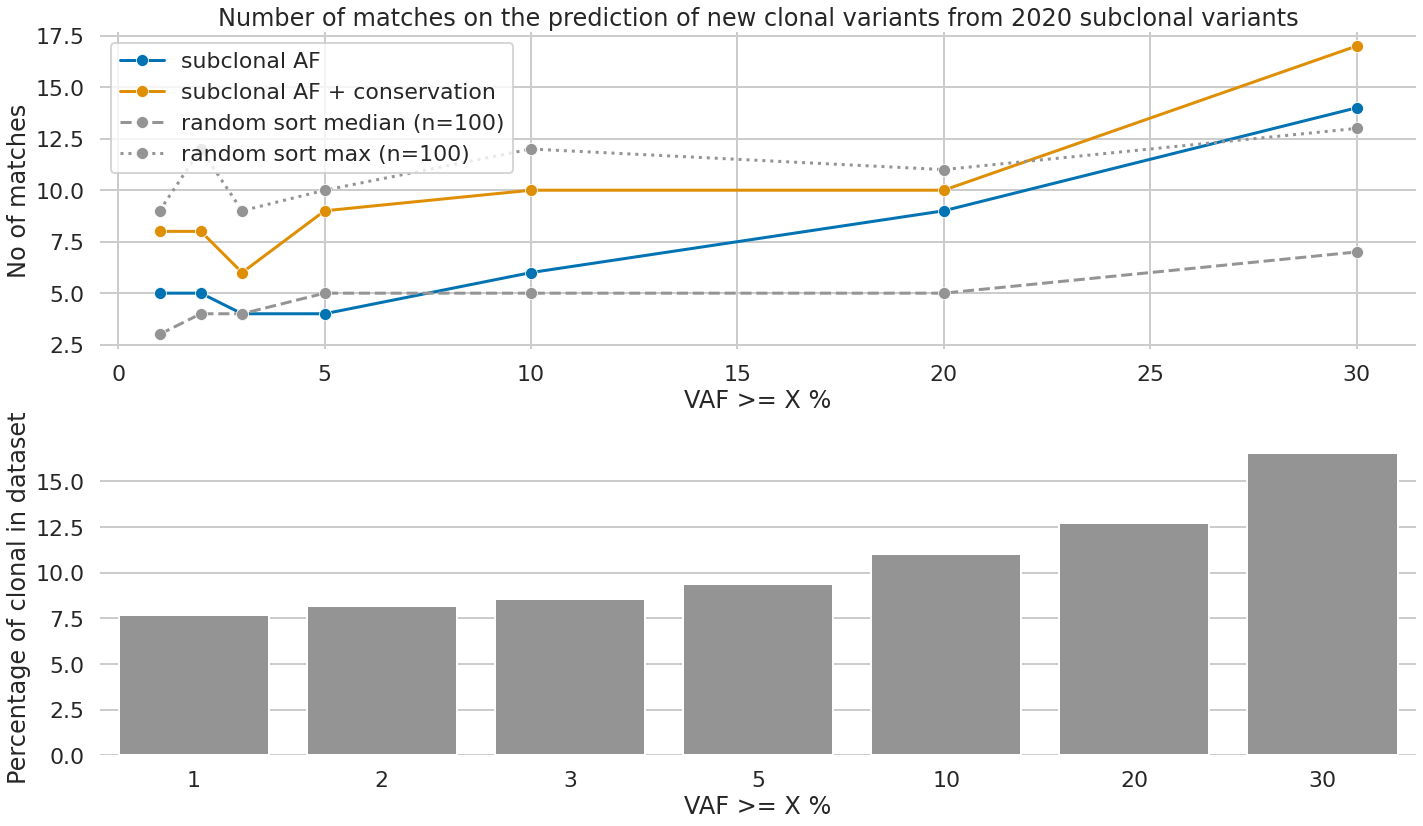

In [145]:
data = pd.DataFrame({"vaf_threshold":[1, 2, 3, 5, 10, 20, 30], 
                     "matches_by_subclonal_count":[5,5,4,4,6,9,14],
                     "matches_by_subclonal_count_and_conservation":[8,8,6,9,10,10,17],
                     "matches_random_median":[3,4,4,5,5,5,7],
                     "matches_random_max":[9,12,9,10,12,11,13],
                     "percent_clonal": [0.07680830747195035,0.08194740582800285,0.08579453922095089,0.09396302557670284,
                                        0.11007138722747443,0.127136021872864,0.16535819430814525]
                    })
data["percent_clonal"] =  data["percent_clonal"].transform(lambda x: round(x*100, 3))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
sns.lineplot(data=data, x="vaf_threshold", y="matches_by_subclonal_count", color=blue, label="subclonal AF", marker='o', ax=ax1)
sns.lineplot(data=data, x="vaf_threshold", y="matches_by_subclonal_count_and_conservation", color=orange, label="subclonal AF + conservation", marker='o', ax=ax1)
sns.lineplot(data=data, x="vaf_threshold", y="matches_random_median", color=grey, label="random sort median (n=100)", marker='o', linestyle='--', ax=ax1)
sns.lineplot(data=data, x="vaf_threshold", y="matches_random_max", color=grey, label="random sort max (n=100)", marker='o', linestyle='dotted', ax=ax1)
ax1.set_title("Number of matches on the prediction of new clonal variants from 2020 subclonal variants")
ax1.set_xlabel("VAF >= X %")
ax1.set_ylabel("No of matches")
sns.despine(bottom=True, left=True)
ax1.legend()

sns.barplot(data=data, x="vaf_threshold", y="percent_clonal", color=grey, ax=ax2)

ax2.set_xlabel("VAF >= X %")
ax2.set_ylabel("Percentage of clonal in dataset")

plt.tight_layout()
fig.savefig(os.path.join(figure_output_folder, "figure_08_prediction_clonal_matches.jpg"), dpi=200) 

### Prediction on current data

In [146]:
clonal_data_with_dates = add_dates_to_variants(clonal_snvs_non_synonymous, sample_ena_filtered_samples)
subclonal_data_with_dates = add_dates_to_variants(
    subclonal_snvs_filtered_vaf03[(subclonal_snvs_filtered_vaf03.annotation_highest_impact != "synonymous_variant") & 
                                 (~subclonal_snvs_filtered_vaf03.gene_name.isna())], sample_ena_filtered_samples)
only_subclonal = subclonal_data_with_dates[~subclonal_data_with_dates.variant_id.isin(clonal_data_with_dates.variant_id.unique())]

In [147]:
only_subclonal_counts = only_subclonal[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_subclonal"})
only_subclonal_counts_with_annotations = pd.merge(left=only_subclonal_counts, right=only_subclonal, on="variant_id", how="left").groupby("variant_id").first().reset_index()
only_subclonal_counts_with_annotations["af_cons"] = only_subclonal_counts_with_annotations[["count_subclonal", "cons_hmm_sars_cov_2"]].apply(lambda x: np.log(x[0])*x[1], axis=1)
top_50_predictions = only_subclonal_counts_with_annotations.sort_values("af_cons", ascending=True).head(50)
only_subclonal_counts_with_annotations[["variant_id", "hgvs_p", "gene_name", "count_subclonal", "cons_hmm_sars_cov_2", "af_cons"]]\
    .sort_values("af_cons", ascending=True).head(50).to_csv(
    os.path.join(figure_output_folder, "prediction_clonal_variants_20072021.csv"))
top_50_predictions[["variant_id", "hgvs_p", "gene_name", "count_subclonal", "cons_hmm_sars_cov_2", "af_cons"]]

variant_id         hgvs_p gene_name  count_subclonal  \
1310  23607:G>T        p.R682L         S                4   
1208  22646:G>C        p.V362L         S                3   
1060  21420:A>C  p.*7052Sext*?    ORF1ab               28   
474   14847:A>G       p.Y4861C    ORF1ab                3   
1308  23606:C>T        p.R682W         S                3   
1922   3231:G>A        p.G989D    ORF1ab                3   
1716  27765:C>G          p.L4V     ORF7b                2   
1207  22645:T>A        p.C361*         S                2   
1489  25324:C>A       p.C1254*         S                2   
1888  29594:A>C         p.I13L     ORF10                2   
63    10718:C>T       p.R3485*    ORF1ab                2   
518   15380:G>C       p.A5039P    ORF1ab                2   
614   16221:G>C       p.R5319P    ORF1ab                2   
388   13998:G>T       p.C4578F    ORF1ab                2   
1168  22373:C>T        p.Q271*         S                2   
363   13695:A>G       p.Q4477R    ORF1ab                2   
713   17418:G>T       p.S5718I    ORF1ab                2   
729    1757:G>T        p.A498S    ORF1ab                2   
551   15667:A>G  p.*5134Wext*?    ORF1ab                2   
1244  22942:T>G        p.N460K         S                2   
2082   4829:C>T       p.Q1522*    ORF1ab                2   
1243  22933:G>T        p.R457S         S                2   
917   19689:A>T       p.Q6475L    ORF1ab                2   
1125  22006:C>A        p.N148K         S                2   
1309  23607:G>A        p.R682Q         S                2   
1923   3236:C>G        p.Q991E    ORF1ab                2   
1250  23034:C>T        p.P491L         S                2   
1128  22025:A>G        p.S155G         S                2   
1654  27158:T>G        p.S212R         M                7   
1824  28998:A>T        p.Q242L         N                3   
1084  21736:C>G         p.F58L         S                2   
1755  28197:T>C        p.C102R      ORF8                2   
1742  28026:T>A         p.W45R      ORF8                2   
2018   4067:G>A       p.A1268T    ORF1ab                2   
1912   3177:C>A        p.P971H    ORF1ab                2   
1137  22076:T>A        p.S172T         S                2   
112    1143:T>G        p.L293R    ORF1ab                2   
1690  27450:C>A         p.H19Q     ORF7a                2   
1253  23064:A>G        p.N501S         S                2   
402   14157:A>G       p.H4631R    ORF1ab                2   
1769  28475:C>T         p.R68*         N                2   
1935   3354:G>T       p.G1030V    ORF1ab                3   
914   19672:C>A       p.D6469E    ORF1ab                2   
1760   2837:T>G        p.S858A    ORF1ab                2   
1980   3741:T>C       p.I1159T    ORF1ab                2   
2028   4217:A>G       p.R1318G    ORF1ab                2   
2494   9272:A>G       p.R3003G    ORF1ab                2   
1982   3762:T>C       p.V1166A    ORF1ab                2   
342   13445:G>A       p.A4394T    ORF1ab                2   
1380  24220:G>T        p.W886C         S                2   

      cons_hmm_sars_cov_2   af_cons  
1310             -1.02973 -1.427509  
1208             -1.27455 -1.400236  
1060             -0.35633 -1.187364  
474              -1.04511 -1.148171  
1308             -1.02973 -1.131274  
1922             -1.02973 -1.131274  
1716             -1.27455 -0.883451  
1207             -1.27455 -0.883451  
1489             -1.27455 -0.883451  
1888             -1.25436 -0.869456  
63               -1.04511 -0.724415  
518              -1.04511 -0.724415  
614              -1.04511 -0.724415  
388              -1.04511 -0.724415  
1168             -1.04511 -0.724415  
363              -1.04511 -0.724415  
713              -1.04511 -0.724415  
729              -1.04511 -0.724415  
551              -1.04511 -0.724415  
1244             -1.04511 -0.724415  
2082             -1.04511 -0.724415  
1243             -1.04511 -0.724415  
917              -1